# Linear operator as a sum of Pauli strings

Every linear operator in quantum mechanics can be expressed as a sum of Pauli strings considering every combination possible restricted to the dimension of our problem.

$$
O=\sum_{P\in P_m}c_P P
$$

In this code we'll calculate the coefficients corresponding with each Pauli string for a generic operator O and do an histogram to observe the size distribution of the operators.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate ,PauliGate
from qiskit.synthesis import MatrixExponential
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import Estimator, StatevectorEstimator, Sampler
from collections import Counter

from qutip import *
from qutip.qip.operations import *


## Functions and parameters

In [ ]:
N=4 #number of qubits

np.random.seed(1)  # seed to reproduce h samplings
np.random.rand(N)*0.2

In [9]:
# Variables


b = (np.pi / 4)  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
h=np.array([0.02935118, 0.01846772, 0.03725204, 0.06911215])


#Hamiltonian
terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()


#Evolution Op
def U(ham,t):
    U = PauliEvolutionGate(ham, time=t, synthesis=MatrixExponential())
    return U

#Gates
V=PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0])
W=PauliGate(['I'*i + 'X' + 'I'*(N-1-i) for i in [int(N/2)]][0])

#Another V gate
X1=Operator(PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0]))
X2=Operator(PauliGate(['I'*(i-1) + 'Z' + 'I'*(N-i) for i in [int(N/2)]][0]))


# V=1/np.sqrt(2)*(X1+1j*X2)

#Time evolution for operators (circuit)
def OpHeis(OpSch,t): 
    for temp in range(t):
        qc.append(U(H_I,1), left_reg)
        qc.append(U(H_K,1), left_reg)
    
    qc.append(OpSch, left_reg)

    for temp in range(t):
        qc.append(U(H_K,-1), left_reg)
        qc.append(U(H_I,-1), left_reg)


#Time evolution for operators (matrix)
def OpHeis_tr(OpSch,time):
    dag=PauliGate('I'*N)
    dag1= (np.dot(Operator(U(H_I,-1)),Operator(U(H_K,-1))))
    norm=PauliGate('I'*N)
    norm1=(np.dot(Operator(U(H_K,1)),Operator(U(H_I,1))))

    for _ in range(time):
        dag=np.dot(dag1,dag)
        norm=np.dot(norm1,norm)

    return np.dot(dag,np.dot(OpSch,norm))


#Possible combinations of Pauli matrices
def pauli_combinations(N):
    pauli_labels = ['I', 'X', 'Y', 'Z']

    combinations = itertools.product(pauli_labels, repeat=N)
    pauli_combinations = [''.join(comb) for comb in combinations]

    return pauli_combinations

#Get the possible combinations
comb=pauli_combinations(N)

sampler_v1 = Sampler() #sampler for the circuit


### Check if the evolution operators are unitary

In [3]:
dag1= (np.dot(Operator(U(H_I,-1)),Operator(U(H_K,-1))))
norm1=(np.dot(Operator(U(H_K,1)),Operator(U(H_I,1))))

np.all(np.round(np.dot(norm1,dag1),6)==np.eye(2**N) )


True

## Circuit

$$\left|c_P\right|^2= \left|\frac{1}{2^N}tr(O P)\right|^2=|\bra{\psi}O P \otimes I\ket{\psi}|^2$$

Beeing $\ket{\psi}=\ket{TFD(0)}=\frac{1}{Z^{1/2}}\sum \ket{i}\otimes\ket{i}$

In [30]:
coeff=[] #list of coefficients of each state of the circuit |psi>=coeff_0|0>+coeff_1|1>+...+coeff_n|n>

time=15
times=[]

for t in range(time):
    coeff_t=[]
    for com in comb:
        #Initialize the circuit
        left_reg = QuantumRegister(N, 'Left')
        right_reg = QuantumRegister(N, 'Right')
        qc=QuantumCircuit(left_reg,right_reg)

        #Initialize the TFD
        for i in range(N):
            qc.h(left_reg[i])
            qc.cx(left_reg[i], right_reg[i])
        

        #Pauli string and operator
        qc.append(PauliGate(com),left_reg)
        OpHeis(V,t)

        #Undo the TFD
        for i in range(N-1, -1, -1):
            qc.cx(left_reg[i], right_reg[i])
            qc.h(left_reg[i])
        
        #Measure
        qc.measure_all()
        job = sampler_v1.run(qc)
        dists = job.result().quasi_dists[0]

        coeff_t.append(dists) #append coefficients
    coeff.append(coeff_t) #append coefficients for each time



    ceros=[] #list for coeffs in the state |0>

    for i in range(len(coeff_t)):
        cero=coeff_t[i].get(0) #get the coefficient from the dictionary
        try:
            ceros.append(np.round(cero,6))
        except:
            ceros.append(0)


    coefs_cd = dict(zip(comb, ceros)) #create another dictionary associating the coefficients with the states

    times.append(coefs_cd) #at each time


    '''
    Al parecer se puede conseguir el mismo resultado de extraer los ceros de esta forma como dists[0]. Eso es el valor asociado al 0.
    '''


In [31]:
print(times[0])

{'IIII': 0, 'IIIX': 0, 'IIIY': 0, 'IIIZ': 0, 'IIXI': 0, 'IIXX': 0, 'IIXY': 0, 'IIXZ': 0, 'IIYI': 0, 'IIYX': 0, 'IIYY': 0, 'IIYZ': 0, 'IIZI': 0, 'IIZX': 0, 'IIZY': 0, 'IIZZ': 0, 'IXII': 1.0, 'IXIX': 0, 'IXIY': 0, 'IXIZ': 0, 'IXXI': 0, 'IXXX': 0, 'IXXY': 0, 'IXXZ': 0, 'IXYI': 0, 'IXYX': 0, 'IXYY': 0, 'IXYZ': 0, 'IXZI': 0, 'IXZX': 0, 'IXZY': 0, 'IXZZ': 0, 'IYII': 0, 'IYIX': 0, 'IYIY': 0, 'IYIZ': 0, 'IYXI': 0, 'IYXX': 0, 'IYXY': 0, 'IYXZ': 0, 'IYYI': 0, 'IYYX': 0, 'IYYY': 0, 'IYYZ': 0, 'IYZI': 0, 'IYZX': 0, 'IYZY': 0, 'IYZZ': 0, 'IZII': 0, 'IZIX': 0, 'IZIY': 0, 'IZIZ': 0, 'IZXI': 0, 'IZXX': 0, 'IZXY': 0, 'IZXZ': 0, 'IZYI': 0, 'IZYX': 0, 'IZYY': 0, 'IZYZ': 0, 'IZZI': 0, 'IZZX': 0, 'IZZY': 0, 'IZZZ': 0, 'XIII': 0, 'XIIX': 0, 'XIIY': 0, 'XIIZ': 0, 'XIXI': 0, 'XIXX': 0, 'XIXY': 0, 'XIXZ': 0, 'XIYI': 0, 'XIYX': 0, 'XIYY': 0, 'XIYZ': 0, 'XIZI': 0, 'XIZX': 0, 'XIZY': 0, 'XIZZ': 0, 'XXII': 0, 'XXIX': 0, 'XXIY': 0, 'XXIZ': 0, 'XXXI': 0, 'XXXX': 0, 'XXXY': 0, 'XXXZ': 0, 'XXYI': 0, 'XXYX': 0, 'XXYY':

### Operator size

Here we meassure the operator size, in order to do that we have to count every Pauli matrix different from the identity in each Pauli string. Beeing the $size$ equal to that number, for each string.

In [32]:
l_times=[] #list with the sizes
p=[] #list with the coeffs asociated with the strings, i needed it to do some tests

for t in range(time):
    
    #Get the non-zero coefficients
    non_zero_keys = [key for key, value in times[t].items() if value != 0]
    non_zero_coeff = [value for key, value in times[t].items() if value != 0]

    p.append([non_zero_keys, non_zero_coeff]) #test
    
    # Count the number of elements different from the identity
    l=[]
    for pauli in non_zero_keys:
        count_different = sum(1 for char in pauli if char != 'I')
        l.append(count_different)
    
    l_times.append(l)


### Histogram

We could do an histogram at each time of the sizes that appear in our operator. We should see a $\textit{peak size}$ around some length.


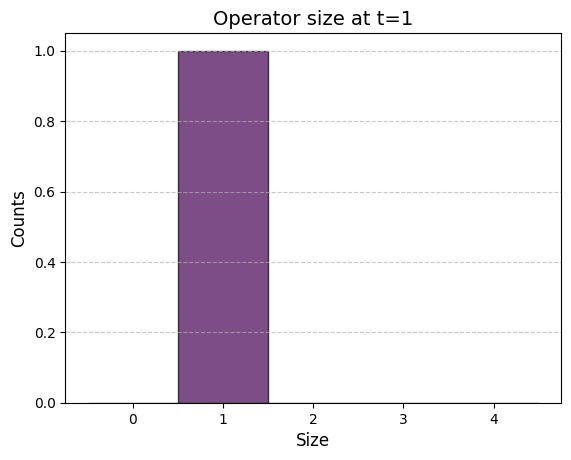

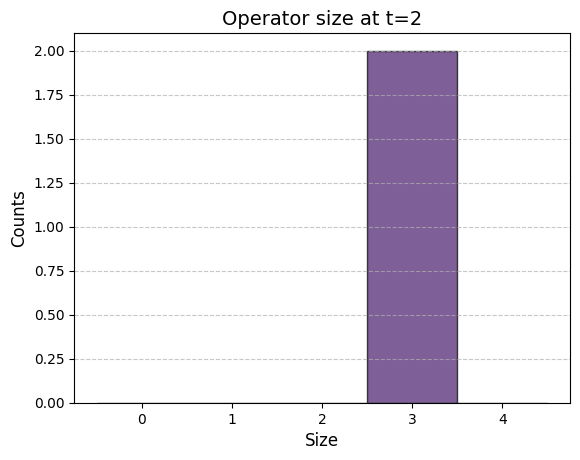

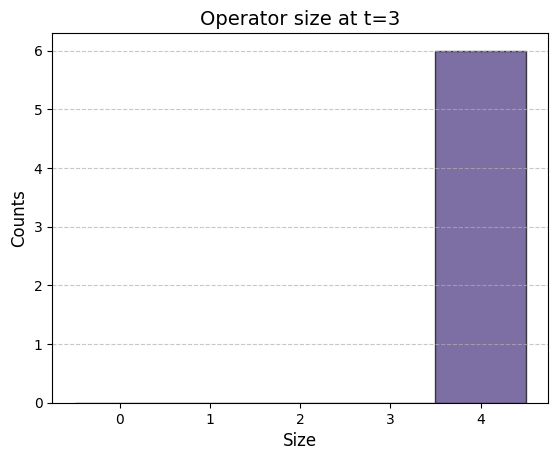

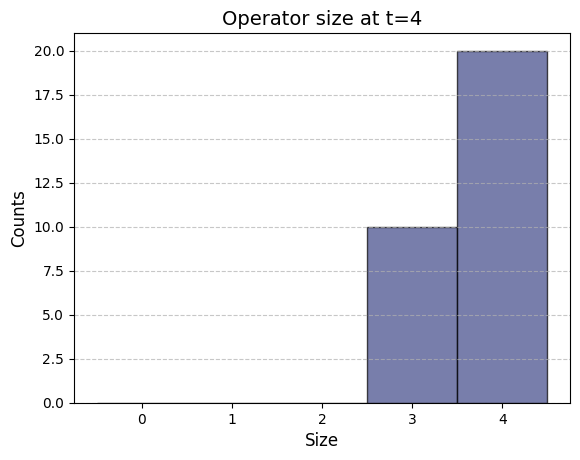

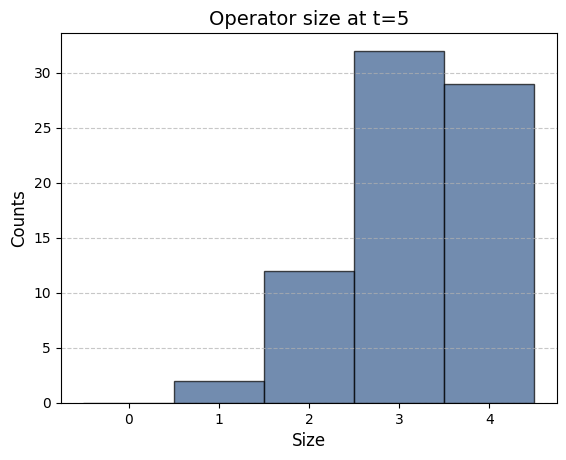

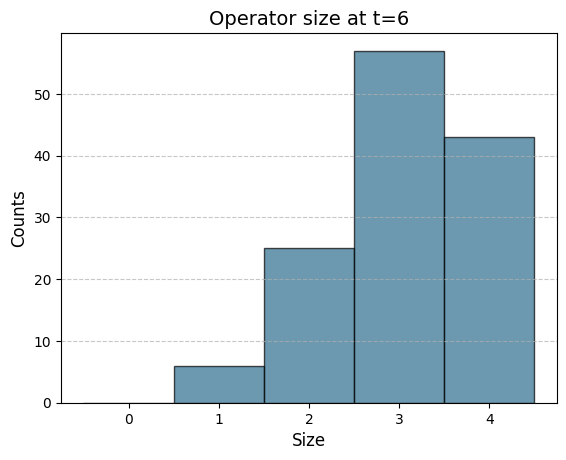

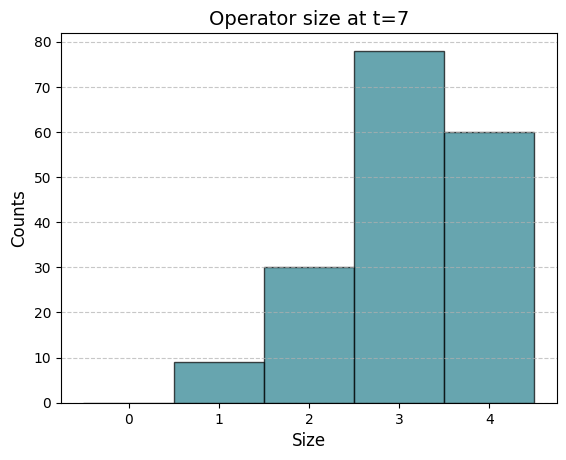

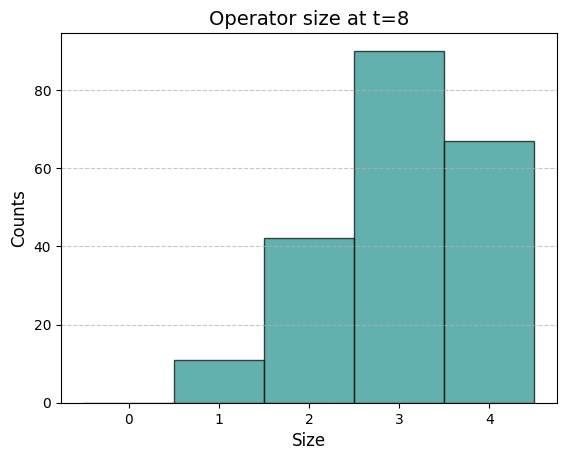

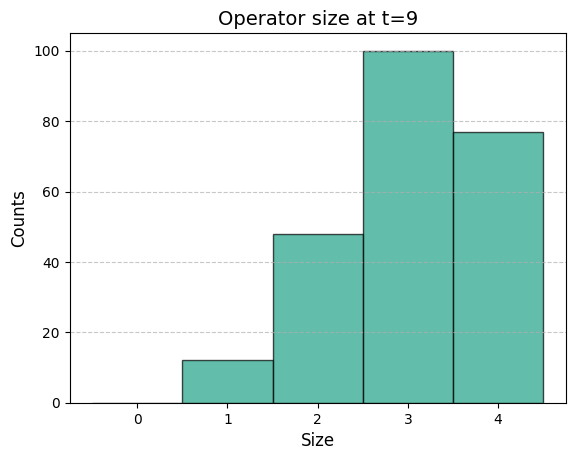

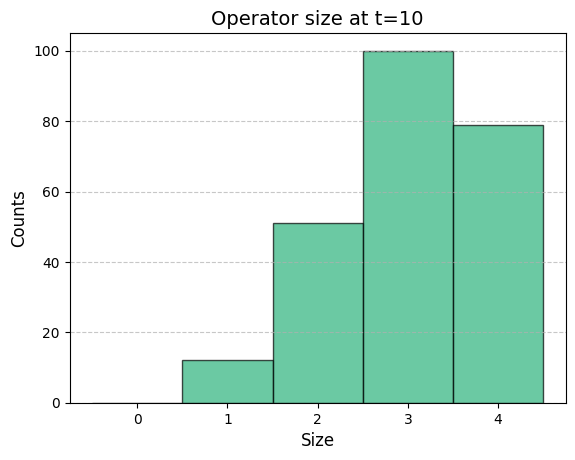

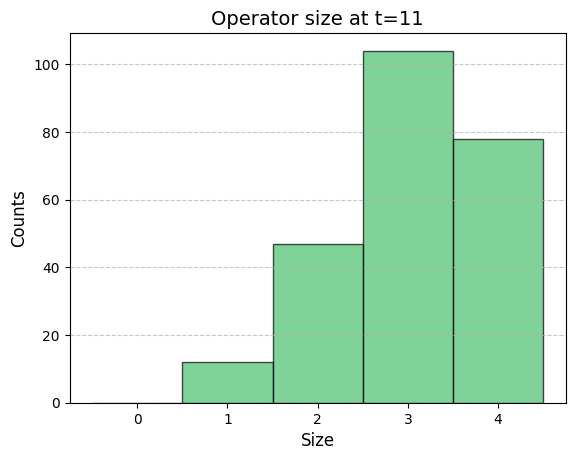

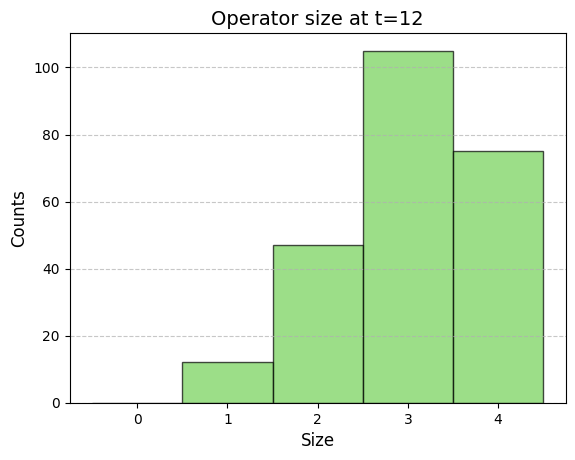

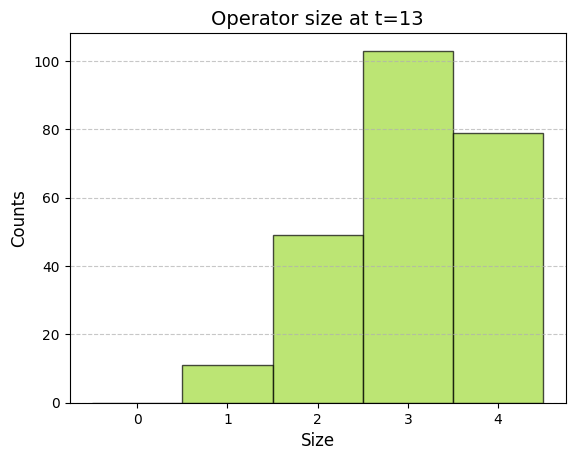

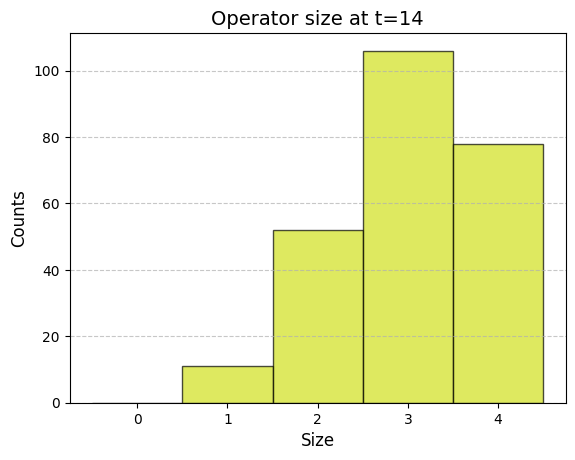

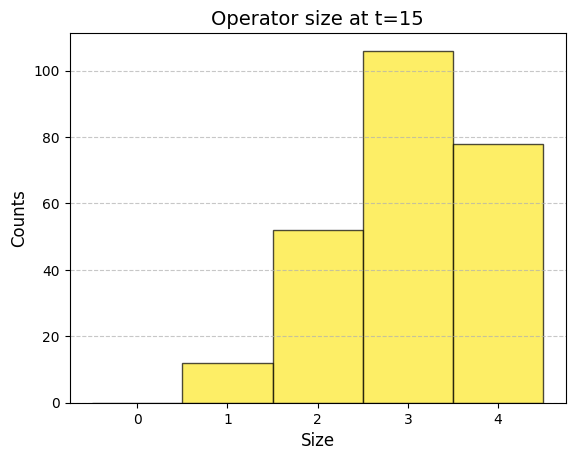

In [33]:
#Parameters of the histogram
colors = plt.cm.viridis(np.linspace(0, 1, time))
bins = np.arange(-0.5,N+1.5,1)

for t in range(time):
    plt.figure(t+1)
    plt.hist(l_times[t], bins=bins, color=colors[t], edgecolor='black', alpha=0.7)
    plt.xlabel('Size', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Operator size at t=%g' % (t+1), fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


### Variance of the data

In [34]:
# We calculate the variance of the sizes
var=[]
for t in range(time):
    var.append(np.var(l_times[t]))

print(var)

[0.0, 0.0, 0.0, 0.22222222222222232, 0.6232888888888888, 0.7001922964862187, 0.7072680264291871, 0.7283673469387753, 0.7295127205397995, 0.7352639847004987, 0.7169986742652502, 0.7110169639887255, 0.7096509801243083, 0.7041911849071447, 0.7176768990634756]


### Operator representation

For seeing clearly what is the sum of the Pauli strings at each time we can print it

In [35]:
for t in range(time):
    operator = ""
    for pauli_string, coefficient in times[t].items():
        if coefficient.imag == 0:
            real_coefficient = coefficient.real
        else:
            real_coefficient = coefficient
        rounded_coefficient = np.round(real_coefficient**(1/2), 4)
        if rounded_coefficient != 0:
            operator += f"({rounded_coefficient}*{pauli_string}) + "
    operator = operator[:-3]  # to remove the extra ' + ' at the end
    print("V(t=%i) = " %(t+1) + operator)

V(t=1) = (1.0*IXII)
V(t=2) = (0.9588*ZXZI) + (0.2842*ZYZI)
V(t=3) = (0.1526*XXXZ) + (0.0452*XYXZ) + (0.2802*XZYZ) + (0.9065*YXXZ) + (0.2687*YYXZ) + (0.0472*YZYZ)
V(t=4) = (0.0311*IXXX) + (0.2557*IXXY) + (0.0133*IXZX) + (0.0017*IXZY) + (0.1049*IYXX) + (0.8628*IYXY) + (0.0449*IYZX) + (0.0055*IYZY) + (0.0174*XXXX) + (0.1432*XXXY) + (0.263*XXZX) + (0.032*XXZY) + (0.0052*XYXX) + (0.0425*XYXY) + (0.078*XYZX) + (0.0095*XYZY) + (0.001*XZYX) + (0.0075*XZYY) + (0.003*YXXX) + (0.0241*YXXY) + (0.0443*YXZX) + (0.0054*YXZY) + (0.001*YYXX) + (0.0071*YYXY) + (0.0131*YYZX) + (0.0017*YYZY) + (0.0054*YZYX) + (0.0443*YZYY) + (0.0324*ZIYX) + (0.2667*ZIYY)
V(t=5) = (0.8628*IIXI) + (0.0446*IIXX) + (0.0054*IIXY) + (0.0054*IIYI) + (0.1041*IIYX) + (0.0126*IIYY) + (0.0126*IXIZ) + (0.0014*IXXI) + (0.001*IXXX) + (0.0069*IXYI) + (0.0125*IXYX) + (0.0014*IXYY) + (0.0014*IXZY) + (0.0425*IYIZ) + (0.0052*IYXI) + (0.0028*IYXX) + (0.0231*IYYI) + (0.0421*IYYX) + (0.0051*IYYY) + (0.0051*IYZY) + (0.0071*XXIZ) + (0.0302*XXXI)

### Most common lenght

Now we do a plot of the most common lenght of each time vs time to se how the size evolves

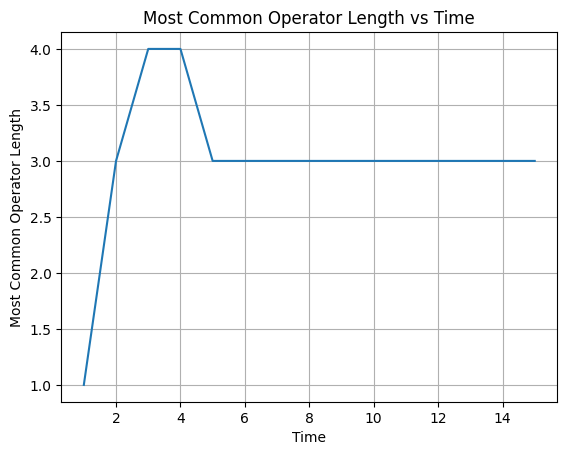

In [36]:
# Count the occurrences of each operator length at each time step
operator_lengths = []
for t in range(time):
    operator_lengths.append(Counter(l_times[t]))

# Get the most common operator length at each time step
most_common_lengths = [length.most_common(1)[0][0] for length in operator_lengths]

# Plot the most common operator length vs time
plt.plot(range(1, time+1), most_common_lengths)
plt.xlabel('Time')
plt.ylabel('Most Common Operator Length')
plt.title('Most Common Operator Length vs Time')
plt.grid(True)
plt.show()

## Trace

Now we are going to perform the same calculation but with another method. Instead of calculating the coefficients via a circuit we are going to calculate them analtically with the trace of the operator multplied by the string. 
$$(c_P)= \frac{1}{2^N}tr(O P)$$

Since we do not have an actual quantum computer, if we want to rise the number of qubits (N) we'll need to simulate the circuit.

In [10]:
time=10
times_tr=[]

for t in range(time):
    coeft=[]

    for com in comb:
        coeft.append(np.trace(np.dot(OpHeis_tr(V,t),PauliGate(com)))*(1/2**N))

    coefs_tr = dict(zip(comb, coeft))

    times_tr.append(coefs_tr)

In [51]:
np.trace(np.dot(OpHeis_tr(V,5),Operator(PauliGate('IXII'))))*(1/2**N)

(0.11340338372293746-0.07869646882810317j)

### Get the sizes

Same code as before

In [11]:
l_times_tr=[]

for t in range(time):
    non_zero_keys = [key for key, value in times_tr[t].items() if value != 0]

    # Count the number of elements different from the identity
    l=[]
    for pauli in non_zero_keys:
        count_different = sum(1 for char in pauli if char != 'I')
        l.append(count_different)    
    l_times_tr.append(l)

### Histogram

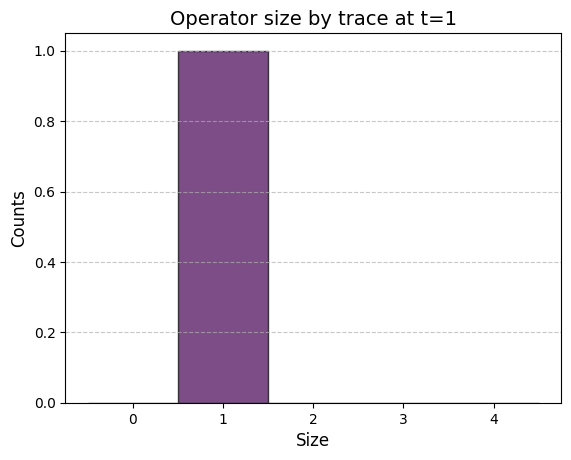

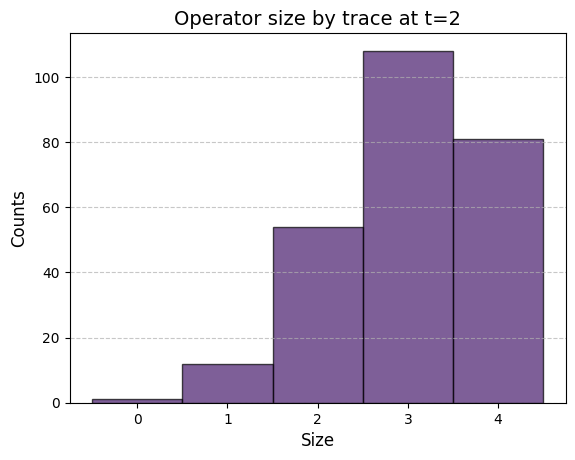

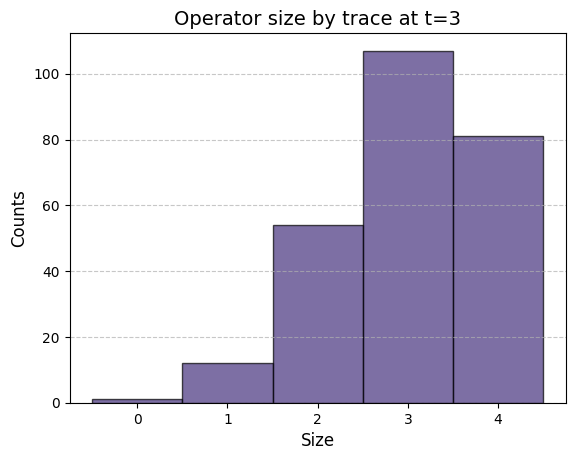

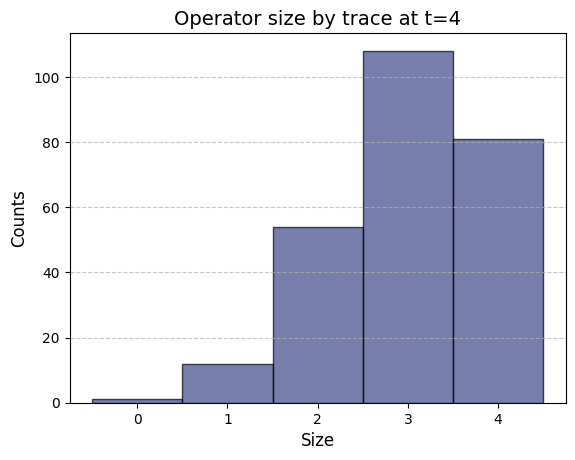

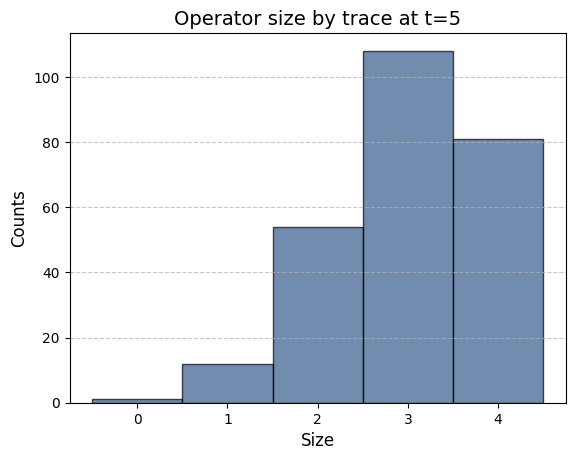

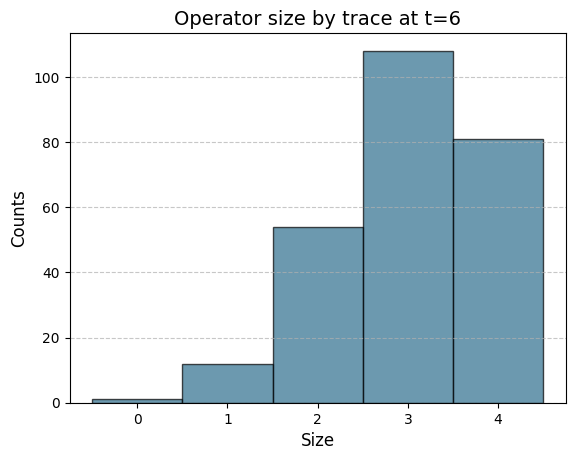

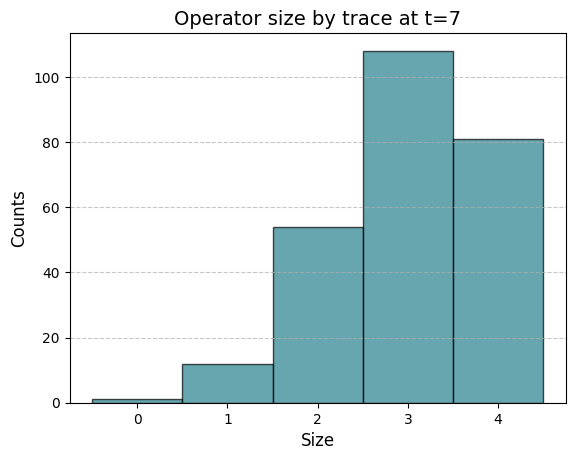

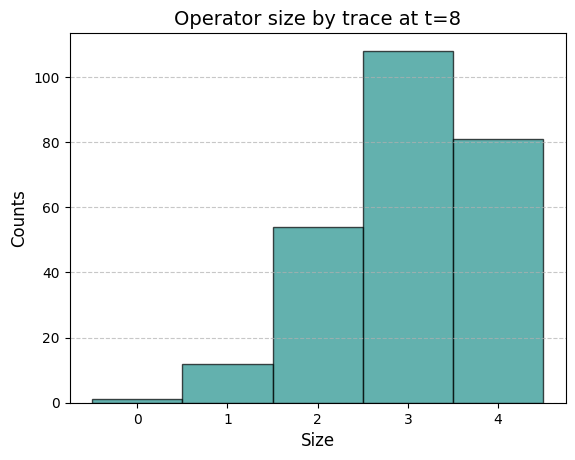

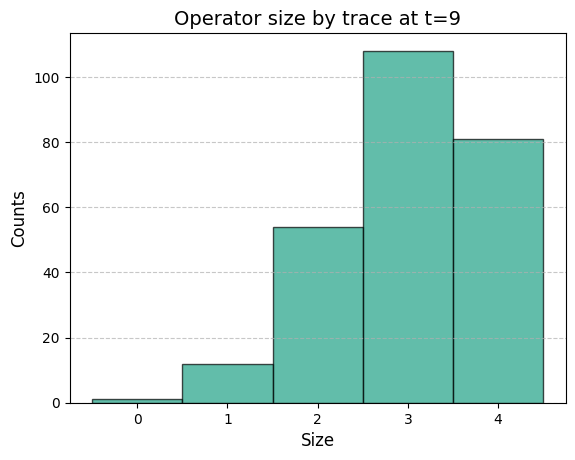

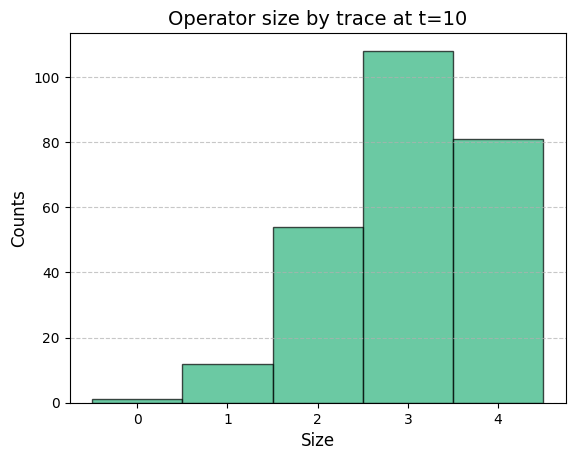

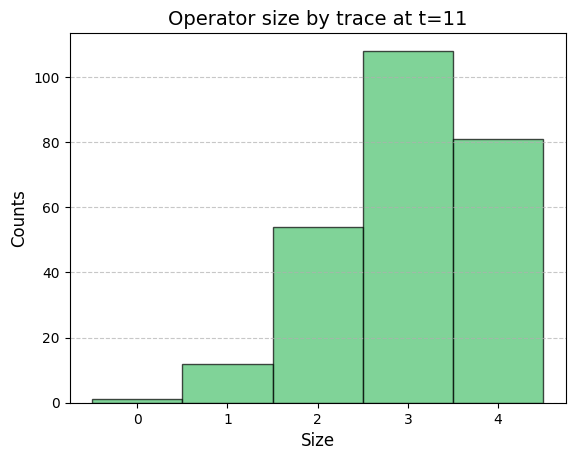

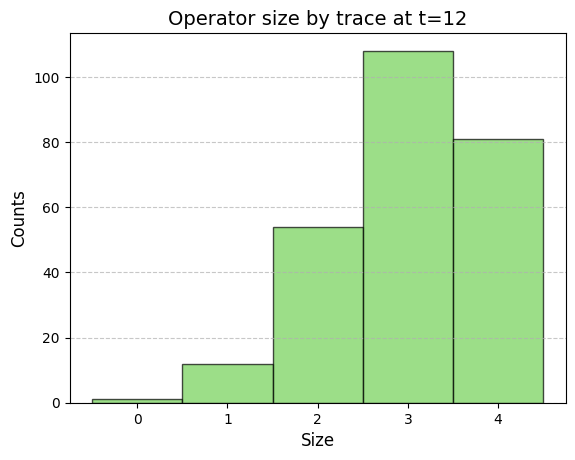

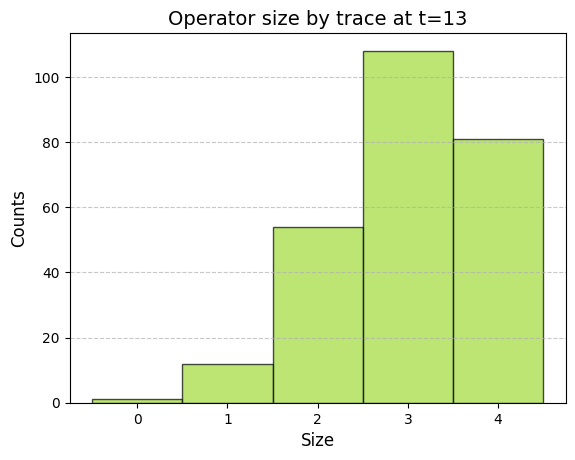

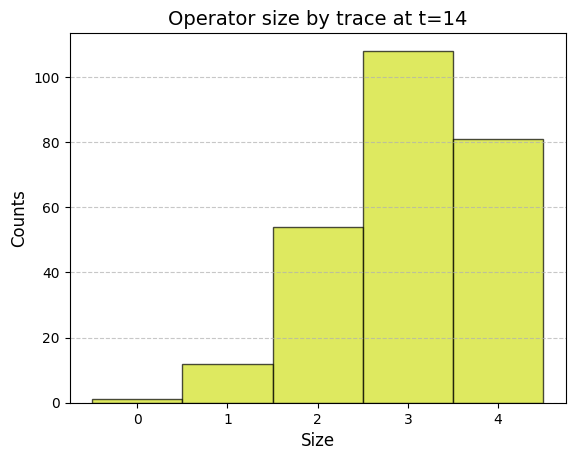

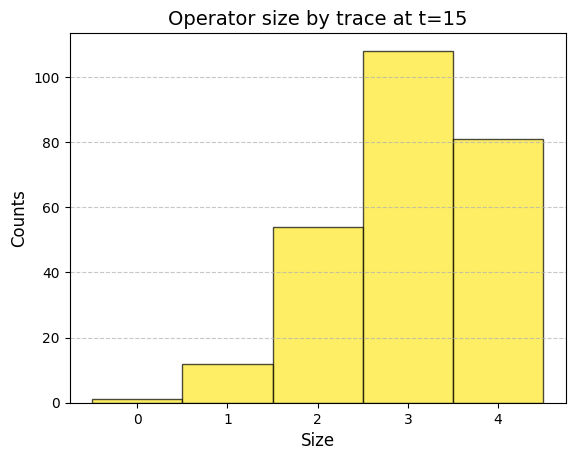

In [40]:
colors = plt.cm.viridis(np.linspace(0, 1, time))
bins = np.arange(-0.5,N+1.5,1)

for t in range(time):
    plt.figure(2*t+1)
    plt.hist(l_times_tr[t], bins=bins, color=colors[t], edgecolor='black', alpha=0.7)
    plt.xlabel('Size', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Operator size by trace at t=%g' % (t+1), fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

### Variance

In [41]:
#Get the variance of the operators
var=[]
for t in range(time):
    var.append(np.var(l_times_tr[t]))

print(var)

[0.0, 0.75, 0.7529411764705882, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]


### Operator representation

In [53]:
for t in range(time):
    operator = ""
    for pauli_string, coefficient in times_tr[t].items():
        if np.round(coefficient.imag,5) == 0:
            real_coefficient = coefficient.real
        else:
            real_coefficient = coefficient
        rounded_coefficient = np.round(real_coefficient, 4)
        if rounded_coefficient != 0:
            operator += f"({rounded_coefficient}*{pauli_string}) + "
    operator = operator[:-2]  # to remove the extra ' + ' at the end
    print("V(t=%i) = " %(t) + operator)

V(t=0) = (0.7071*IXII) + (0.7071j*IZII) 
V(t=1) = ((-0-0.0706j)*IZII) + ((-0.2872-0.6429j)*ZXZI) + ((0.6461-0.2858j)*ZYZI) 
V(t=2) = ((0.0018+0.0023j)*IXII) + ((-0.0235-0.0595j)*IXXZ) + ((-0.0024-0.006j)*IYII) + ((-0.0174-0.0234j)*IYXZ) + (0.007j*IZII) + ((0.0502-0.0222j)*XIZI) + ((-0.0145-0.0368j)*XXII) + ((-0.1076-0.144j)*XXXZ) + ((-0.0108-0.0144j)*XYII) + ((0.1447+0.367j)*XYXZ) + ((-0-0.0001j)*XYYZ) + ((0.0001-0j)*XZXZ) + ((0.5-0.2211j)*XZYZ) + ((-0.0395+0.0175j)*YIZI) + ((-0.0184-0.0467j)*YXII) + ((-0.1366-0.1828j)*YXXZ) + ((-0.0137-0.0183j)*YYII) + ((0.1837+0.4659j)*YYXZ) + ((-0-0.0001j)*YYYZ) + ((-0.0001+0j)*YZXZ) + ((-0.3939+0.1742j)*YZYZ) + ((-0.0639+0.0282j)*ZIYZ) + (0.0642j*ZXZI) + ((-0+0.0285j)*ZYZI) + ((-0.0064+0.0028j)*ZZZI) 
V(t=3) = ((0.0017+0.0023j)*IIXI) + ((-0.008-0.0108j)*IIYX) + ((-0.0153-0.0205j)*IIYY) + ((0.0001-0.0003j)*IXII) + ((-0.0354+0.0157j)*IXIZ) + ((0.0016-0.0007j)*IXXI) + ((-0.054-0.0682j)*IXXX) + ((-0.1028-0.1299j)*IXXY) + ((0.0003+0.0058j)*IXXZ) + ((-0.

### Most common length

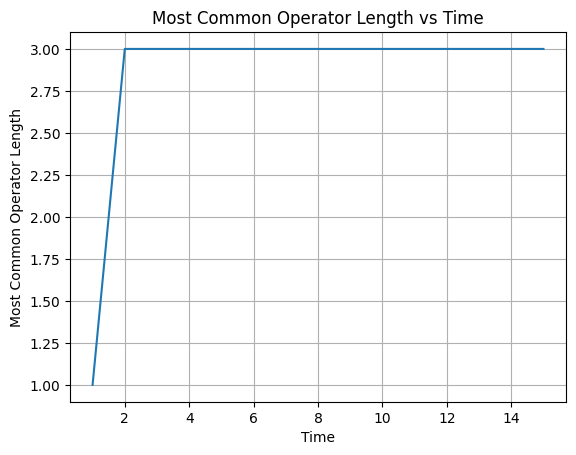

In [43]:
#Most common lenght but whit trace
# Count the occurrences of each operator length at each time step
operator_lengths_tr = []
for t in range(time):
    operator_lengths_tr.append(Counter(l_times_tr[t]))

# Get the most common operator length at each time step
most_common_lengths_tr = [length.most_common(1)[0][0] for length in operator_lengths_tr]

# Plot the most common operator length vs time
plt.plot(range(1, time+1), most_common_lengths_tr)
plt.xlabel('Time')
plt.ylabel('Most Common Operator Length')
plt.title('Most Common Operator Length vs Time')
plt.grid(True)
plt.show()

## Comparing the coefficients

Now we get to compare the coefficients calculated with each method. They have to be the same, that will tell us if we are doing things good.

In [44]:
#Comparing function
for t in range(time):
    for key in times[t].keys(): 
        if np.round(np.sqrt(times[t][key]), 2) != np.round(np.abs(times_tr[t][key]), 2): #Only the coefficients that are different are printed
            print(f"Time: {t+1}, Pauli string: {key}, Coefficient (sampler): {np.sqrt(times[t][key])}, Coefficient (trace): {np.abs(times_tr[t][key])}")


Time: 6, Pauli string: YYYX, Coefficient (sampler): 0.005, Coefficient (trace): 0.0050463040465037745
Time: 7, Pauli string: IZYY, Coefficient (sampler): 0.005, Coefficient (trace): 0.00504894655672181
Time: 11, Pauli string: IZXX, Coefficient (sampler): 0.025, Coefficient (trace): 0.025001788483674535
Time: 13, Pauli string: XYXZ, Coefficient (sampler): 0.005, Coefficient (trace): 0.005039185509077443
Time: 13, Pauli string: YIZI, Coefficient (sampler): 0.005, Coefficient (trace): 0.005023139197453361
Time: 13, Pauli string: YYZY, Coefficient (sampler): 0.005, Coefficient (trace): 0.005029976532625319
Time: 13, Pauli string: ZIZX, Coefficient (sampler): 0.015, Coefficient (trace): 0.014993541037214545
Time: 14, Pauli string: ZIYI, Coefficient (sampler): 0.005, Coefficient (trace): 0.005029735248080411
Time: 14, Pauli string: ZZYZ, Coefficient (sampler): 0.005, Coefficient (trace): 0.0050231571389166355


### Ploting the comparations

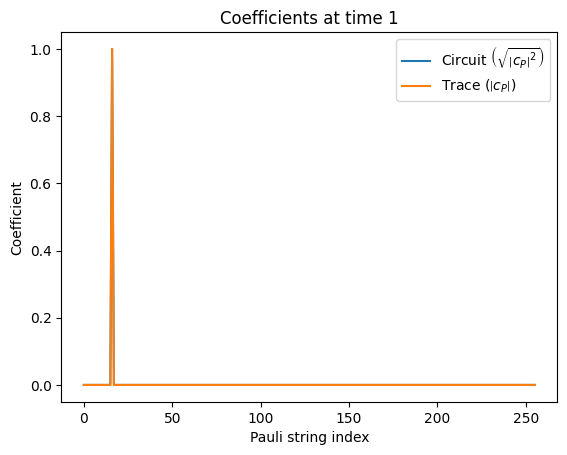

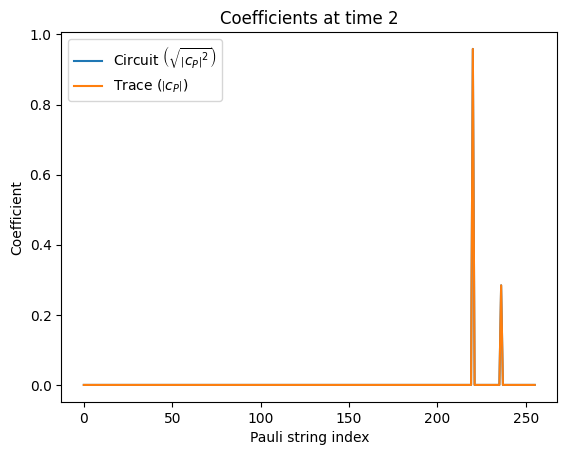

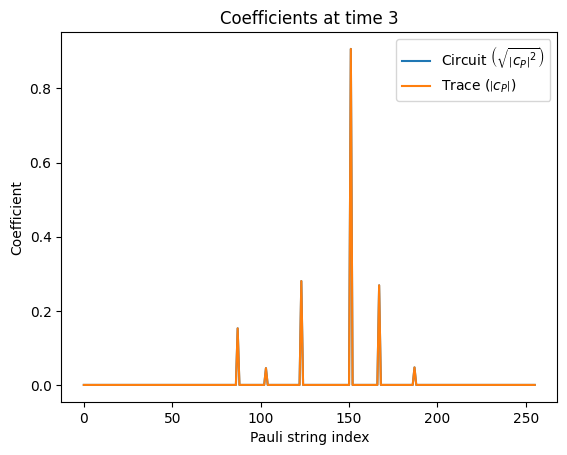

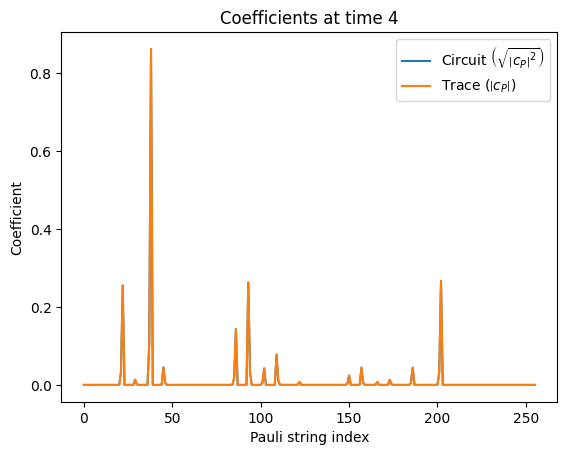

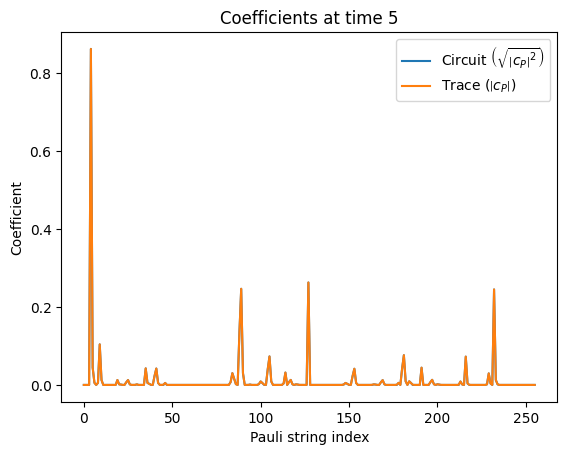

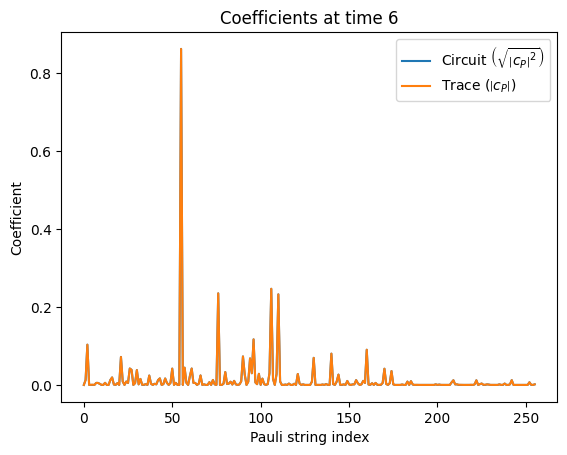

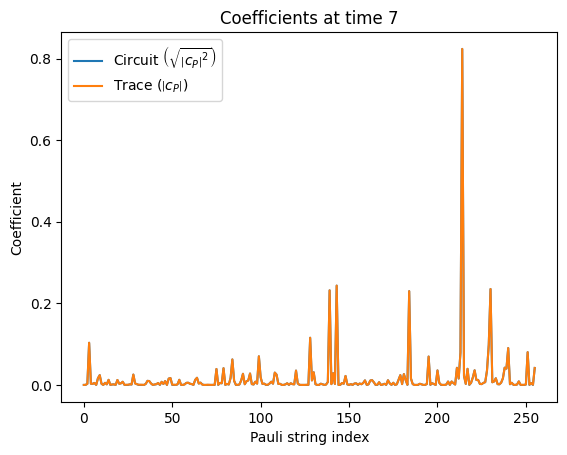

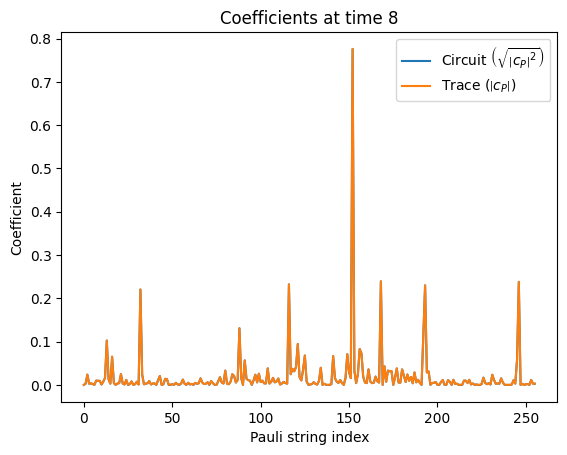

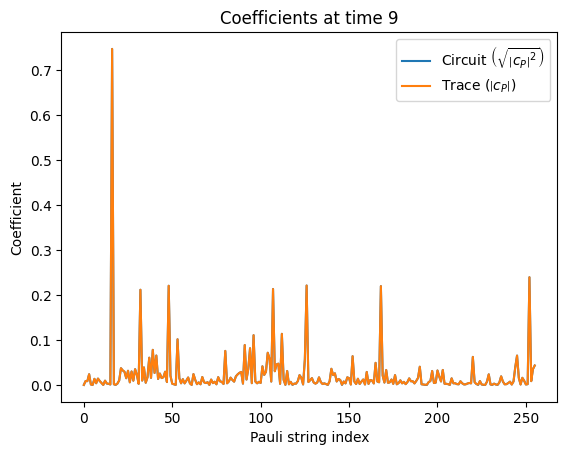

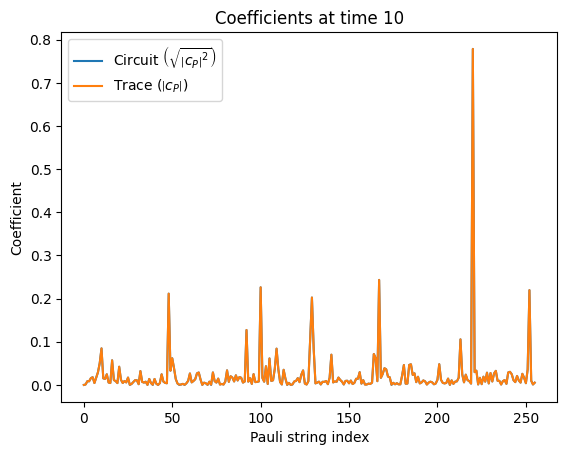

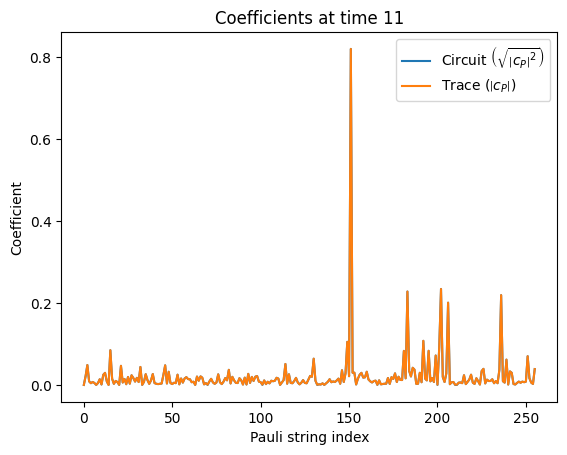

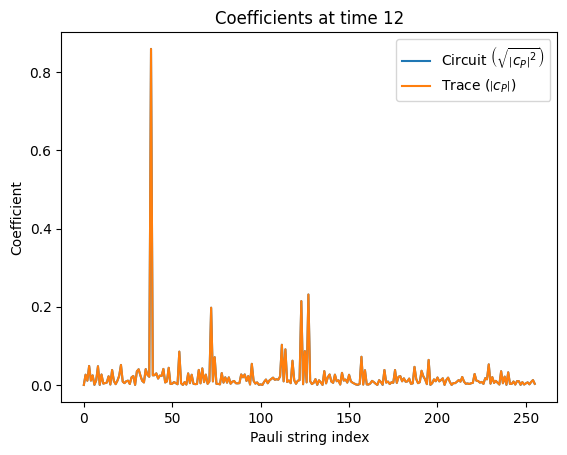

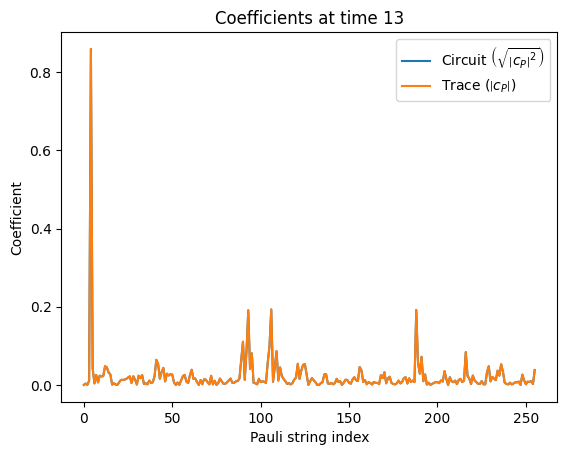

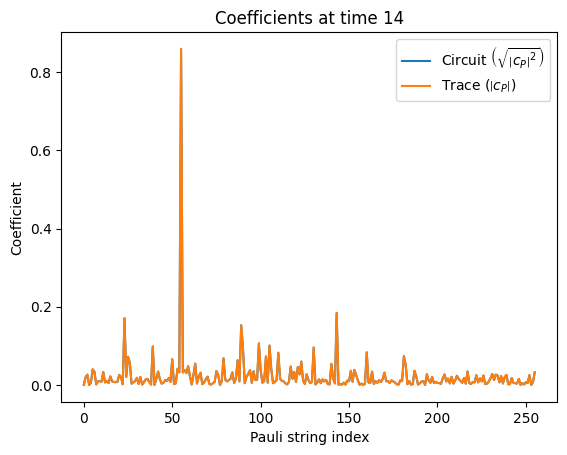

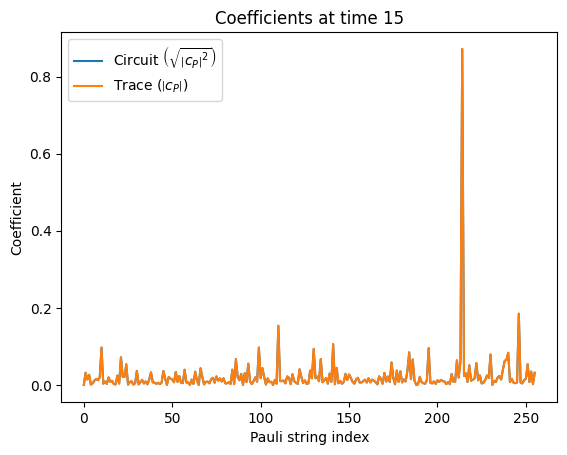

In [45]:
# We plot the coefficients for each time

for t in range(time):
    fig, ax = plt.subplots()
    var = np.sqrt(list(times[t].values()))  # We do the sqrt
    ax.plot(var, label=r'Circuit $\left(\sqrt{\left|c_P\right|^2}\right)$')
    var_tr=np.abs(list(times_tr[t].values())) #We do the module
    ax.plot(var_tr, label=r'Trace ($\left|c_P\right|$)')
    ax.set_xlabel('Pauli string index')
    ax.set_ylabel('Coefficient')
    ax.set_title(f'Coefficients at time {t+1}')
    ax.legend()
    plt.show()      


## Size distribution

Now we get the winding size distribution ($q_{O}$) and the size distribution ($Q_O$). Which are defined as:

$$q_O(l)=\sum_{\left|P\right|=l} c_P^2 \quad \ Q_O(l)=\sum_{\left|P\right|=l} \left|c_P\right|^2$$

Beeing of course: $O=\sum_{P\in P_m} c_P P$

In [12]:
# First we order a little bit

# We create a list of lists to store the values of the coefficients of the operators at each time and size
q_i = [[[] for _ in range(N+1)] for i in range(time)] # q_i[time][size][coefficients]


for t in range(time):
    for pauli, value in times_tr[t].items():
        count_different = sum(1 for char in pauli if char != 'I')# Count the number of elements different from the identity
        q_i[t][count_different].append(value) #Insert the elements. q_i[time][size][coefficients]

# We calculate the sum of the coefficients for each time and size
q=[] #for q_O form q[time][size]
q_mod=[] #for Q_O

for t in range(time):
    q_assist = []
    q_assist_mod=[]
    for l in range(N+1):
        c_q=np.array(q_i[t][l])
        c_Q=np.array(np.abs(q_i[t][l]))
        q_assist.append(sum(c_q**2)) #sum the coefficients squared for each time and length
        q_assist_mod.append(sum(c_Q**2)) #sum the module of the coefficients squared for each time and length
    q.append(q_assist)
    q_mod.append(q_assist_mod)


In [66]:
print(q_i[2][1])

[(1.5889057193182172e-18-6.626980432759072e-18j), (7.259834563848443e-18+1.7484025327633608e-17j), (-2.3281976357821362e-17-9.428238908819446e-18j), (-2.2491279290667127e-17+3.472478159520228e-19j), (3.2459168885938973e-17+9.193731301920416e-18j), (-1.6156675564640192e-17-4.3686770762163125e-17j), (3.356706742900624e-18-3.36903172136822e-17j), (-6.236886686993432e-18+1.4397901729850838e-17j), (4.27668279291065e-18+1.3874756600247893e-18j), (1.3530539991862431e-17-2.7726270469004878e-17j), (3.518827628556171e-17+4.19806112393954e-17j), (-2.994877151282743e-17+7.156862737003463e-18j)]


### Test if sum(c^2)=1

In [13]:
#Comprobamos que la suma de los coeficientes sea 1
q_mod_sum=[]
for t in range(time):
    print(f'Time {t+1}: {sum(q_mod[t])}')
    q_mod_sum.append(sum(q_mod[t]))
    


Time 1: 1.0
Time 2: 1.0
Time 3: 1.0000000000000002
Time 4: 1.0
Time 5: 0.9999999999999999
Time 6: 1.0000000000000002
Time 7: 0.9999999999999998
Time 8: 1.0
Time 9: 1.0000000000000002
Time 10: 1.0000000000000002


### Plots

#### Sum of the coefficients vs time

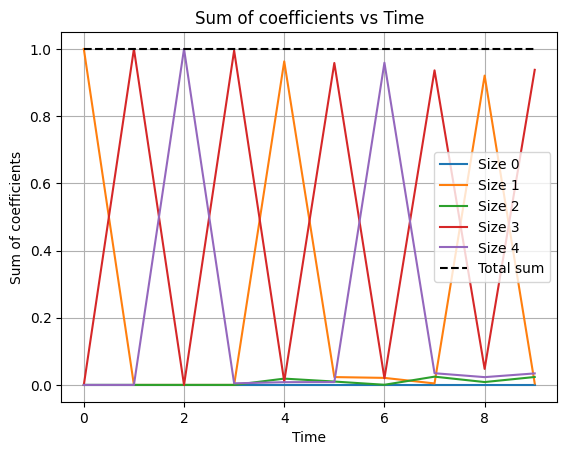

In [14]:
# Plot the sum of the coefficientsvs time
for n in range(N+1):
    q_temp = [q_mod[t][n] for t in range(time)]
    plt.plot(range(time), q_temp, label=f'Size {n}') #sum of the coefficients squared for each length
plt.plot(range(time), q_mod_sum, 'k--', label='Total sum')# Total sum 
plt.xlabel('Time')
plt.ylabel('Sum of coefficients')
plt.title('Sum of coefficients vs Time')
plt.legend()
plt.grid(True)
plt.show()



#### Histograms to compare with 

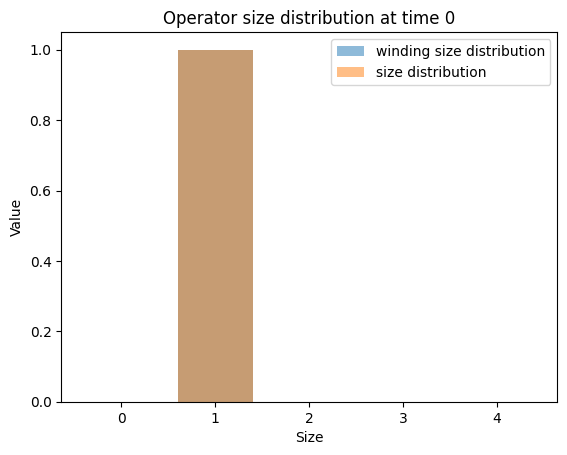

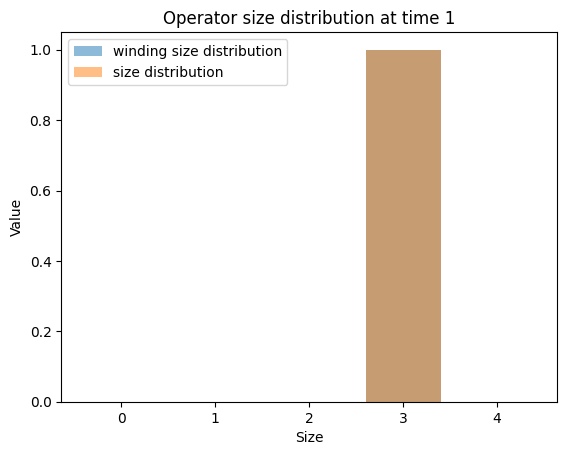

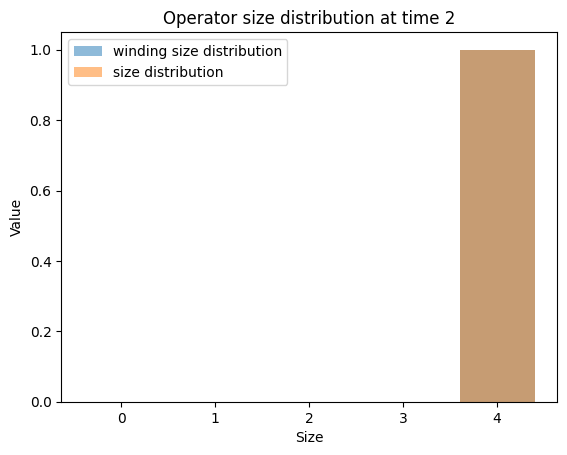

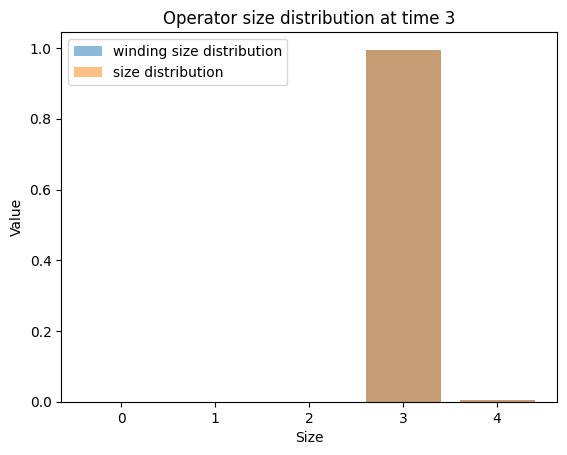

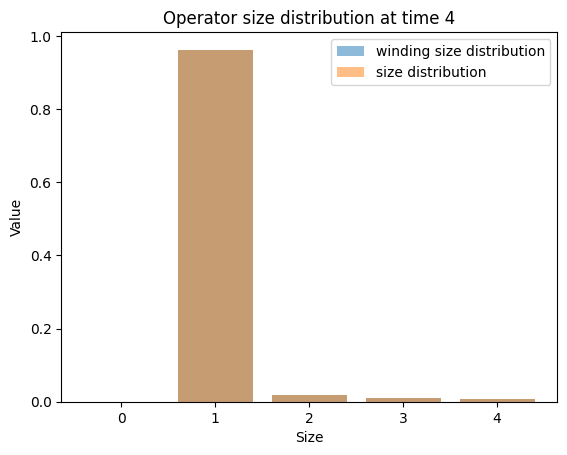

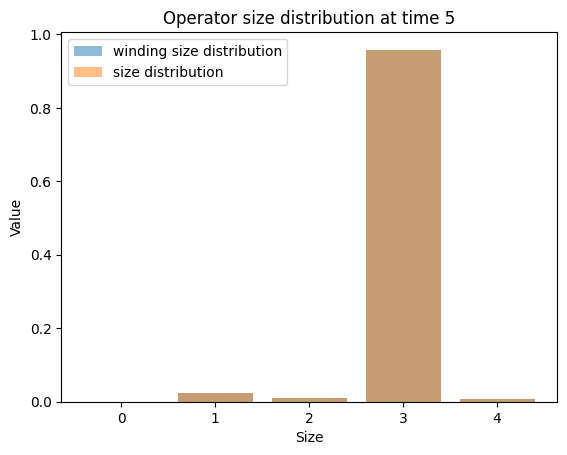

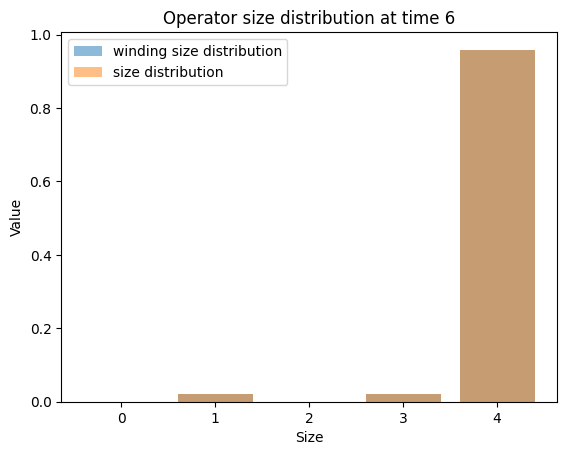

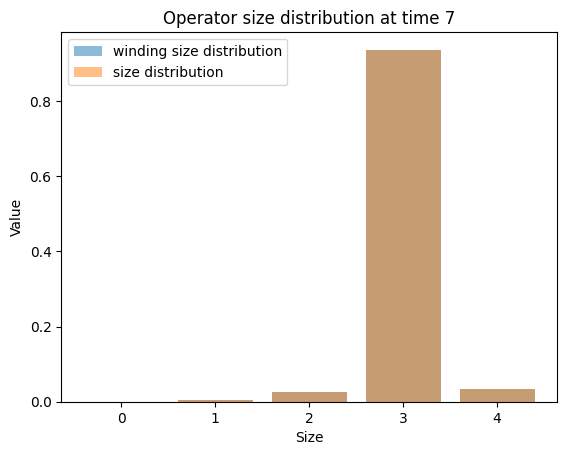

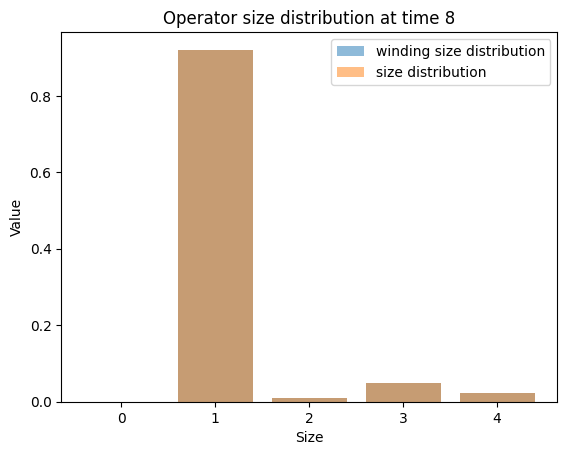

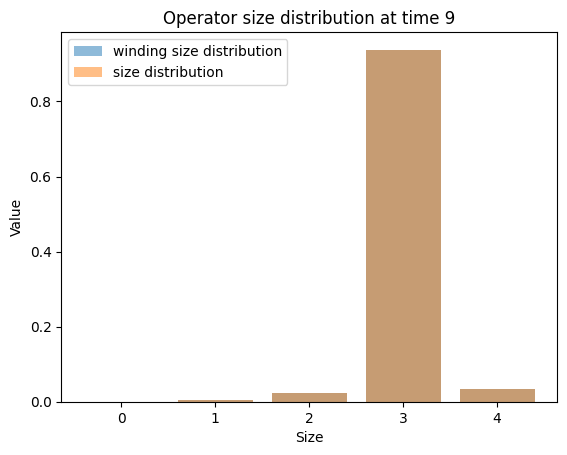

In [15]:
#Plot an histogram for each time
for t in range(time):
    plt.figure(t+1)
    plt.bar(range(N+1), q[t], alpha=0.5, label='winding size distribution')
    plt.bar(range(N+1), q_mod[t], alpha=0.5, label='size distribution')
    plt.xlabel('Size')
    plt.ylabel('Value')
    plt.title(f'Operator size distribution at time {t}')
    plt.legend()

### Plot the angles

In [50]:
# for t in range(time):
#     fig, ax = plt.subplots()
#     var=[]
#     for n in range(N+1):
#         angles = np.angle(q_i[t][n])  # This is in radians by default, range [-pi, pi]
#         angles = np.where(angles < 0, angles + 2*np.pi, angles)  # Adjust range to [0, 2pi]
#         var.append(angles)
#         ax.plot(angles, label=f'Size {n}')
#     ax.set_xlabel('Pauli string index')
#     ax.set_ylabel('Angle')
#     ax.set_title(f'Angles at time {t+1}')
#     ax.legend()
#     plt.show()

## Size winding

Ansatz: $c_{i_1,i_2,...,i_n}=e^{i(a+nb)}\left|c_{i_1,i_2,...,i_n}\right|$


Hay que sacar un promedio de los coeficientes (fases) para cada size y ver si se relaciona con el tamaño (de la fase?).

Promedio para cada arg(c_P) y mirar si ese número.....

Histograma de medias frente a P: ver si fases promediadas se acumulan en torno a un valor para P fijo. Plot de promedio (rayita) vs longitud -> nube??



Getting the angles

In [49]:
#We are going to get the angles of each coefficient
angle=[] #angle[time][size]
for t in range(time):
    angles_t=[]
    for n in range(N+1):
        angles_tt=[]
        for i in range(len(q_i[t][n])):
            if np.abs(q_i[t][n][i])>1e-2:
                angles = np.angle(q_i[t][n][i])  # This is in radians by default, range [-pi, pi]
                angles = np.where(angles < 0, angles + 2*np.pi, angles) # Adjust range to [0, 2pi]
                angles=float(angles)
                angles_tt.append(angles)
        angles_t.append(angles_tt)
    angle.append(angles_t)

print(q_i[0][1])
print(angle[4][3])

[0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (0.7071067811865475+0j), 0j, 0.7071067811865475j, 0j, 0j, 0j]
[5.432261624220449, 2.290668970630657, 3.8620741283559505, 0.7204814747661572, 3.861836954293644, 3.861836954293644, 0.7202443007038491, 0.7202443007038507, 5.432944297841118, 2.291351644251326, 0.7203245519314093, 3.8619170710632384]


Now we can promediate the angles

In [70]:
print(q_i[4][1])
print(angle[4][1])

[(-8.816437145929418e-18+1.065638924594944e-17j), (1.0963047929286108e-17+1.4642952129326224e-17j), (-6.938893903907228e-18+2.117898591464659e-17j), (0.7071067811865477+1.479628147099456e-17j), (-3.9217685098752095e-17+0j), (-6.938893903907228e-18-3.831751154878517e-18j), (1.3799640750150494e-18+9.966407208441946e-18j), (-1.1193041941788635e-17+3.756568870874267e-17j), (1.3877787807814457e-17-3.3794030233942135e-17j), (2.3766047958592284e-17+2.330605993358729e-17j), (-2.1619437175235598e-17+3.066586833366748e-17j), (2.7755575615628914e-17-3.8336782577574114e-17j)]
[2.092510192897023e-17]


In [50]:
for n in range(N+1):
    # n=1
    print('--------------------')
    print(f'Size {n}')
    q_i_temp=[]
    for j in range(len(q_i[4][n])):
        if np.abs(q_i[4][n][j])>1e-3:
            q_i_temp.append(q_i[4][n][j])
            
            
    for i in range(len(q_i_temp)):
        print(f'Coefficient: {q_i_temp[i]}, Angle: {angle[4][n][i]}')



--------------------
Size 0
--------------------
Size 1
--------------------
Size 2
Coefficient: (0.025224814972605772+0.022138362085104665j), Angle: 0.7203245083468127
Coefficient: (-0.0037286973868328284-0.0032724621744553532j), Angle: 0.7203244819607569


IndexError: list index out of range

### Plot the angles

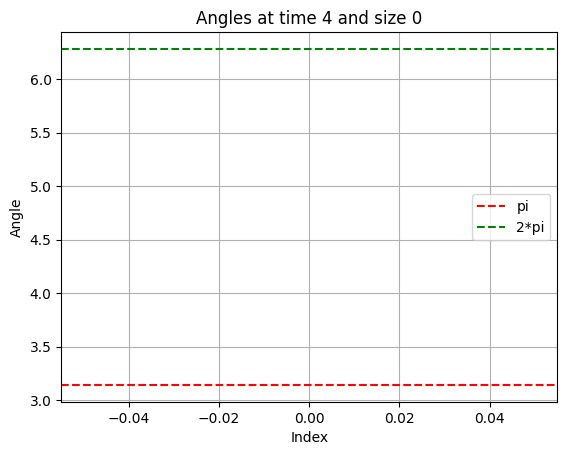

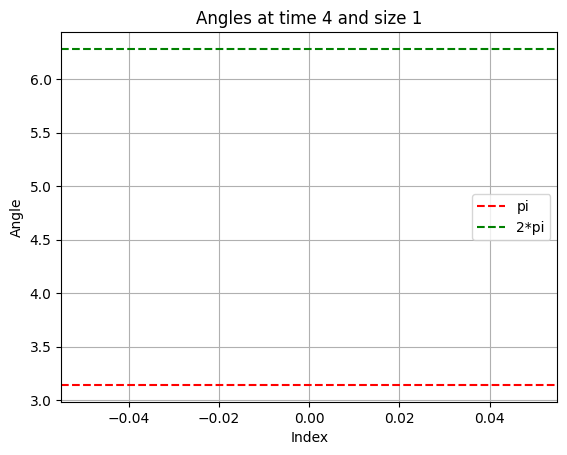

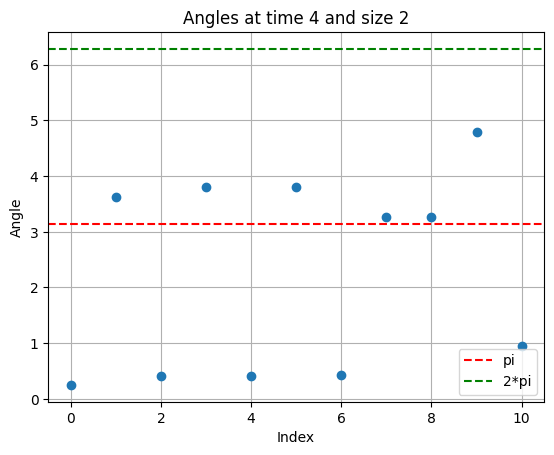

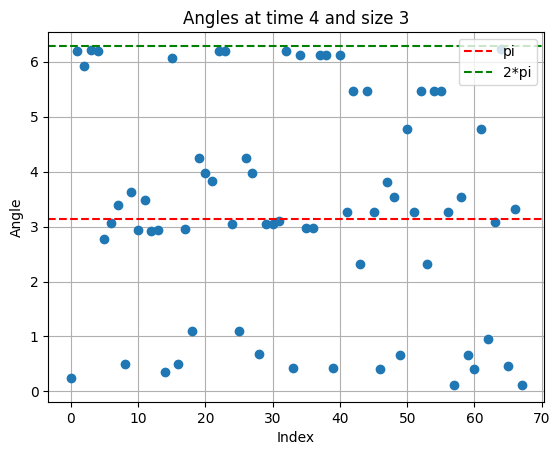

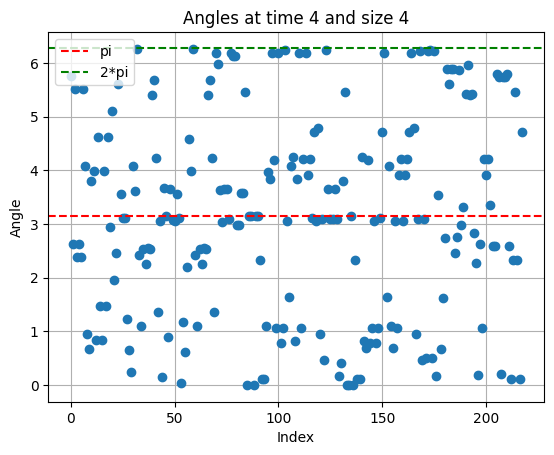

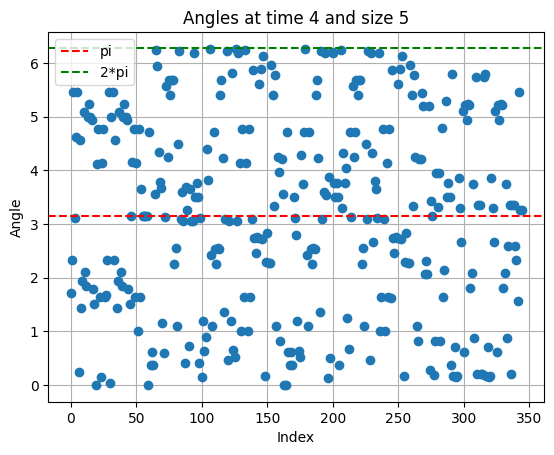

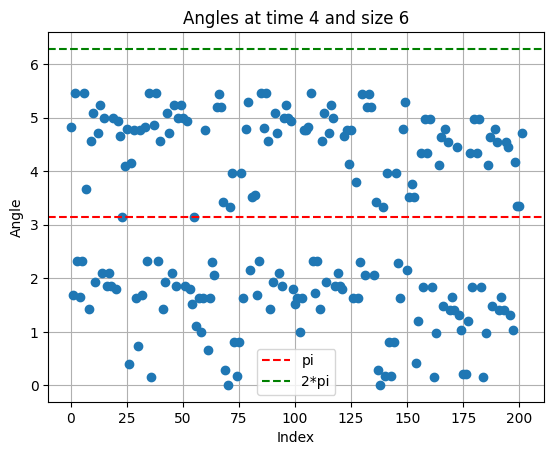

In [24]:
# Plot an arbitrary angle just to see what happens
for n in range(N+1):
    plt.figure(n+1)
    angles_t = angle[5][n]
    plt.plot(angles_t, 'o') 
    plt.axhline(y=np.pi, color='r', linestyle='--',label='pi')
    plt.axhline(y=2*np.pi, color='g', linestyle='--',label='2*pi')
    plt.xlabel('Index')
    plt.ylabel('Angle')
    plt.title(f'Angles at time 4 and size {n}')
    plt.legend()
    plt.grid(True)
    plt.show()
# plt.figure(1)
# angles_t = angle[4][3]
# plt.plot(angles_t, 'o') 
# plt.axhline(y=np.pi, color='r', linestyle='--',label='pi')
# plt.axhline(y=2*np.pi, color='g', linestyle='--',label='2*pi')
# plt.xlabel('Index')
# plt.ylabel('Angle')
# plt.title('Angles at time 5 and size 3')
# plt.legend()
# plt.grid(True)
# plt.show()


# Promediate

Now we are going to promediate the angles for each length. Since they should be the same angles, this makes sense. Then we can plot the promediates for each size and see if there is any time that alings the angles.  

In [46]:
def promediate_angles(angle_list, paso):
    if len(angle_list) <= paso:
        return [sum(angle_list) / len(angle_list)] if angle_list else []
    else: 
        variable = 0
        average = []
        while variable < len(angle_list) - paso:
            l = sum(angle_list[variable:(variable + paso)]) / paso
            variable += paso
            average.append(l)
        
        # Handling remaining elements
        if variable < len(angle_list):
            remaining_average = sum(angle_list[variable:]) / len(angle_list[variable:])
            average.append(remaining_average)
        
        return average

In [51]:
angles_promediate = []

for t in range(time):
    angles_t_prom = []
    for n in range(N+1):
        angles_t = angle[t][n]
        average = promediate_angles(angles_t, 5)
        angles_t_prom.append(average)
    angles_promediate.append(angles_t_prom)


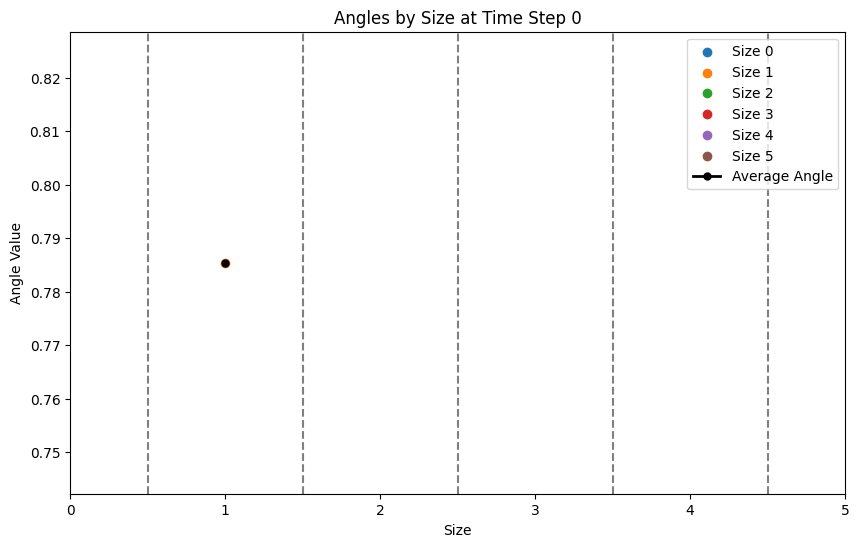

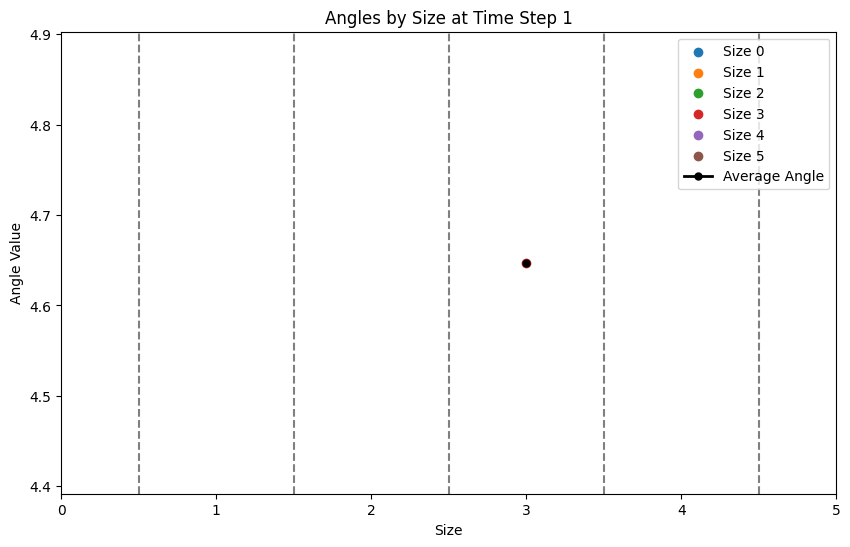

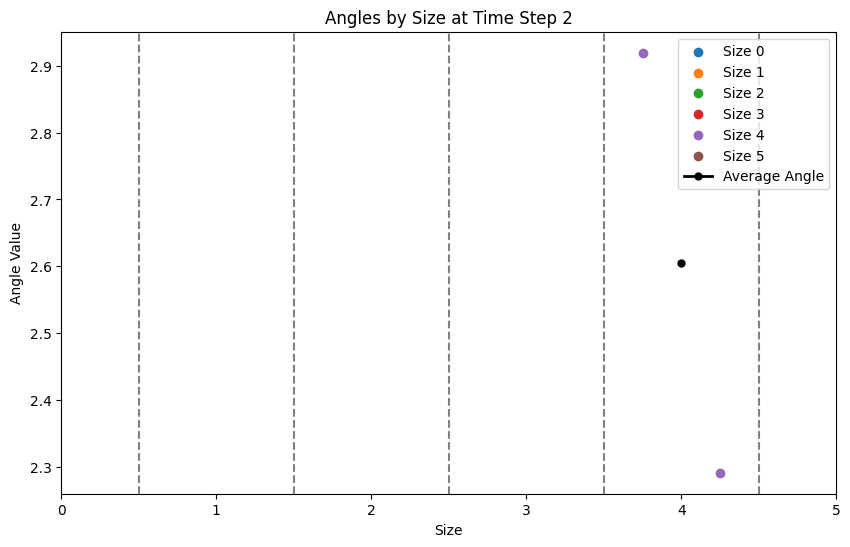

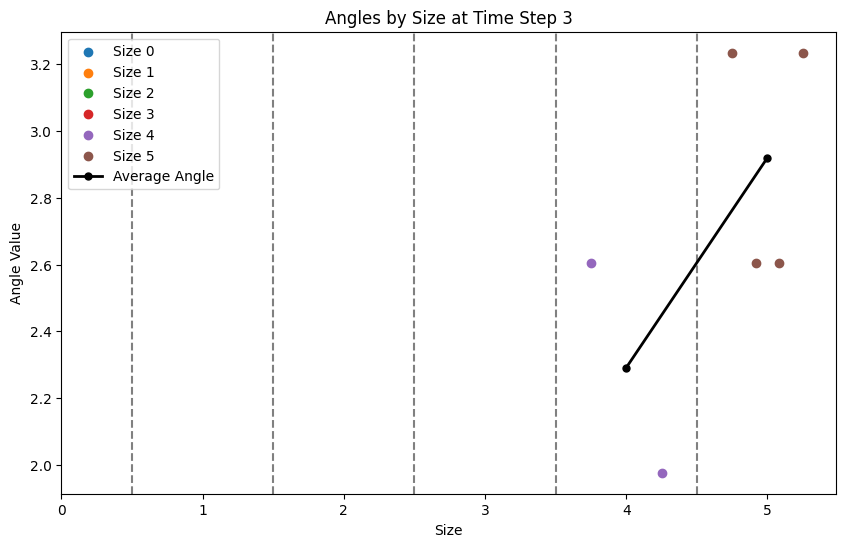

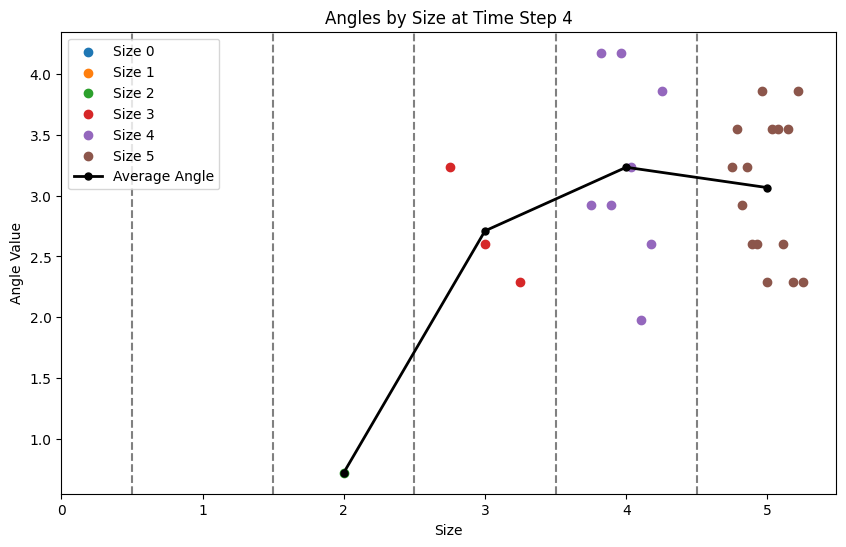

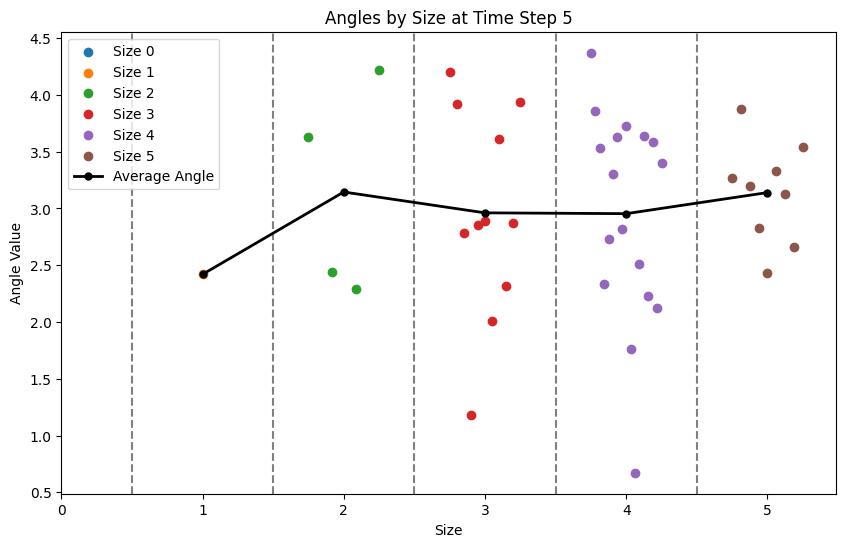

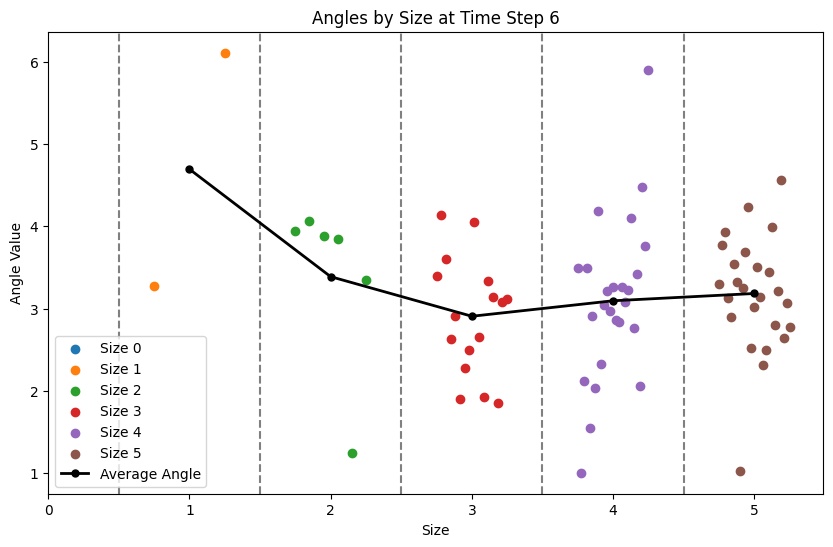

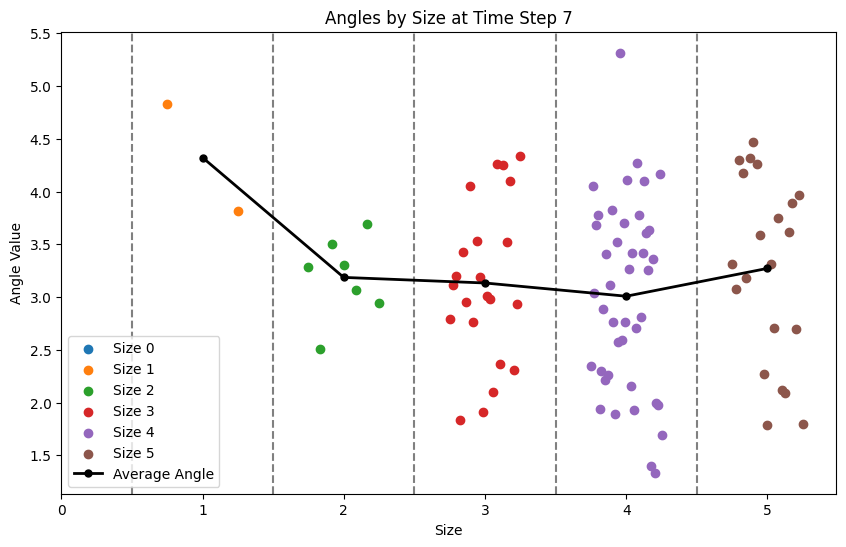

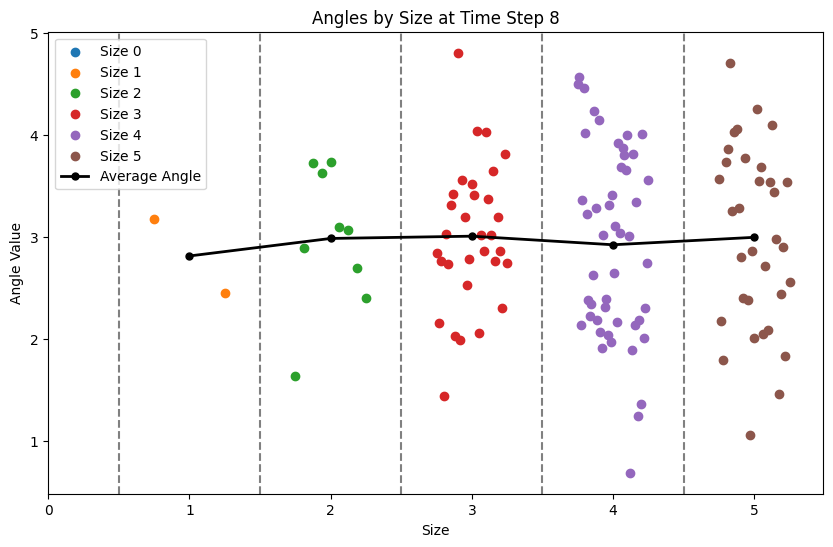

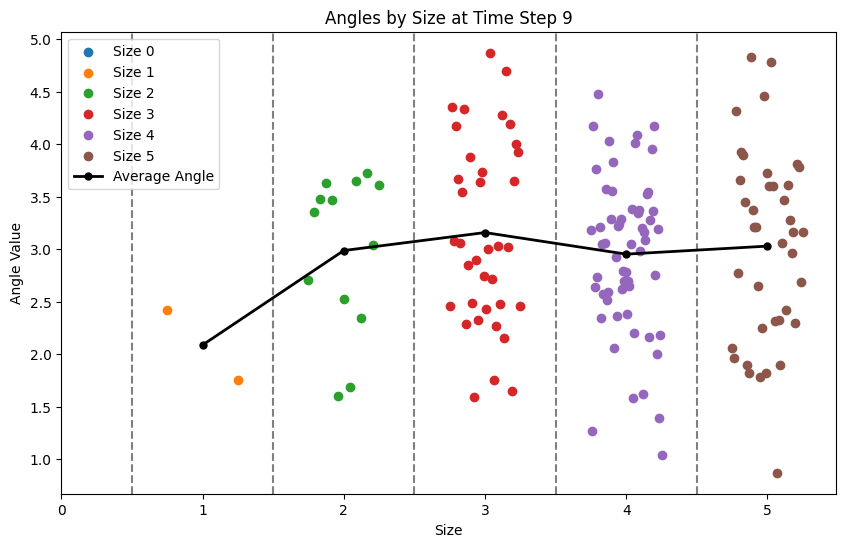

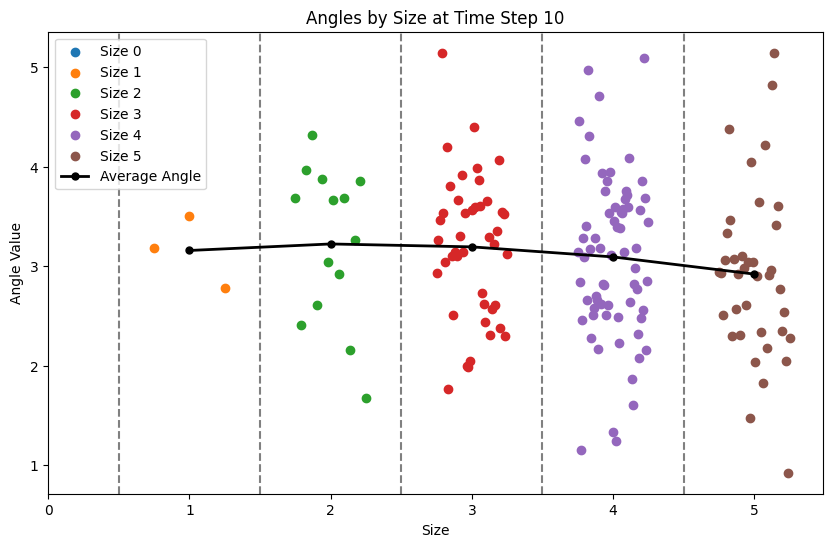

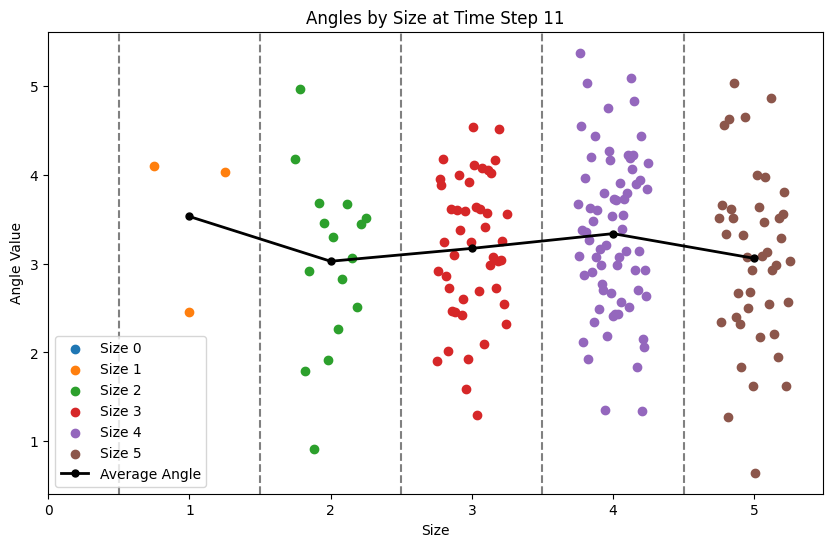

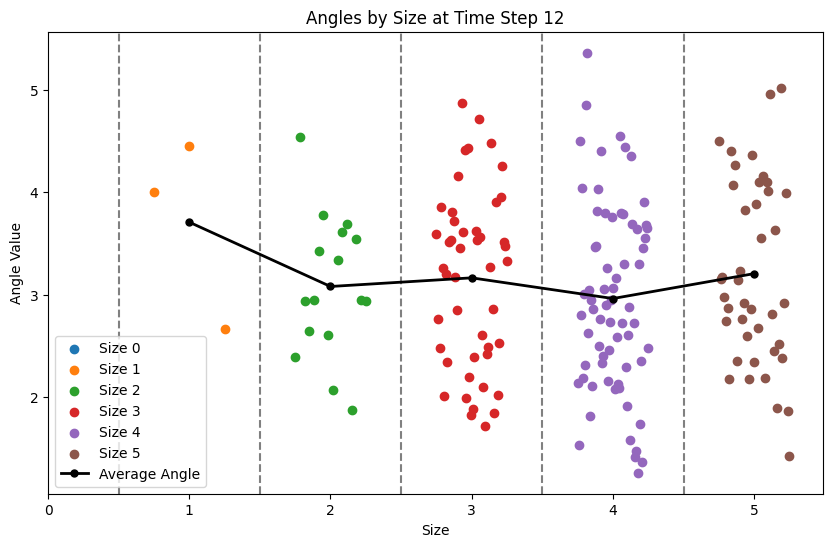

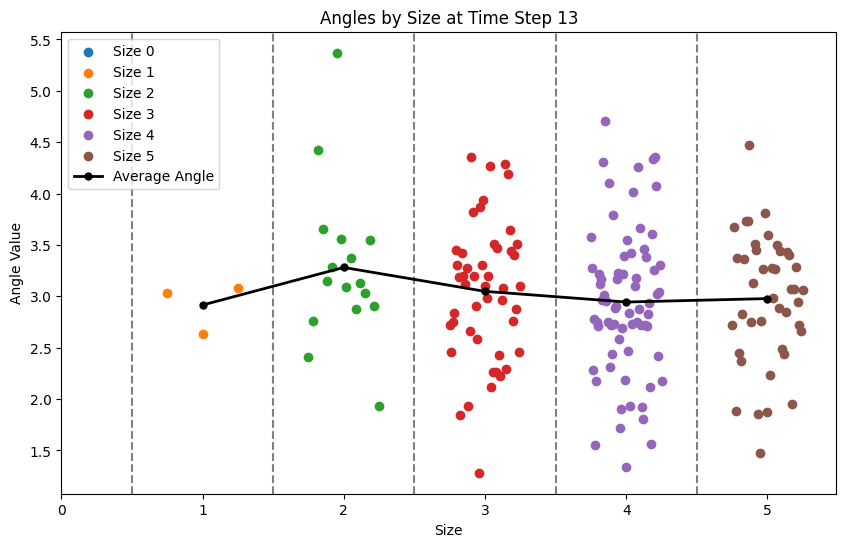

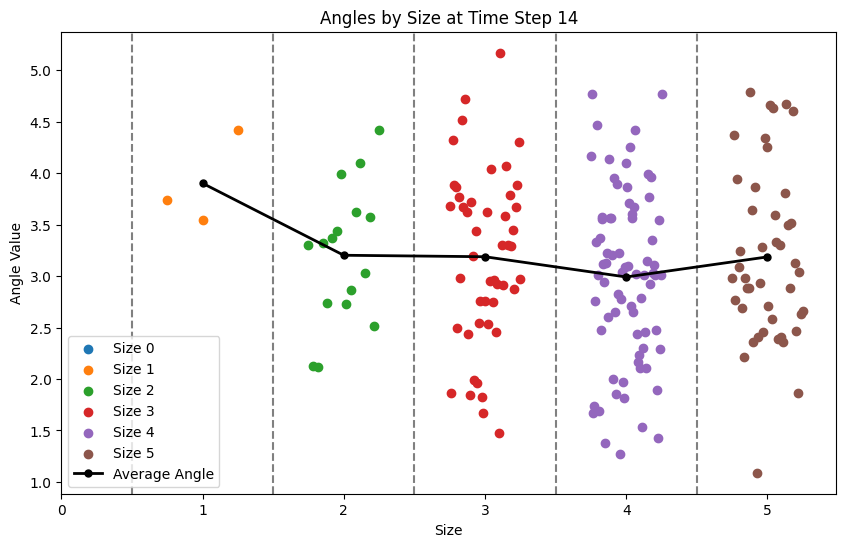

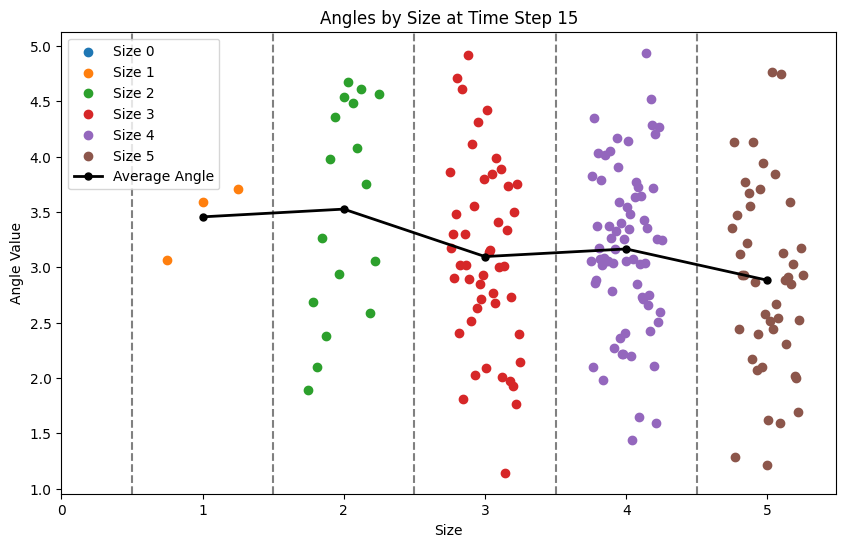

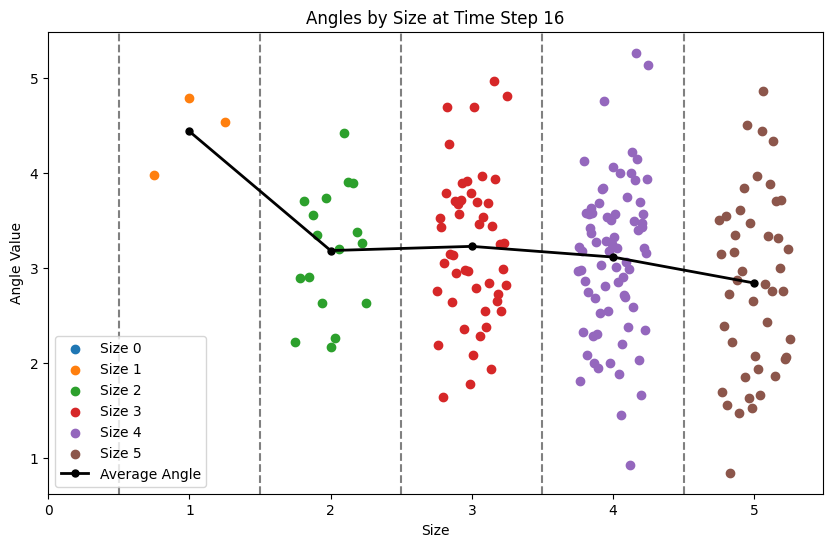

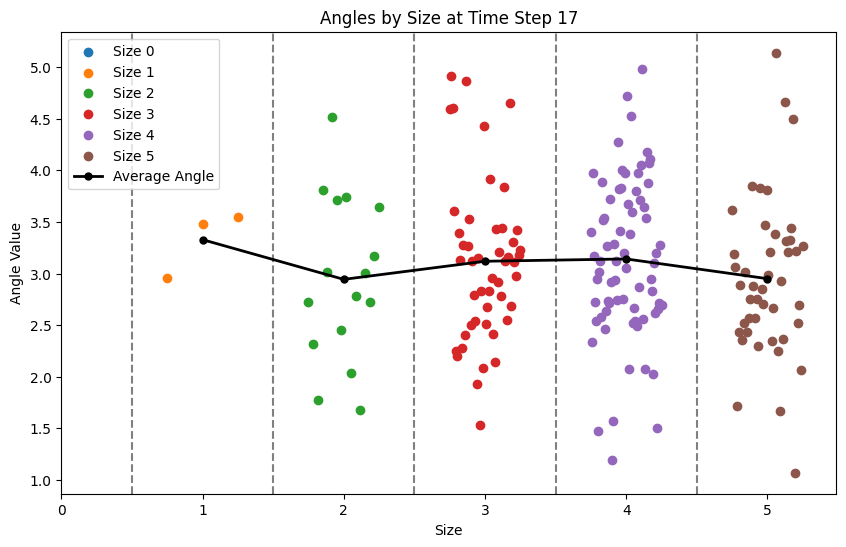

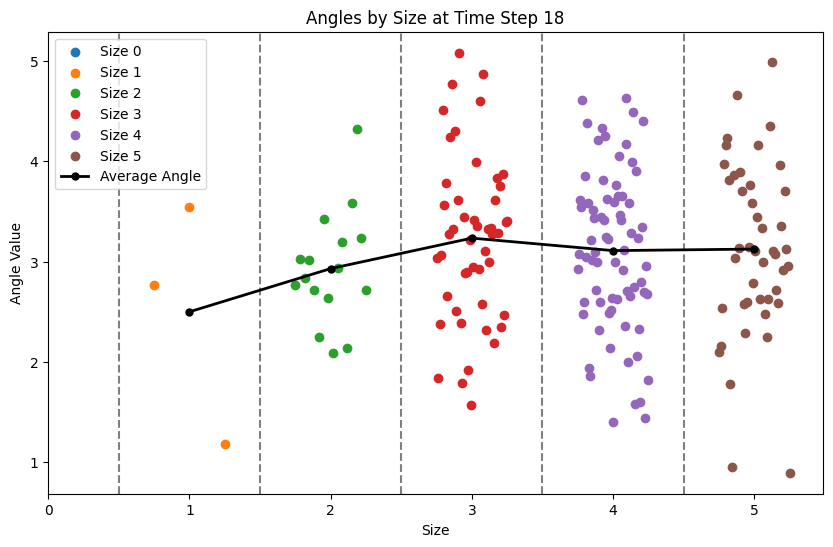

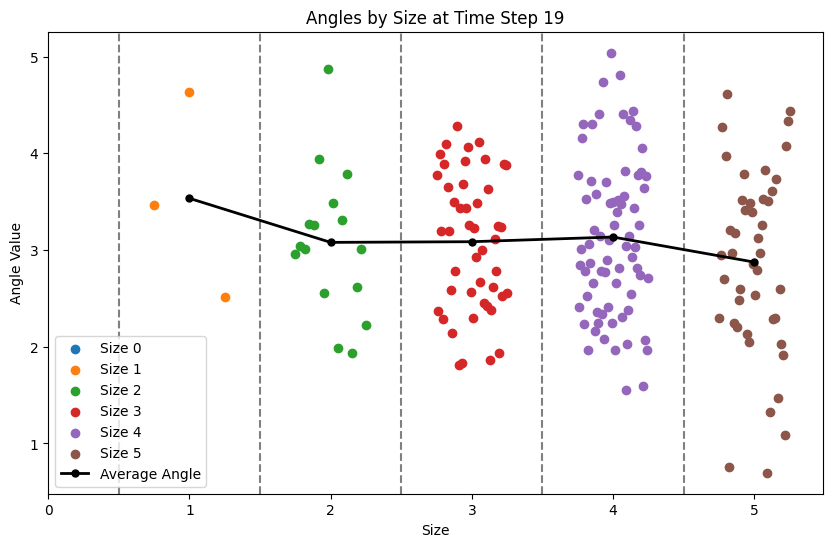

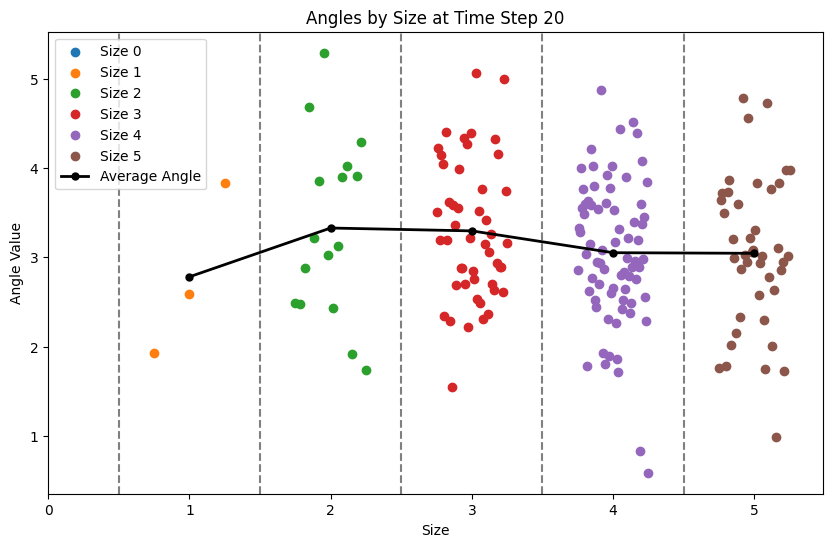

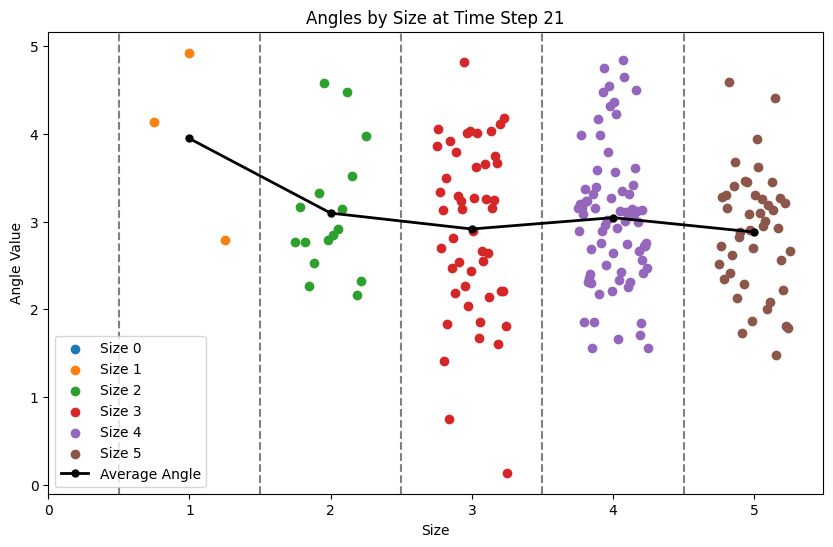

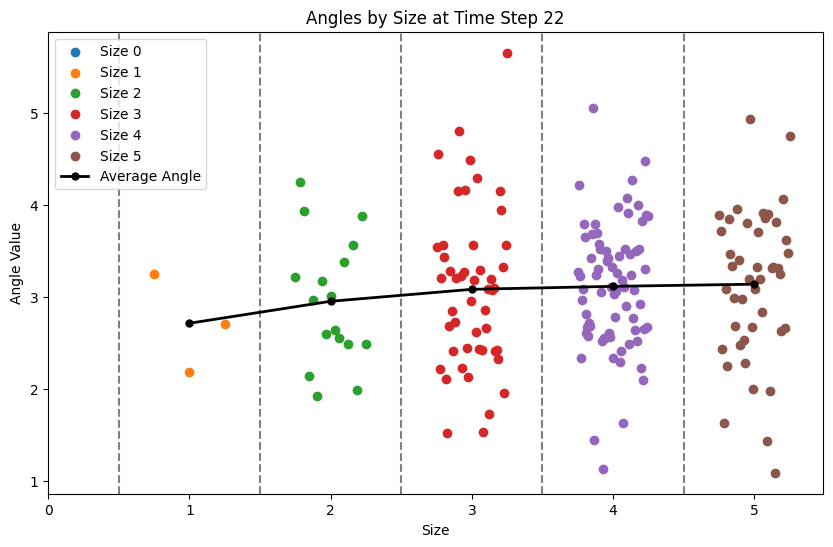

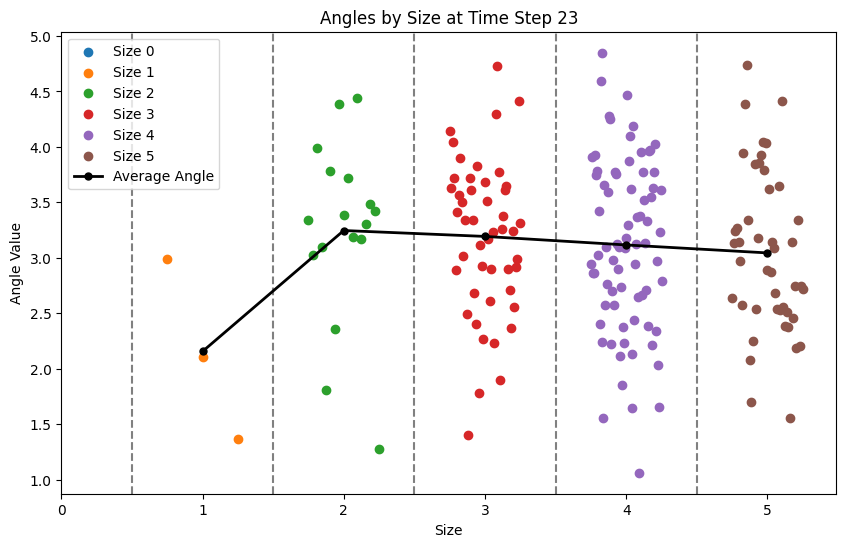

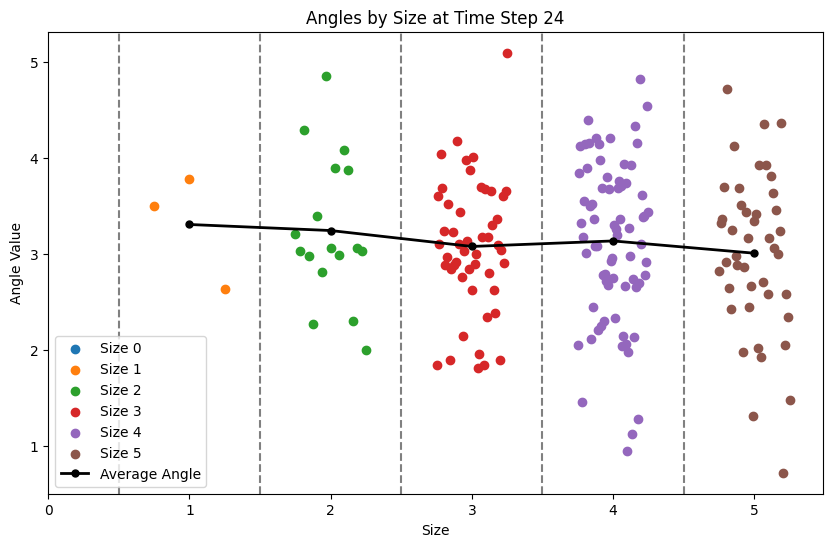

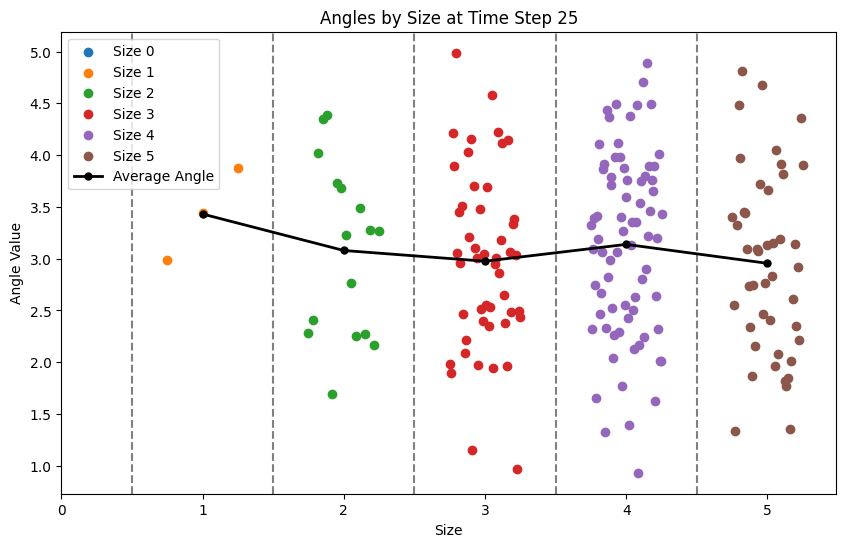

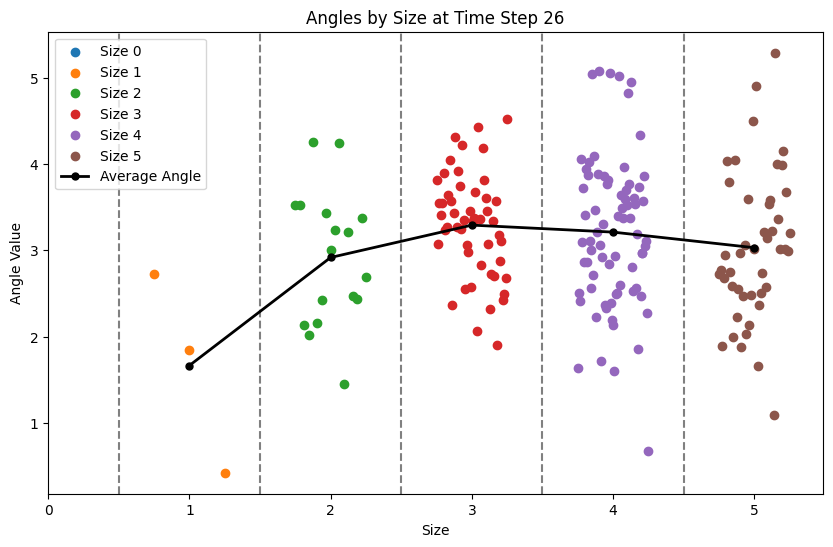

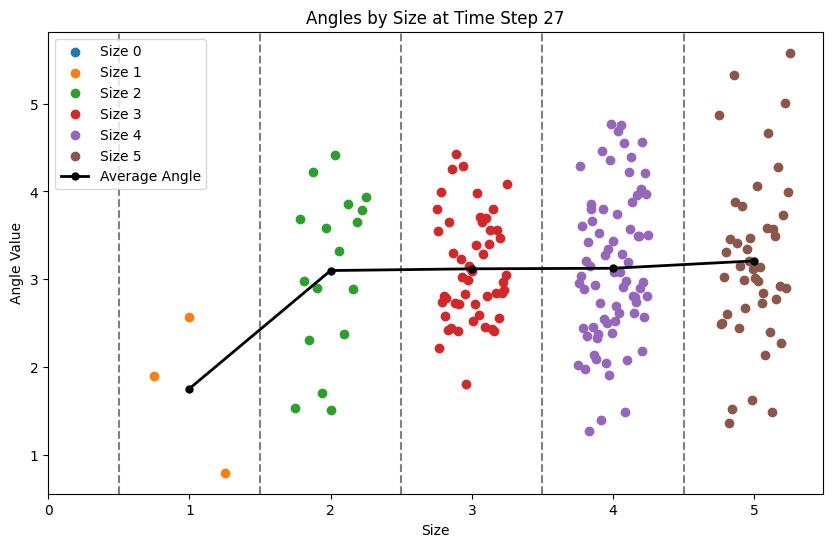

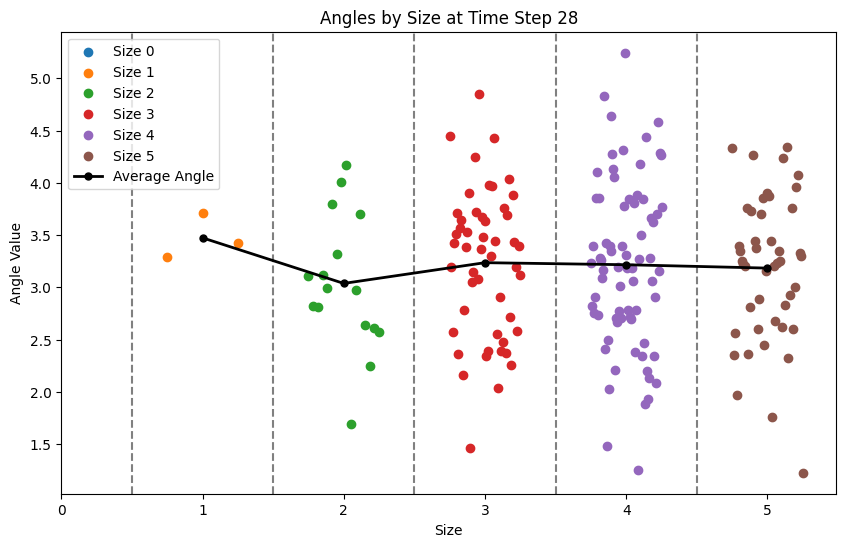

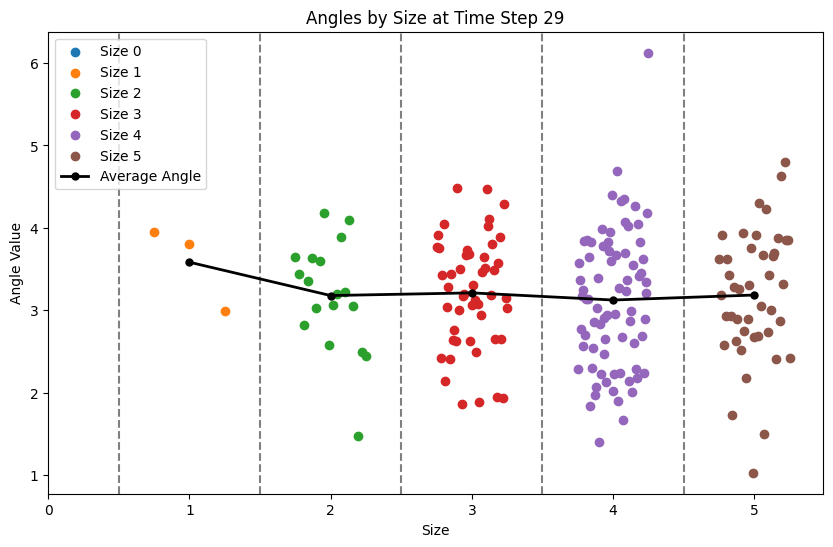

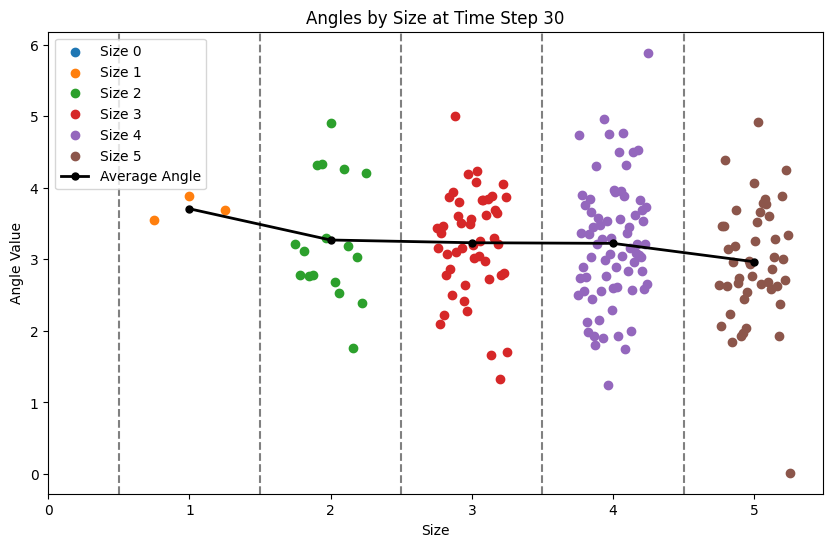

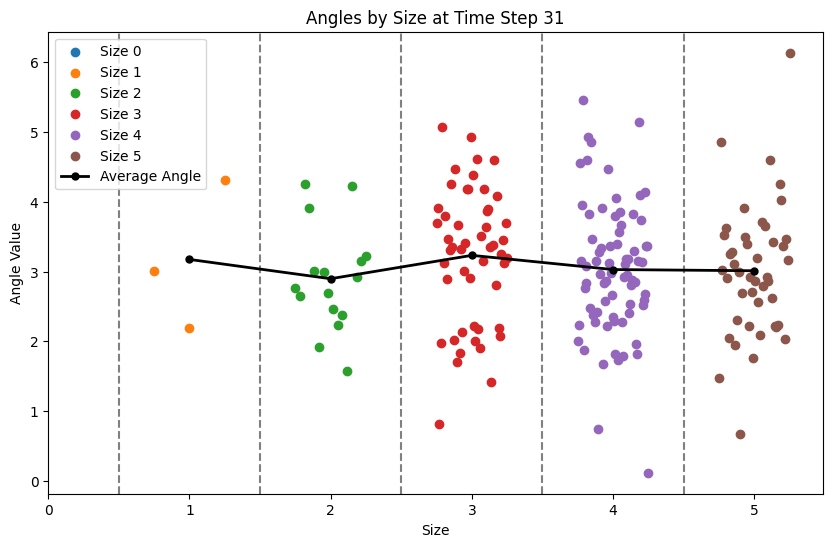

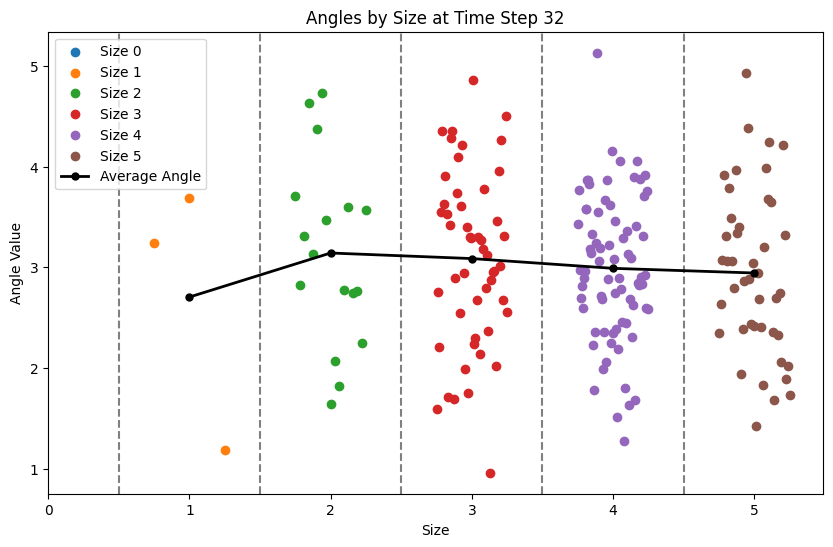

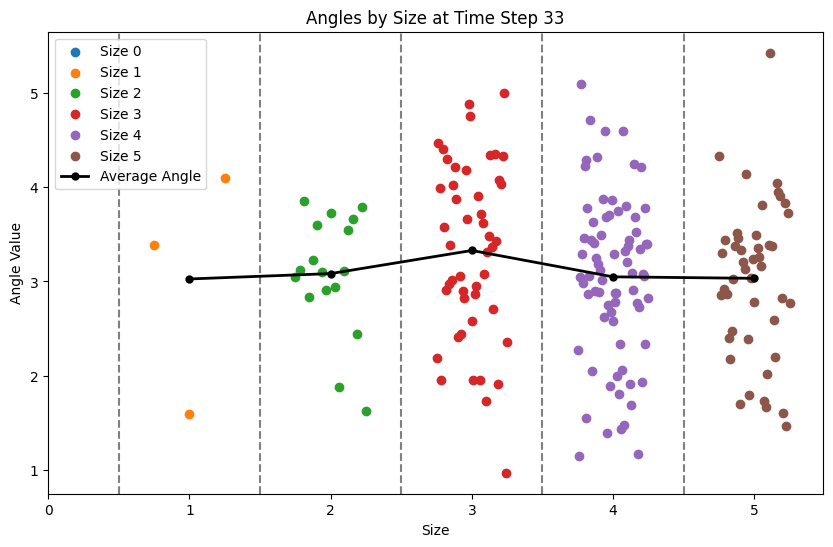

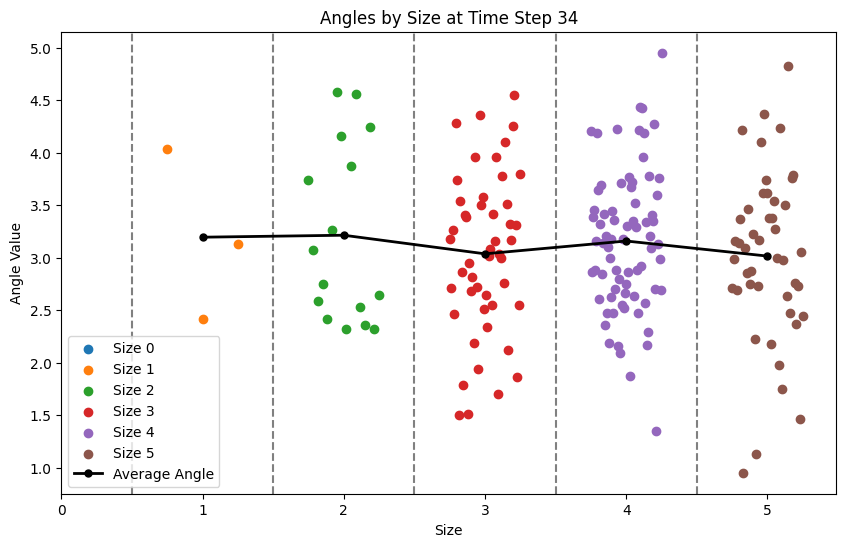

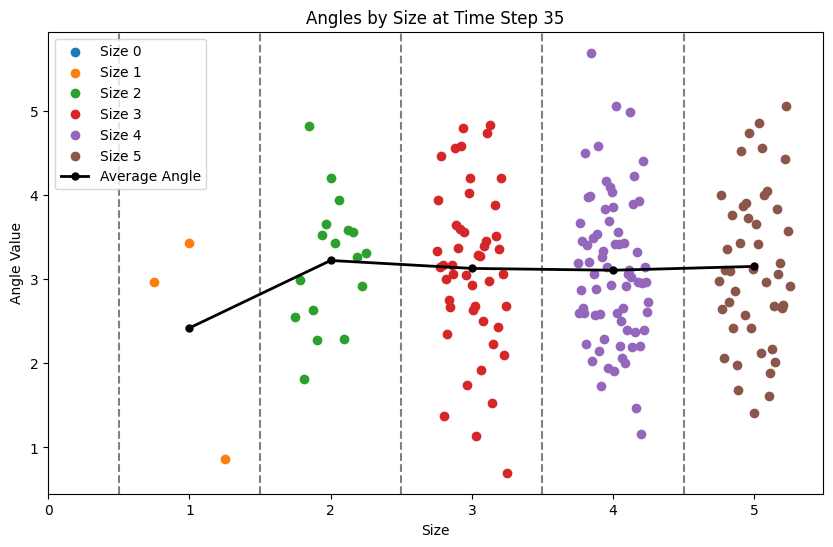

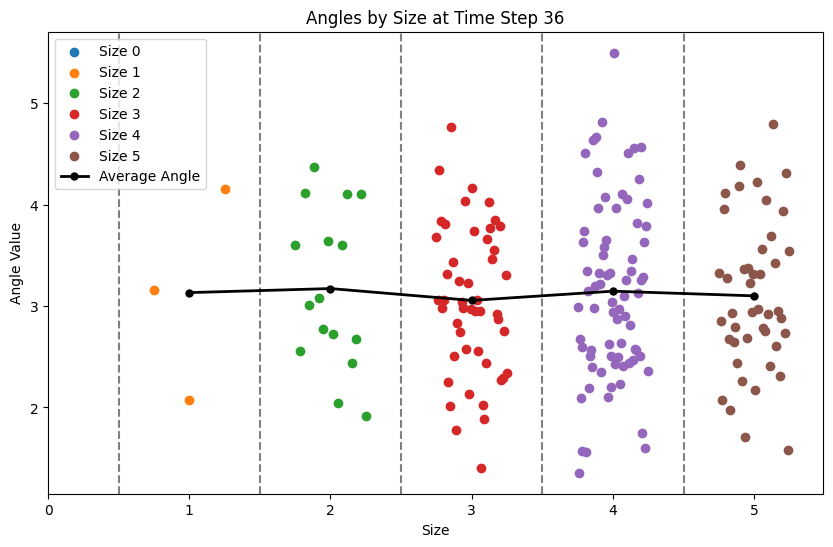

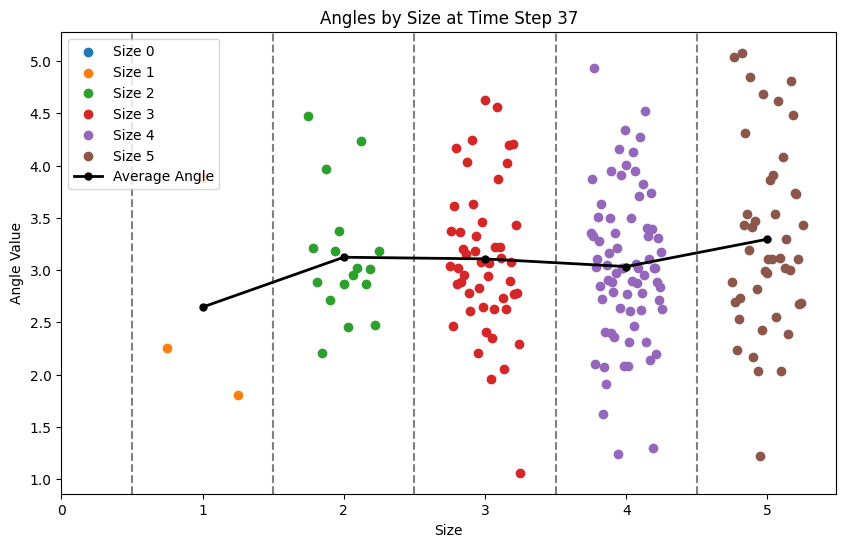

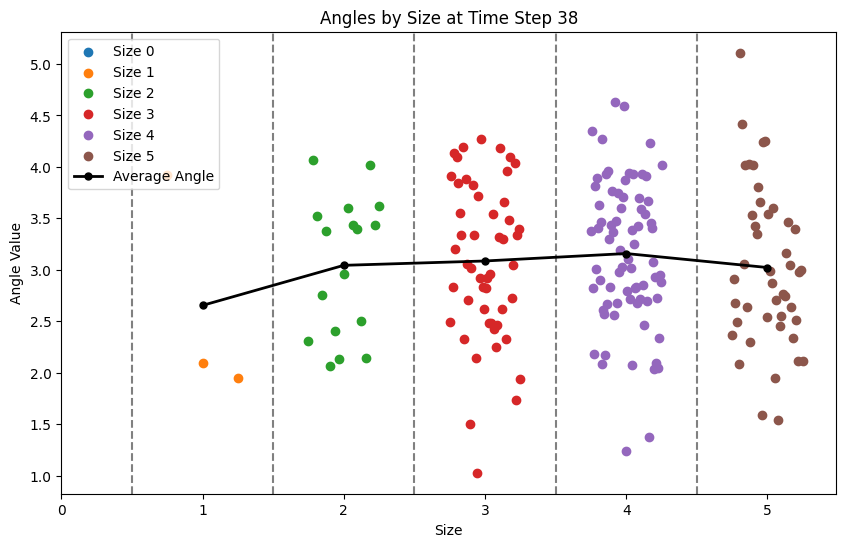

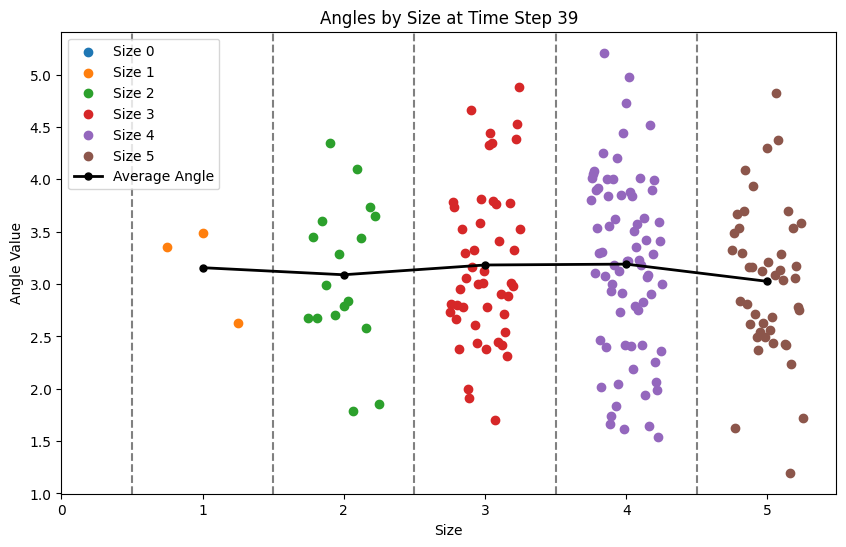

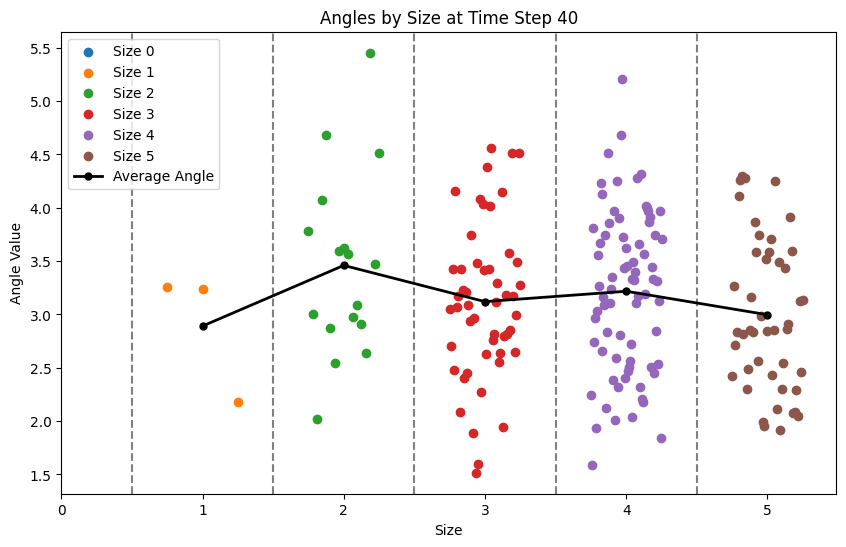

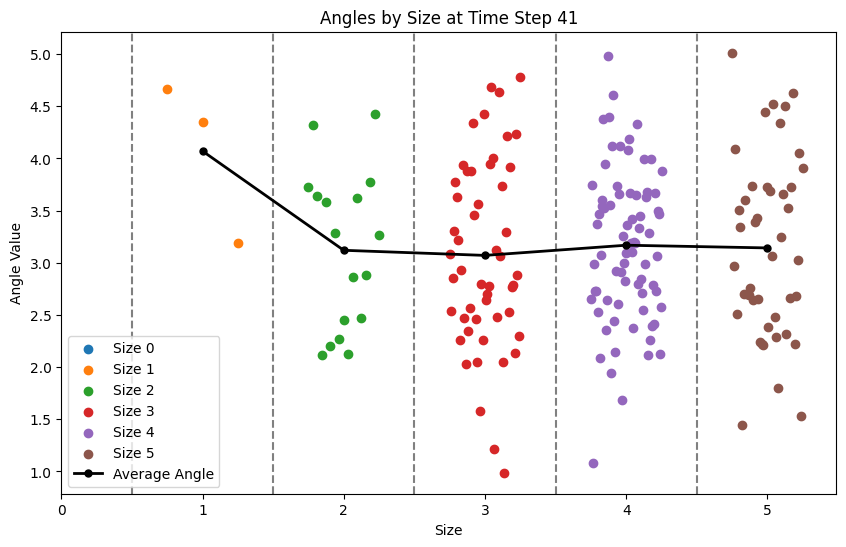

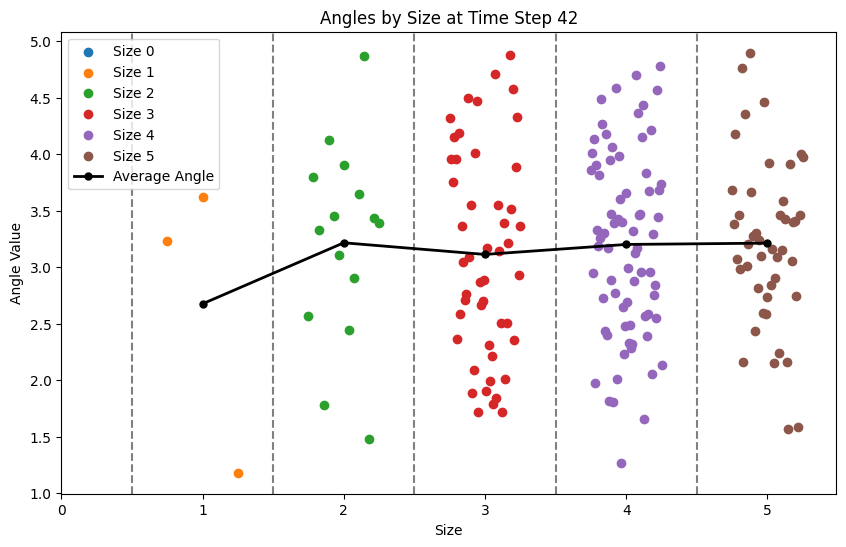

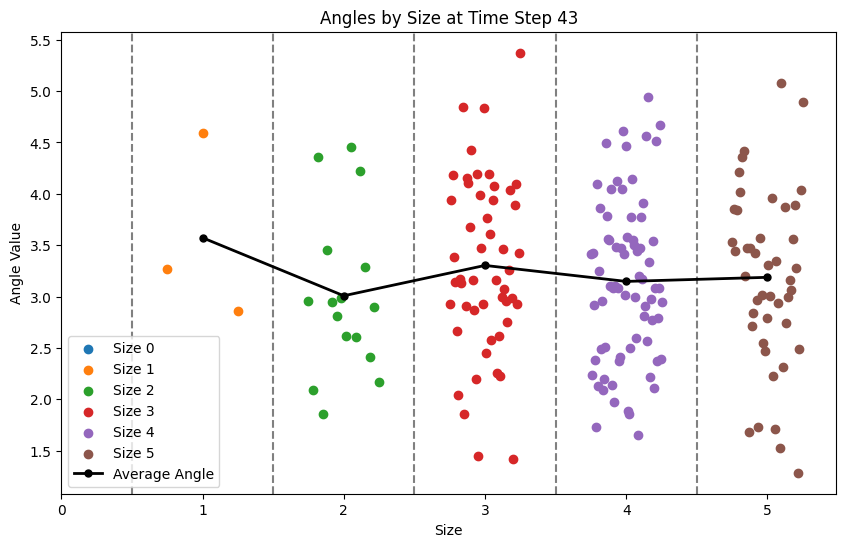

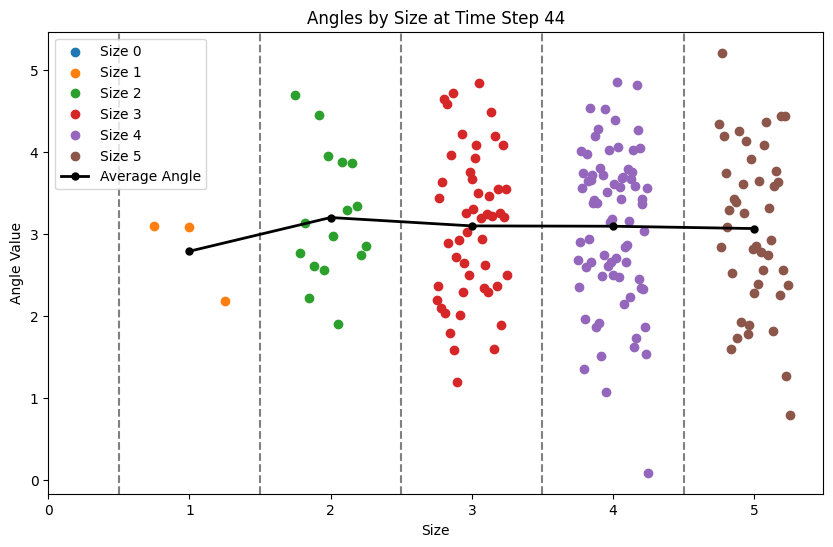

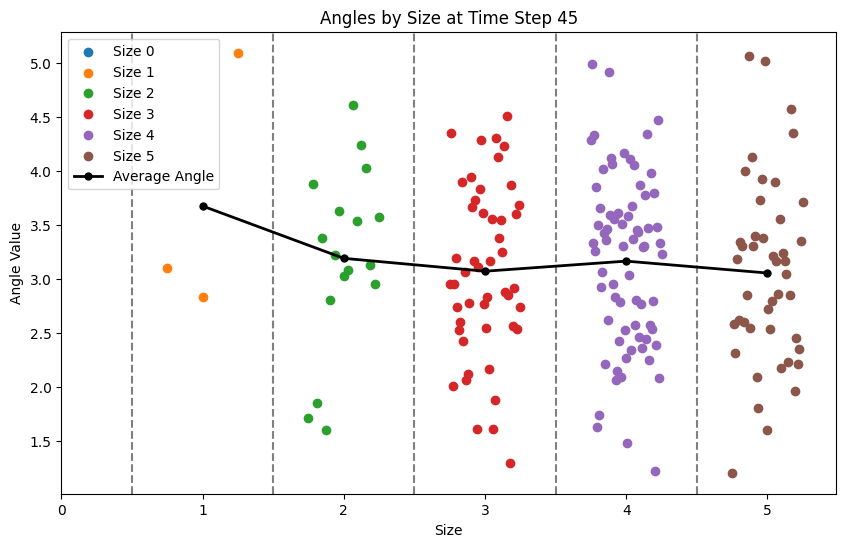

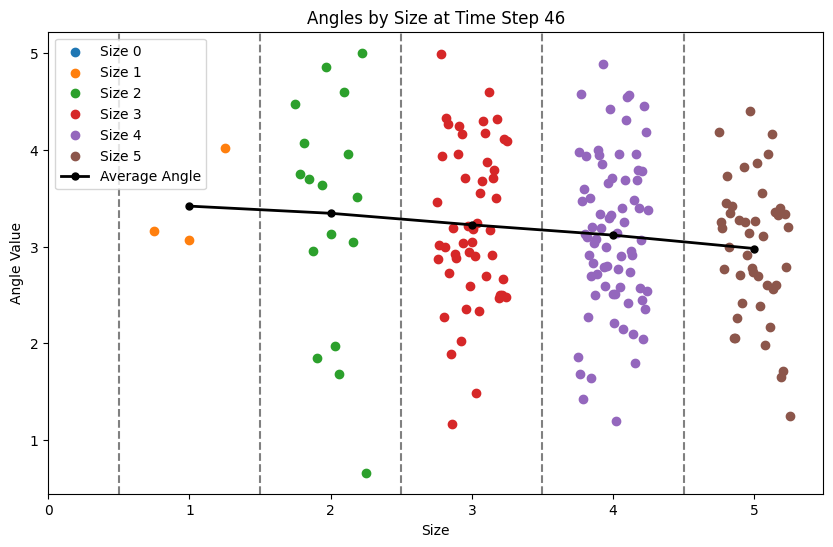

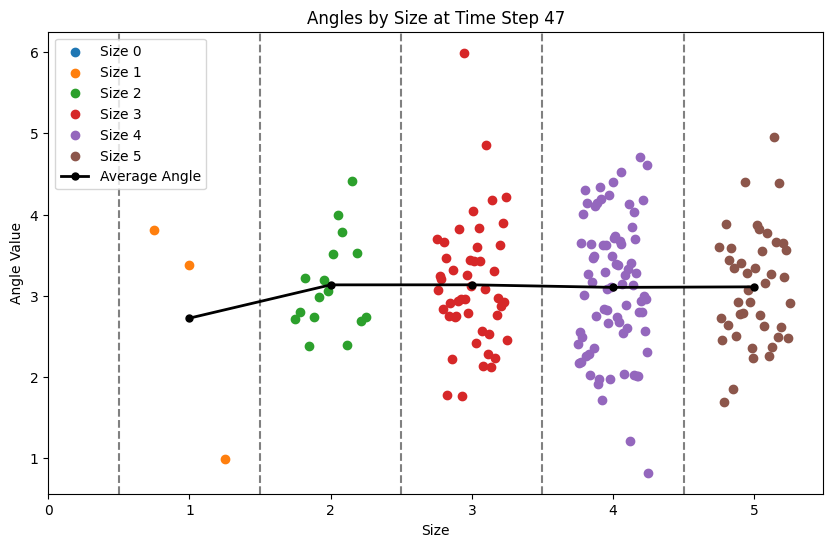

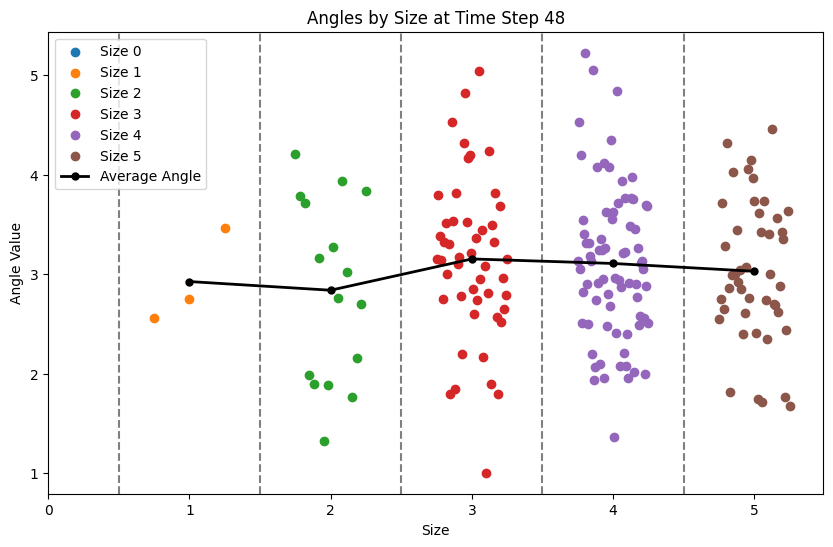

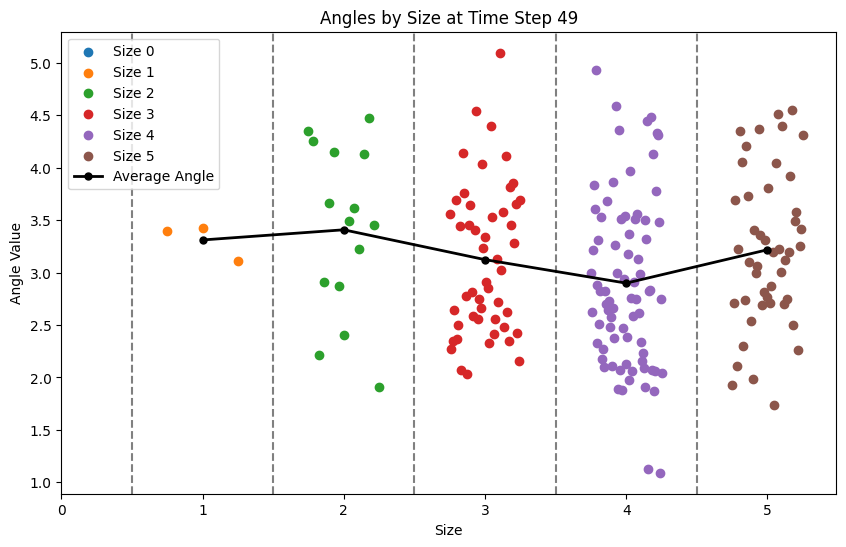

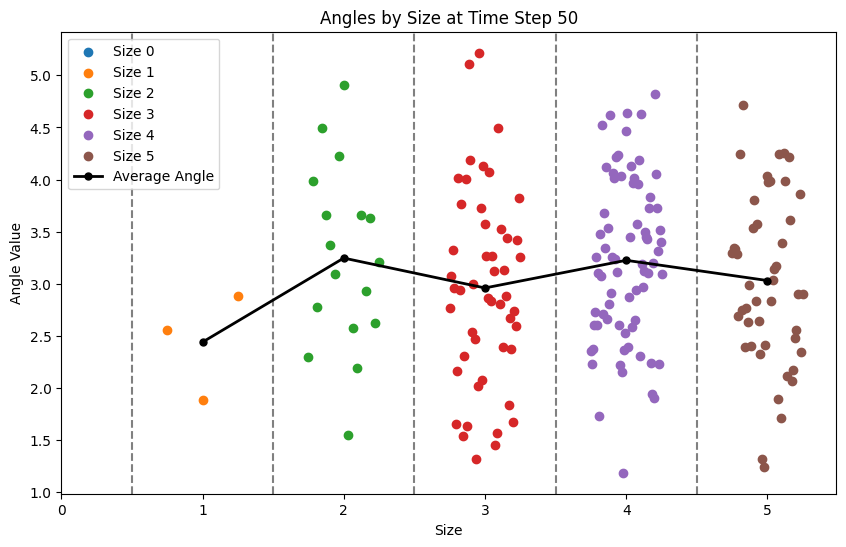

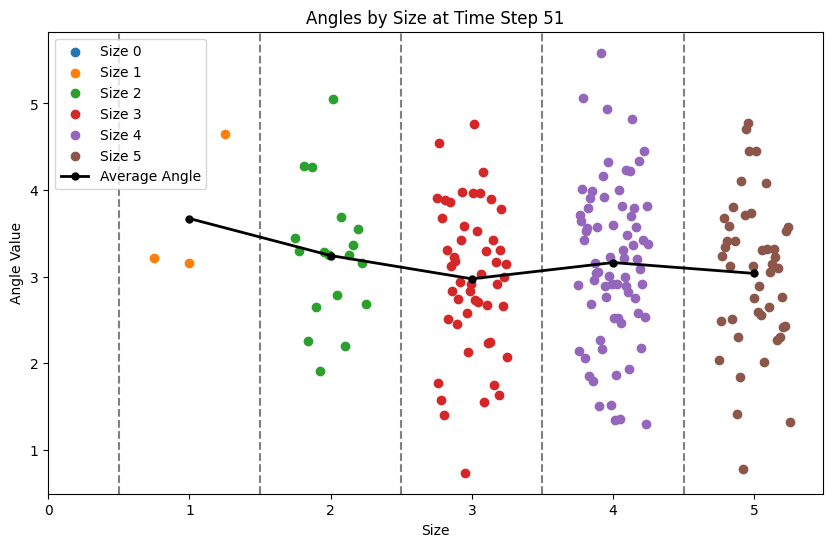

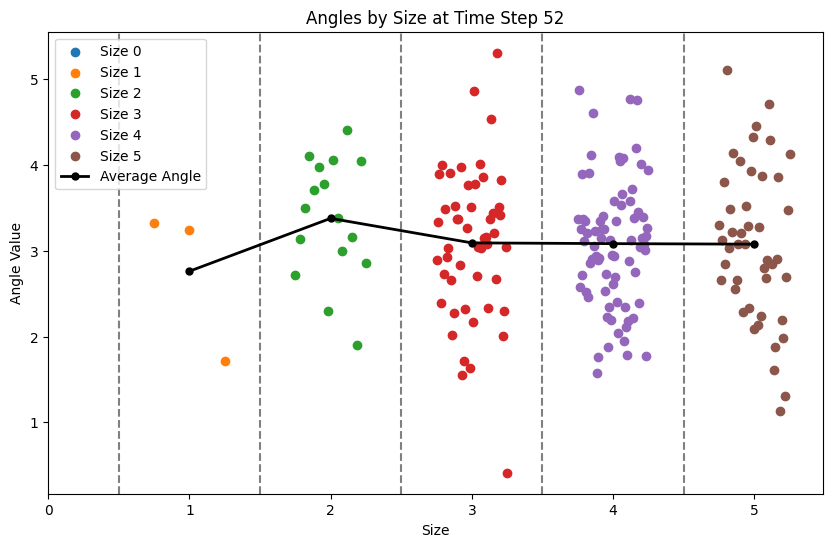

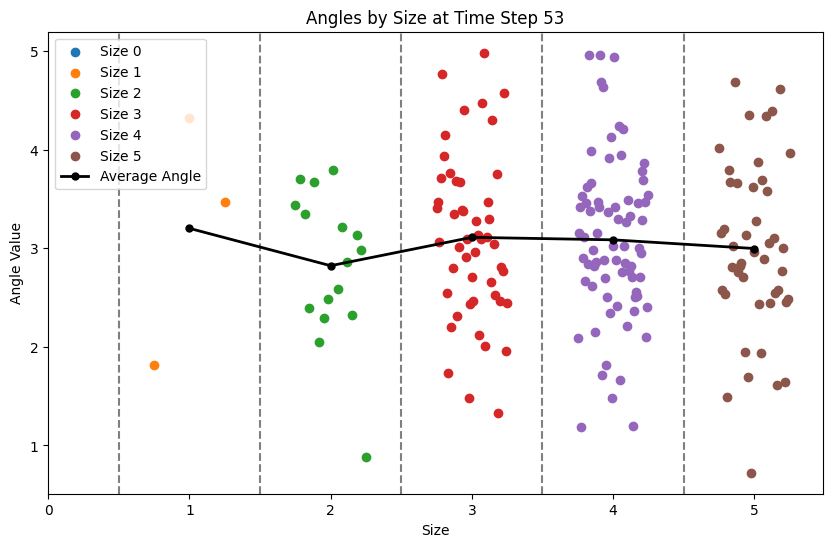

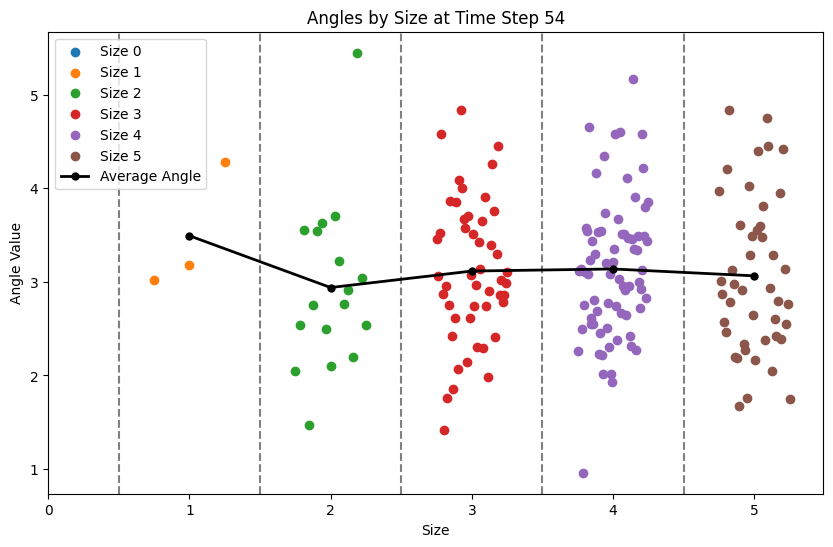

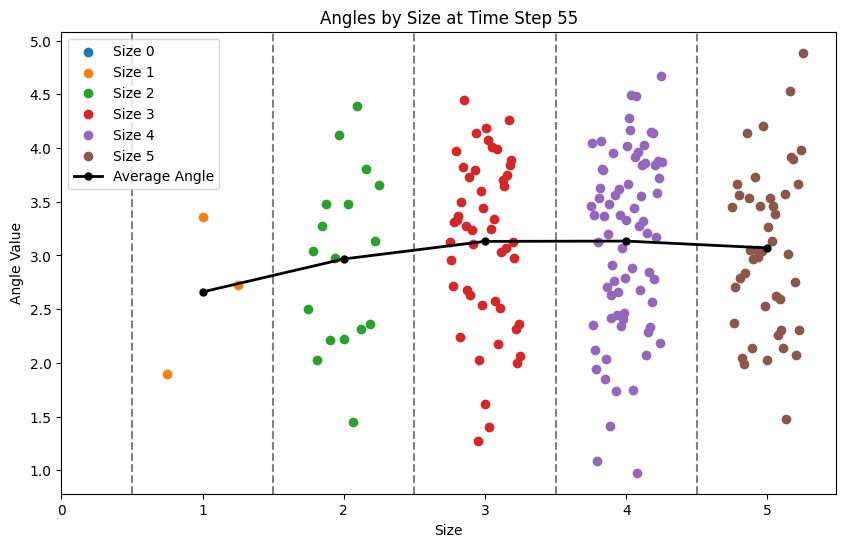

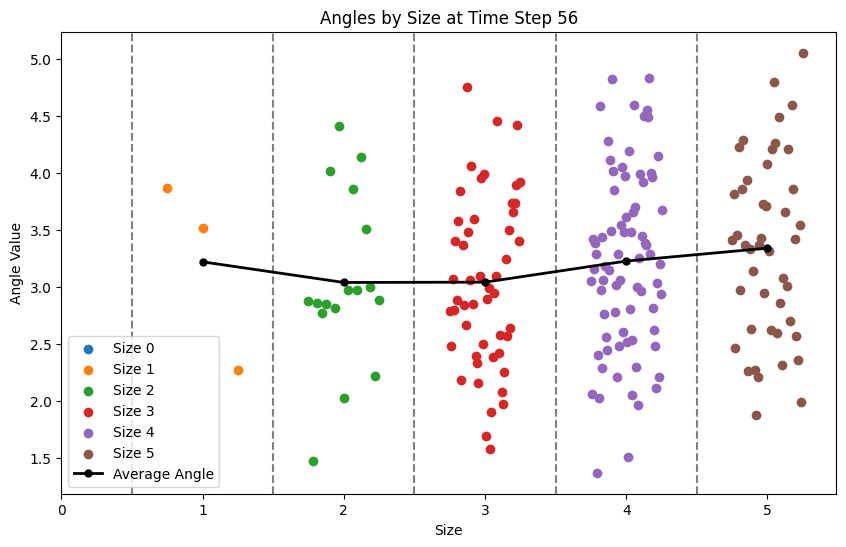

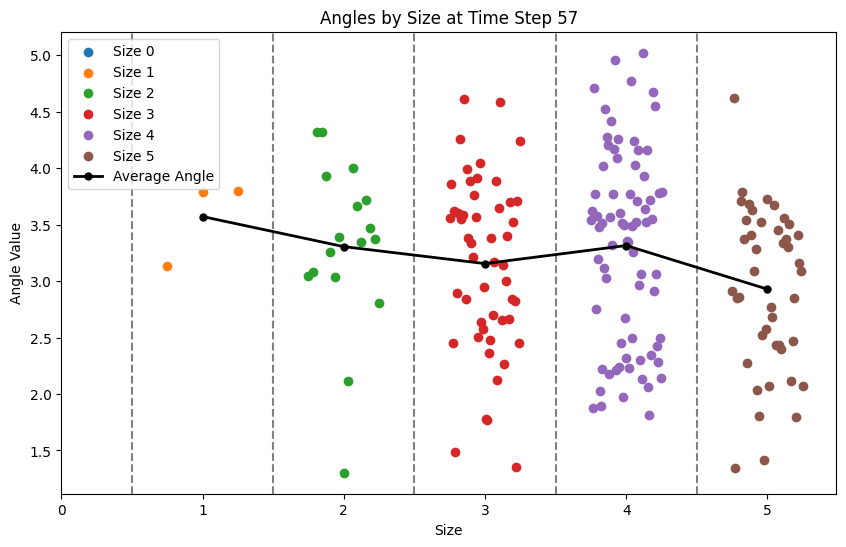

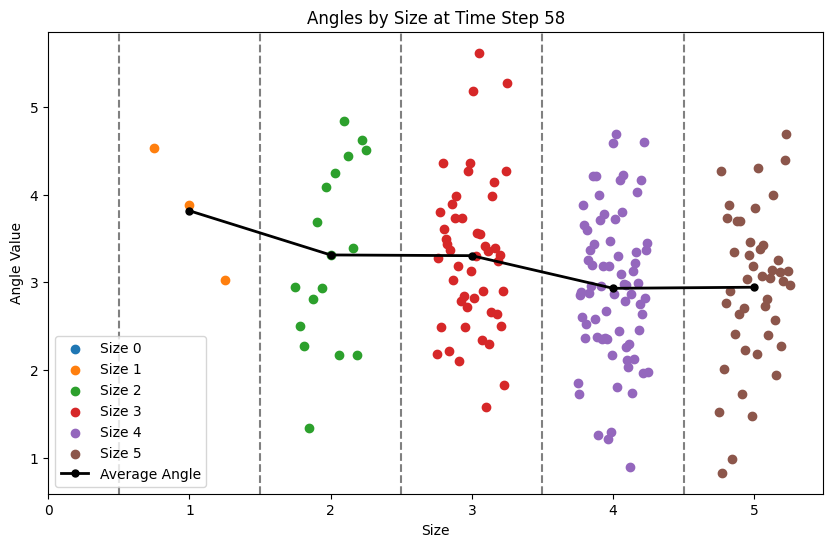

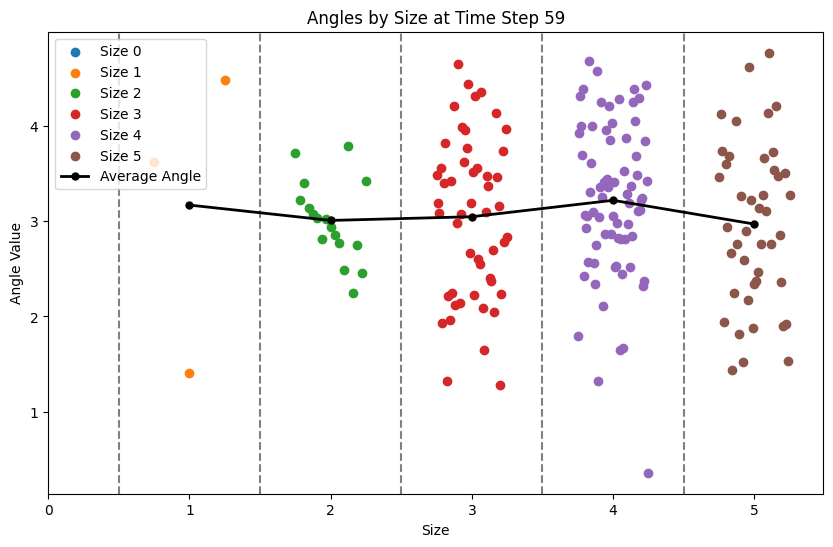

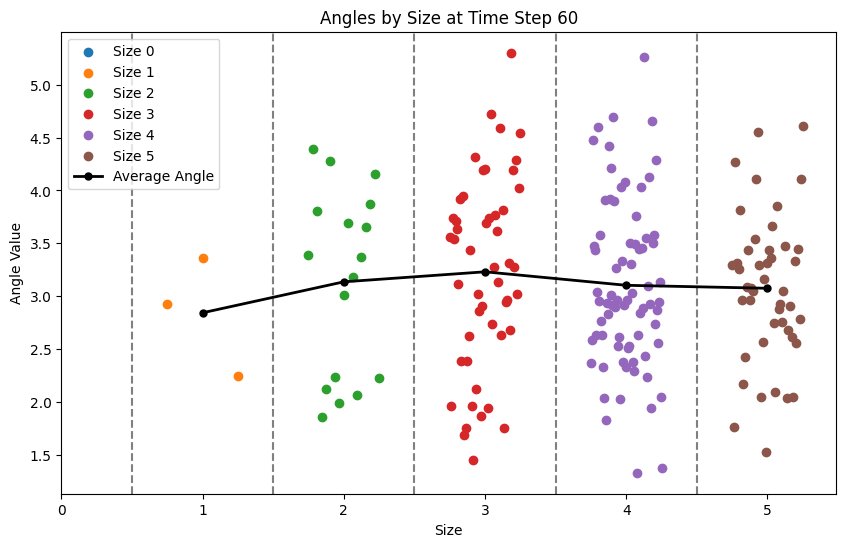

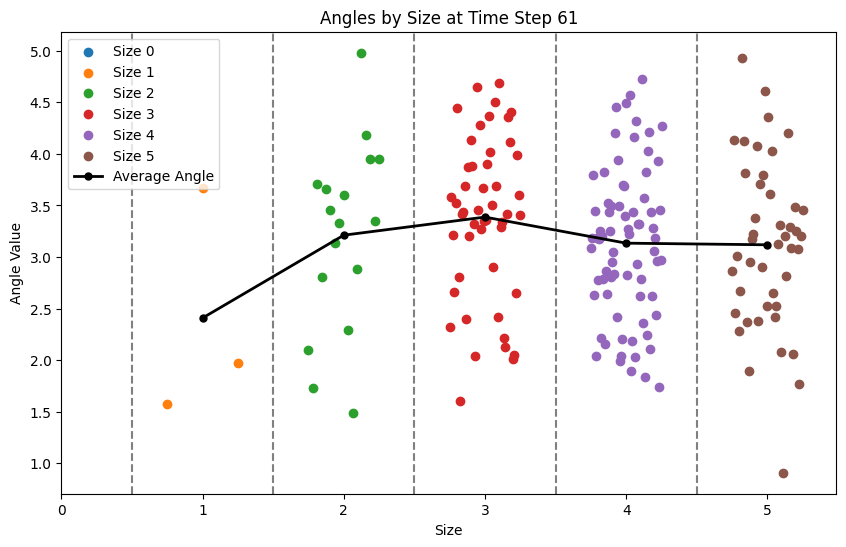

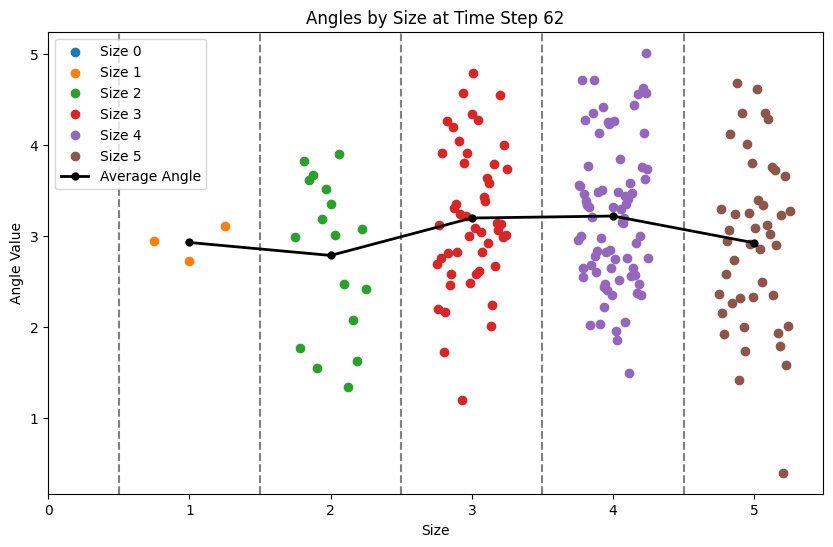

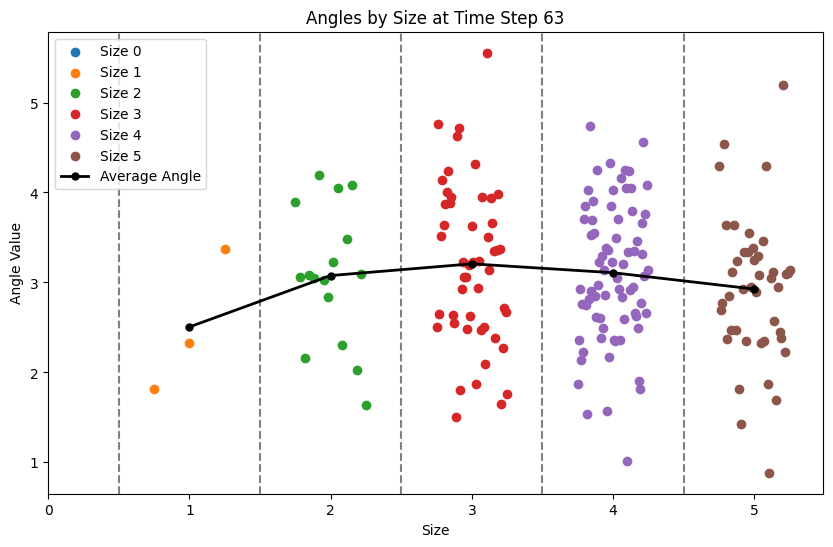

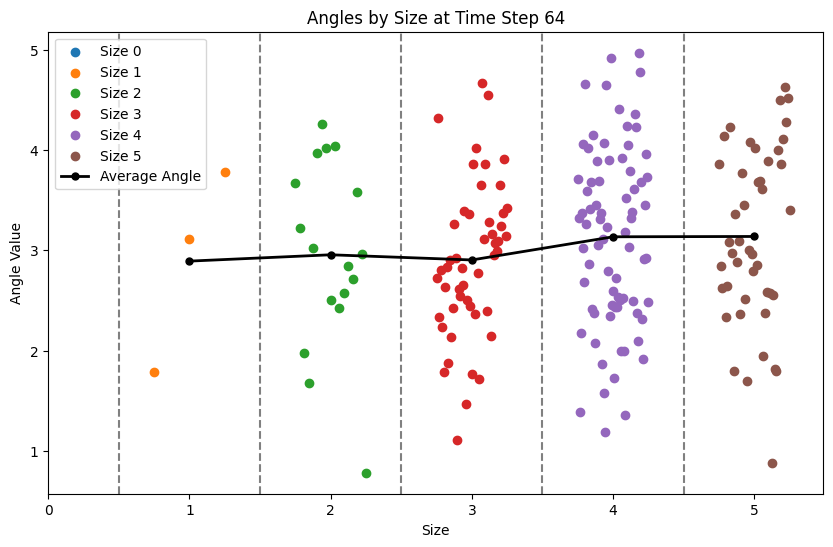

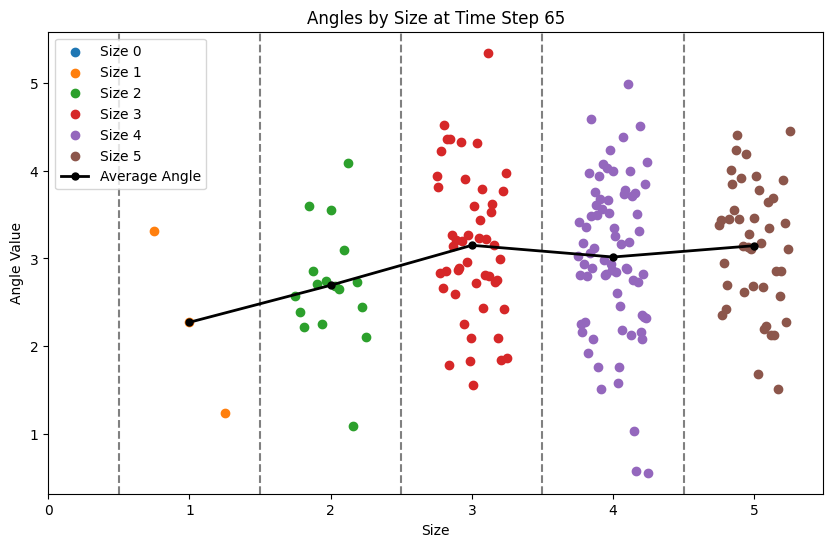

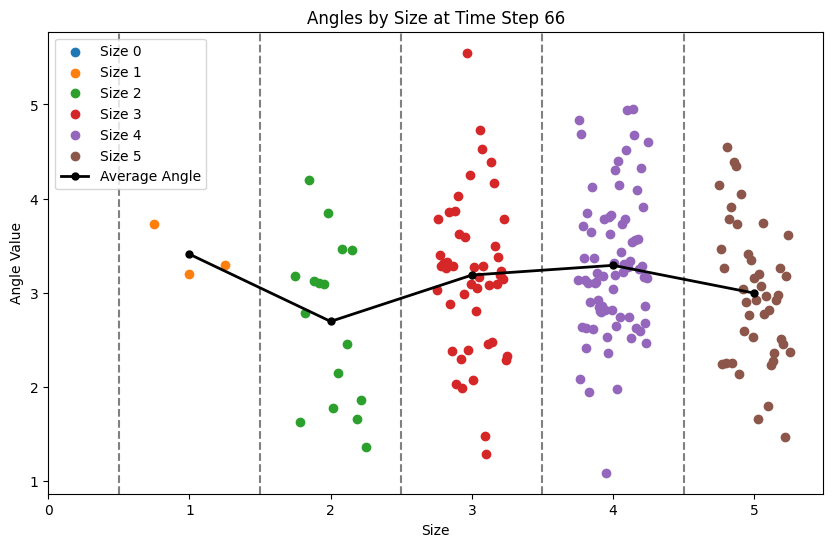

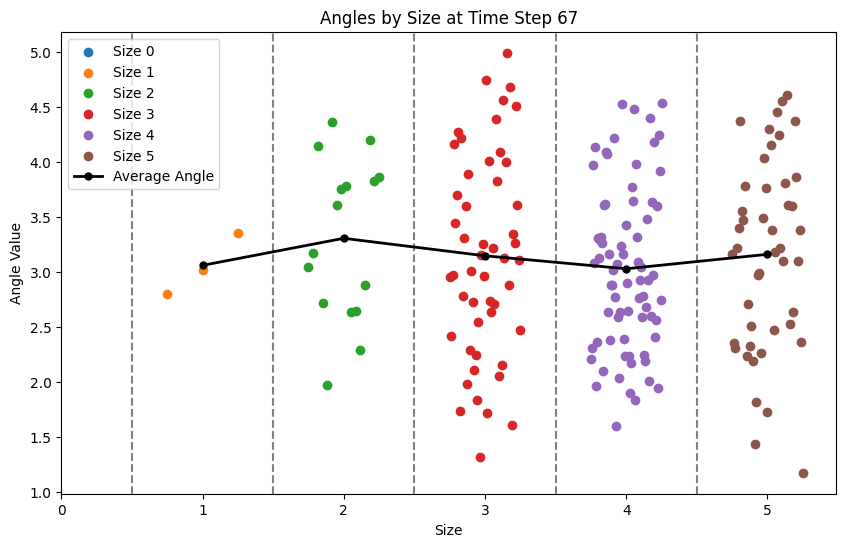

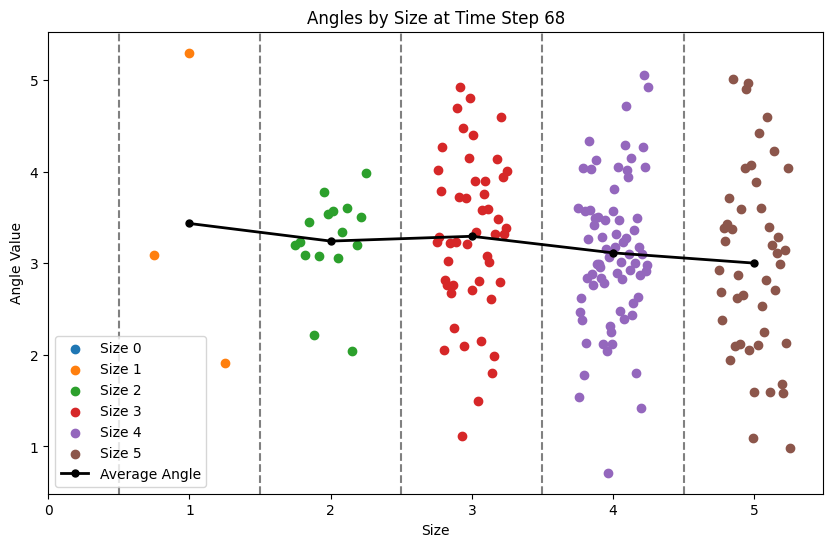

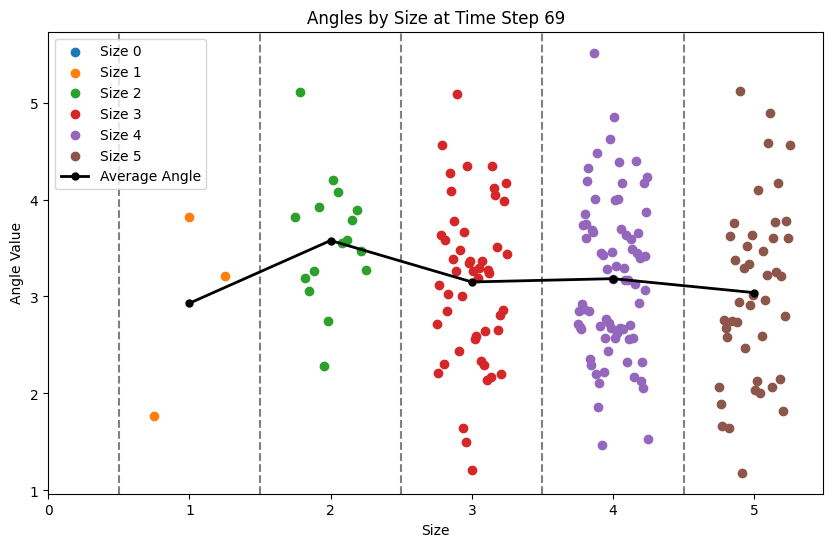

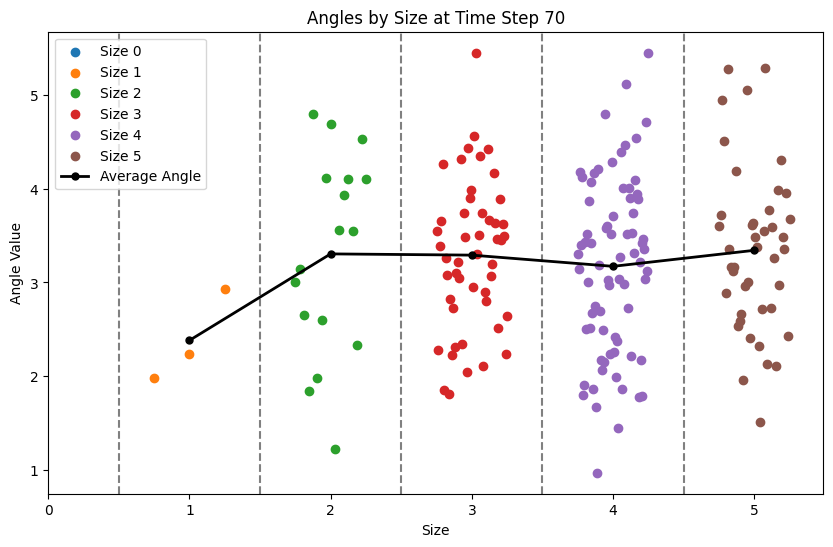

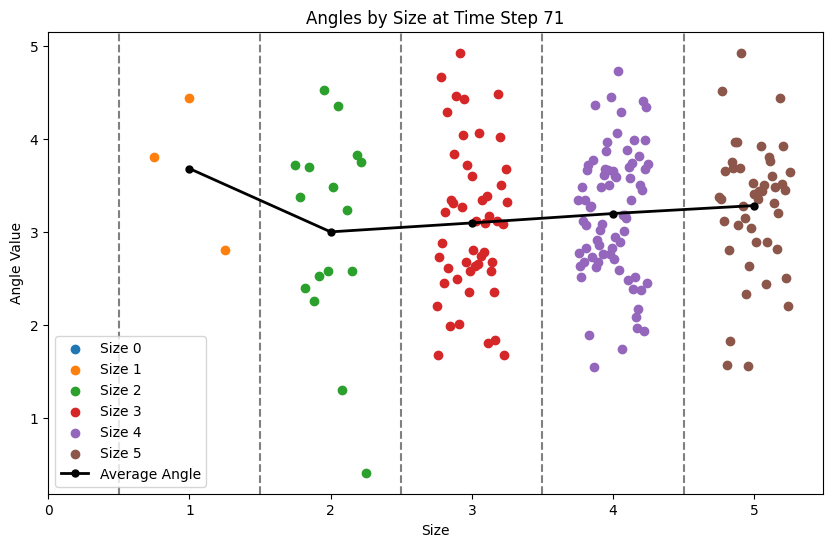

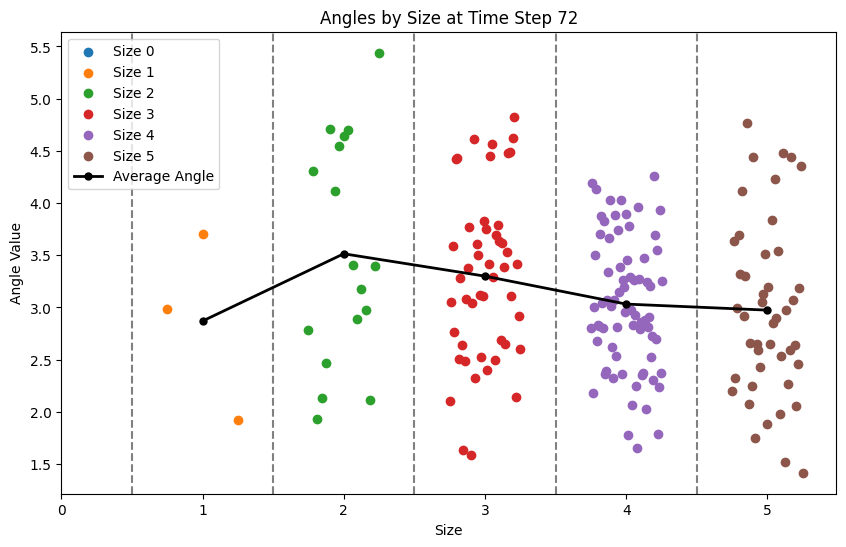

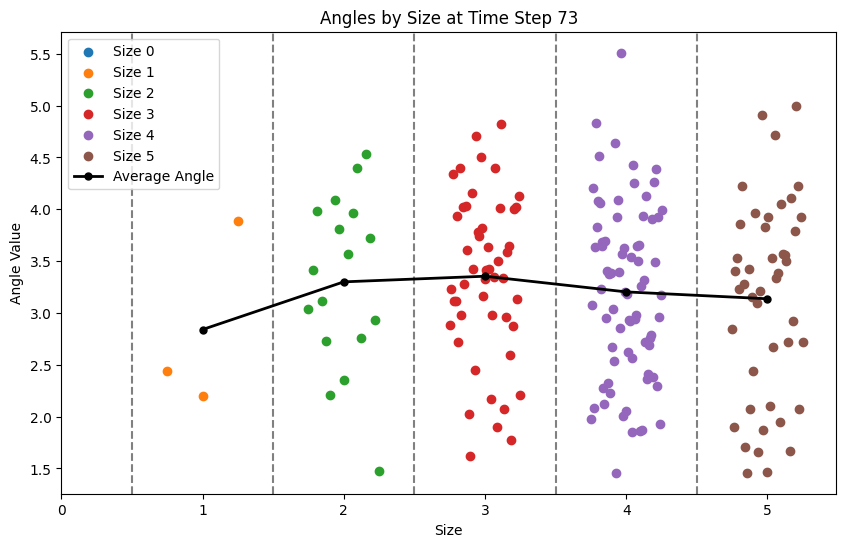

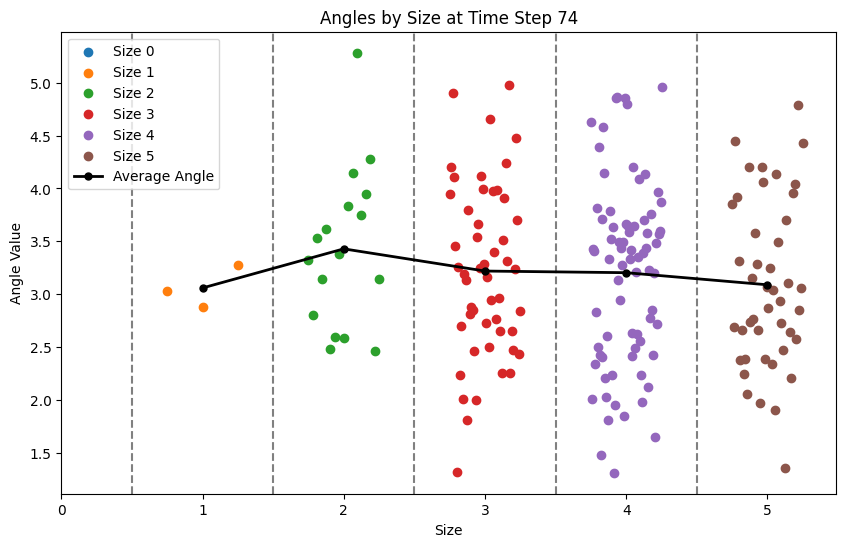

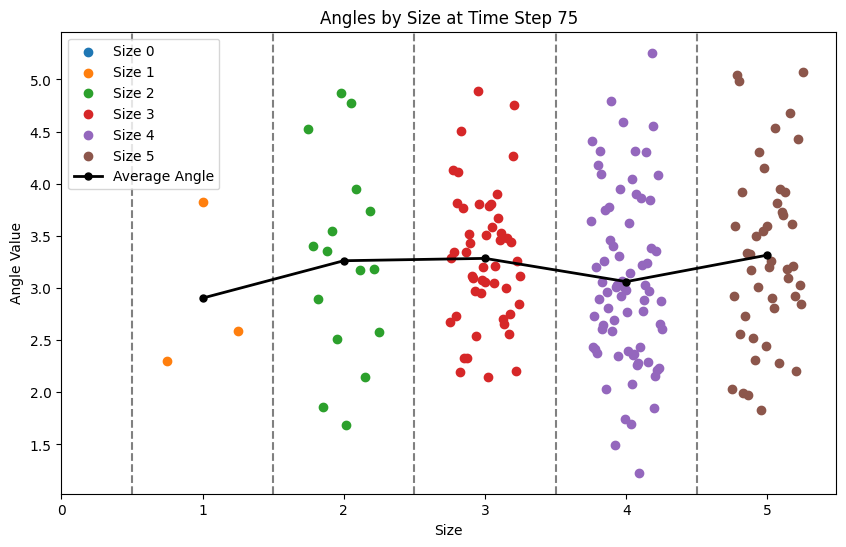

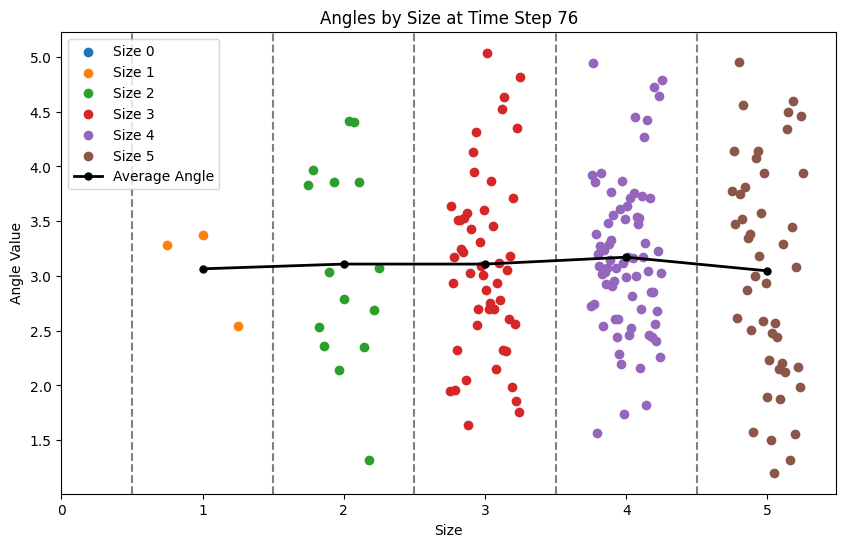

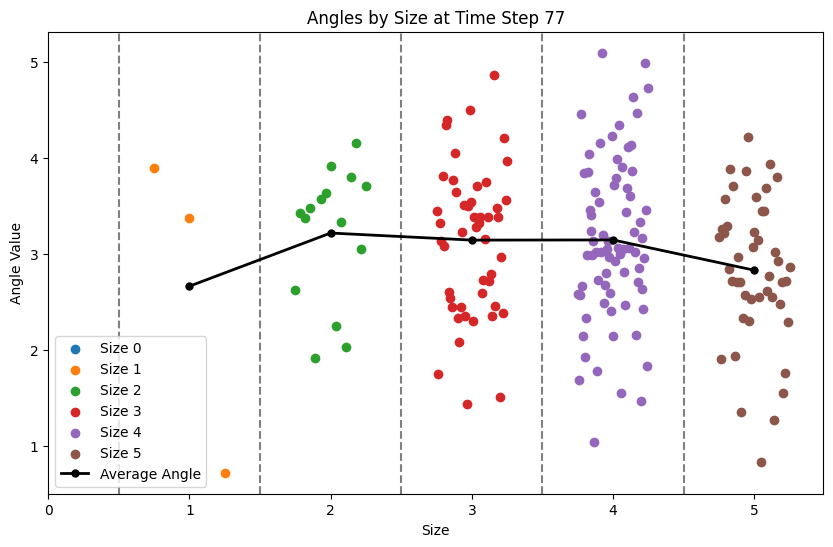

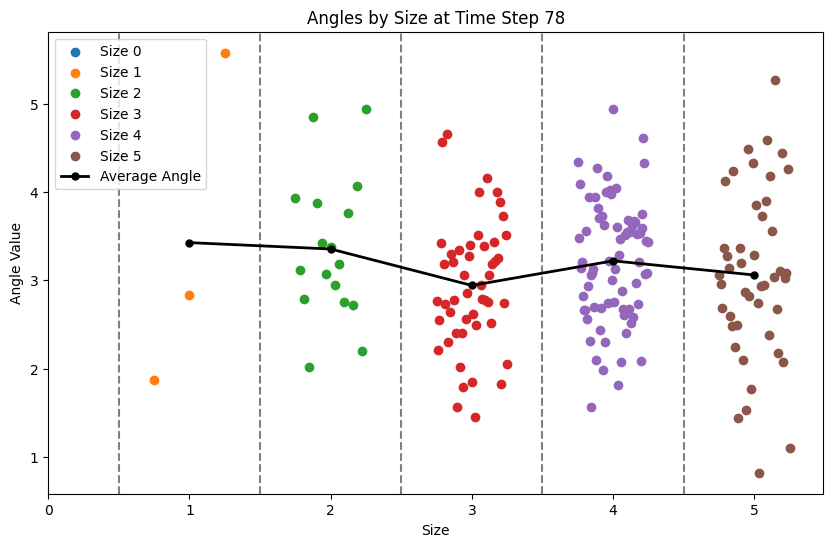

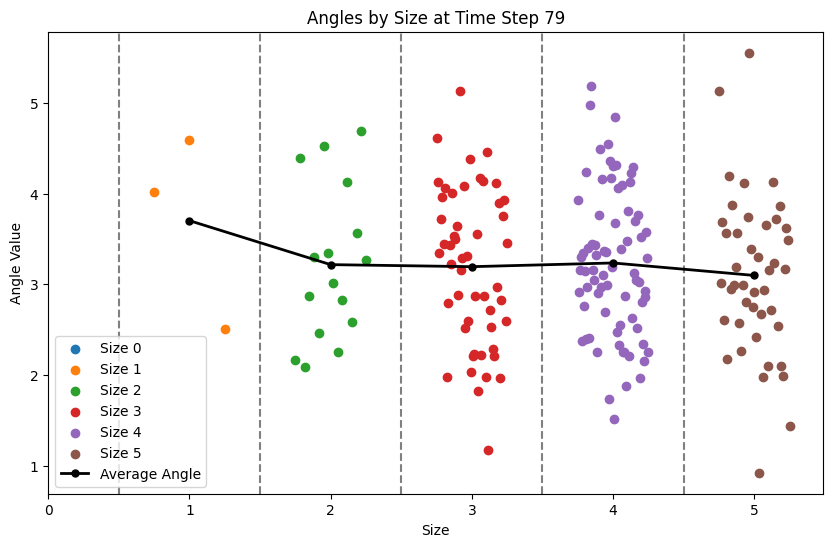

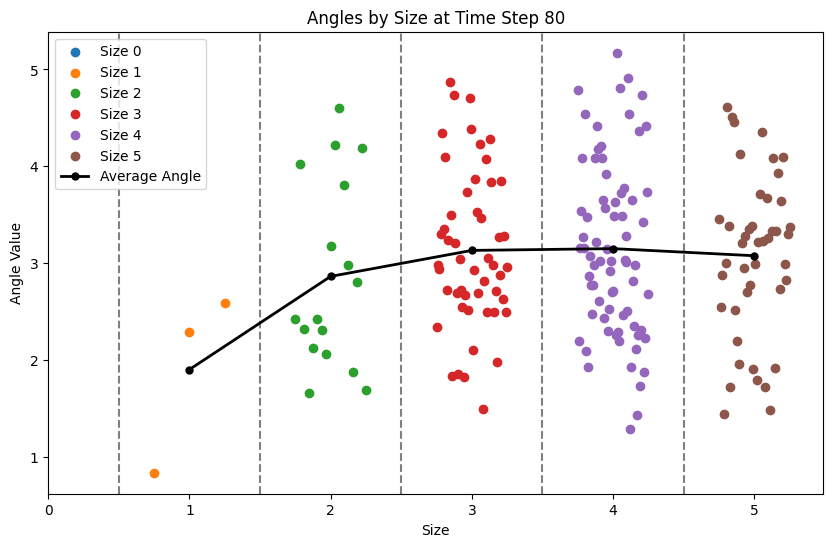

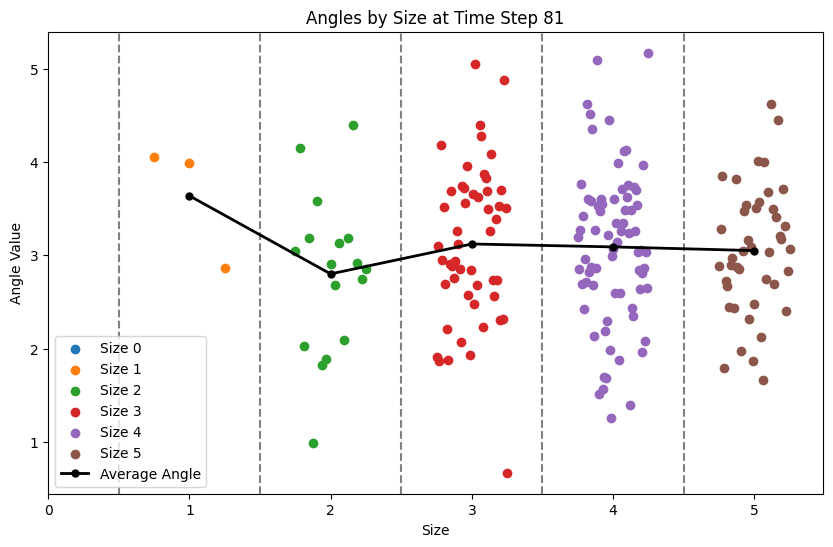

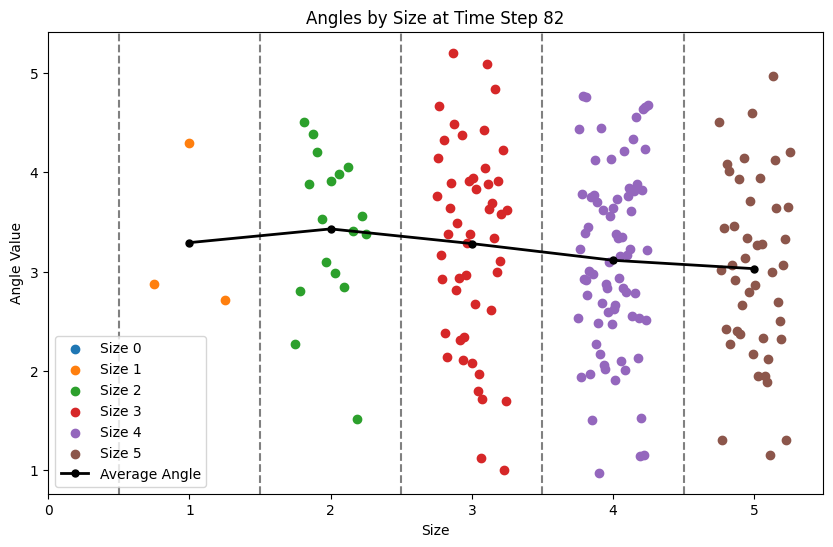

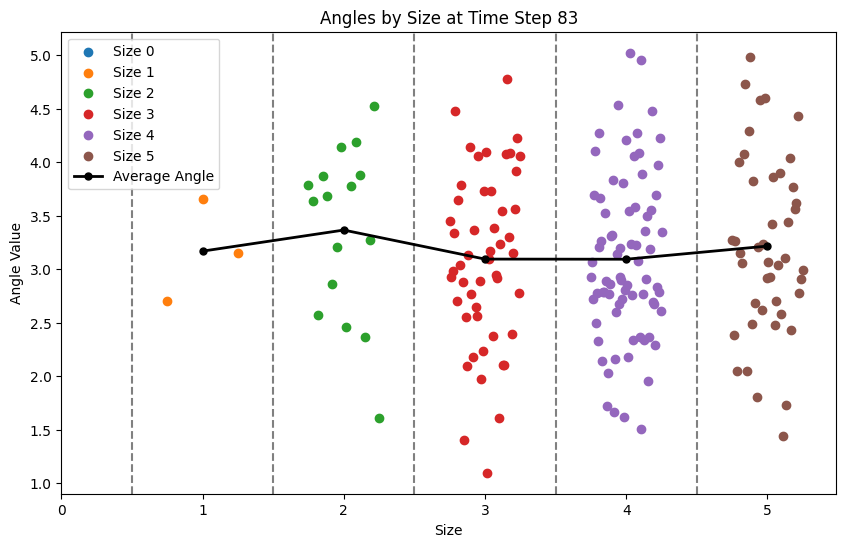

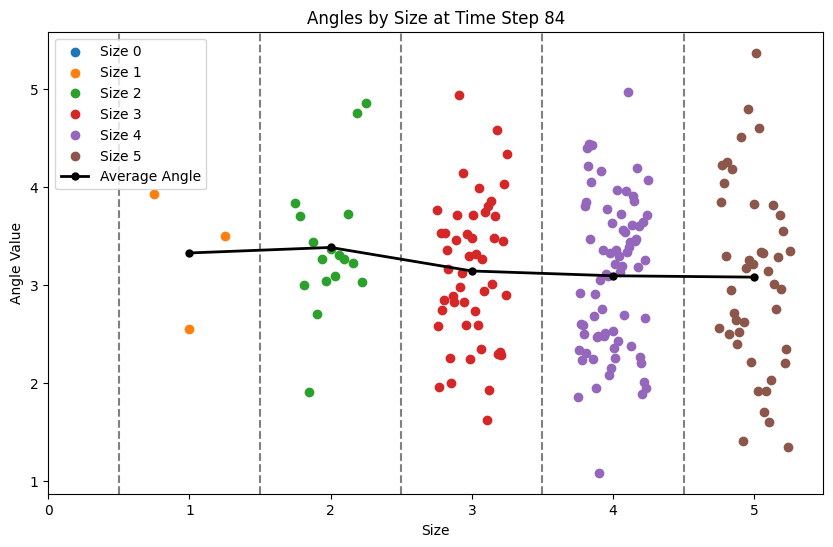

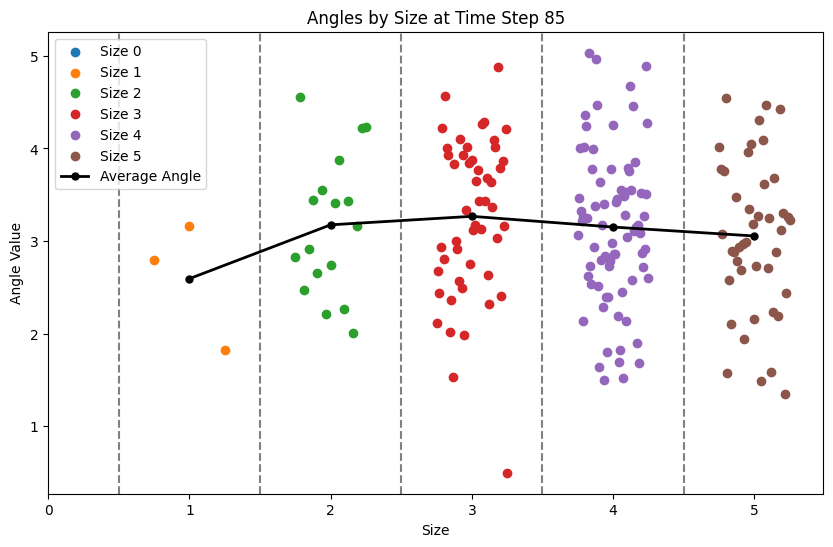

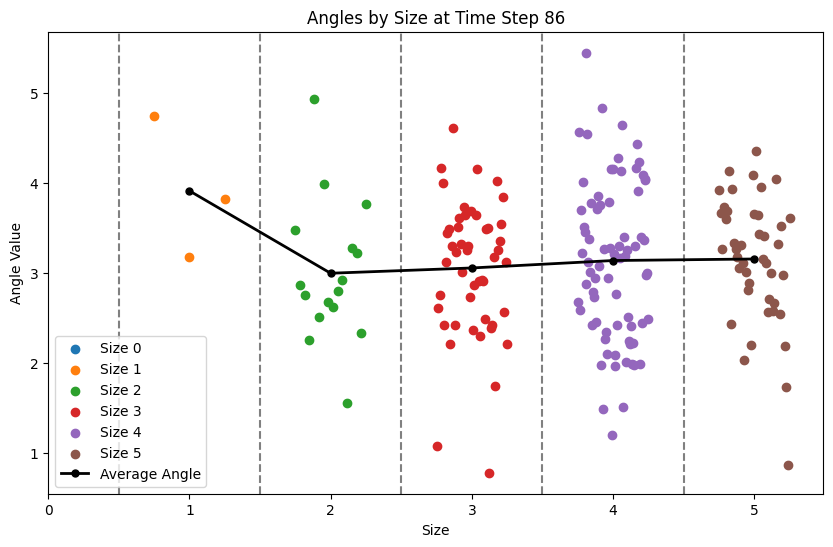

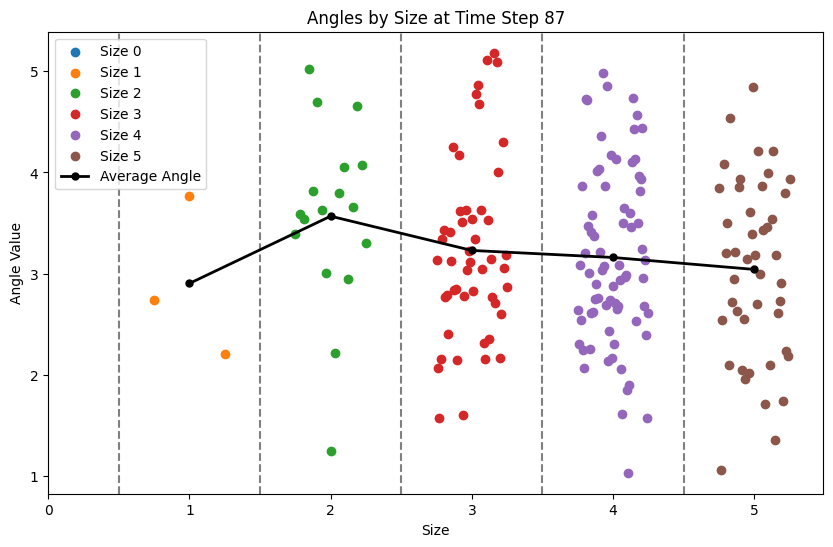

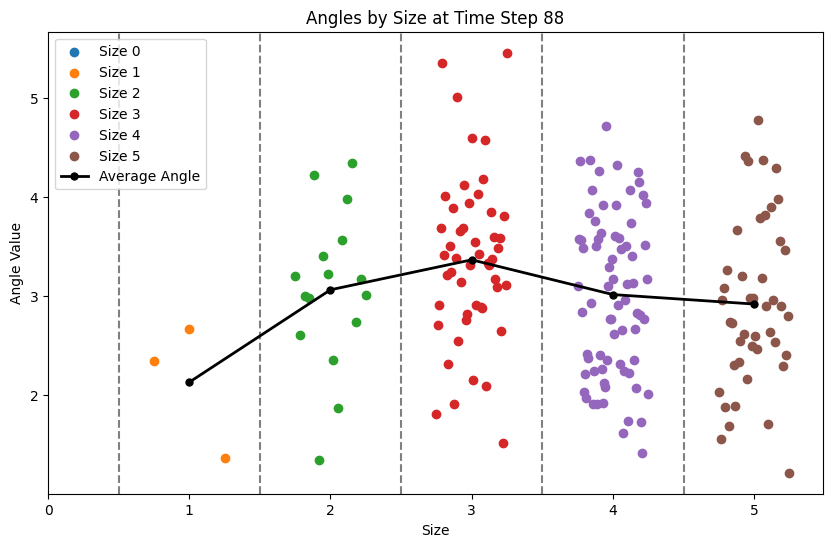

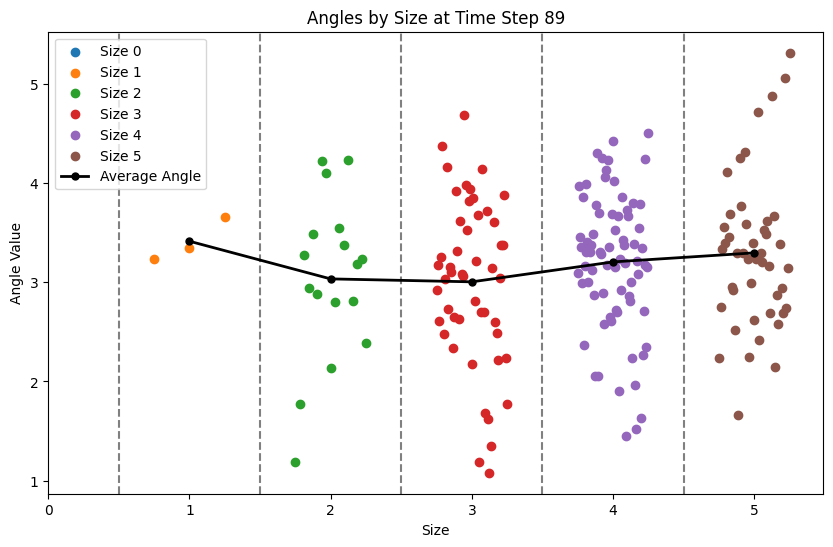

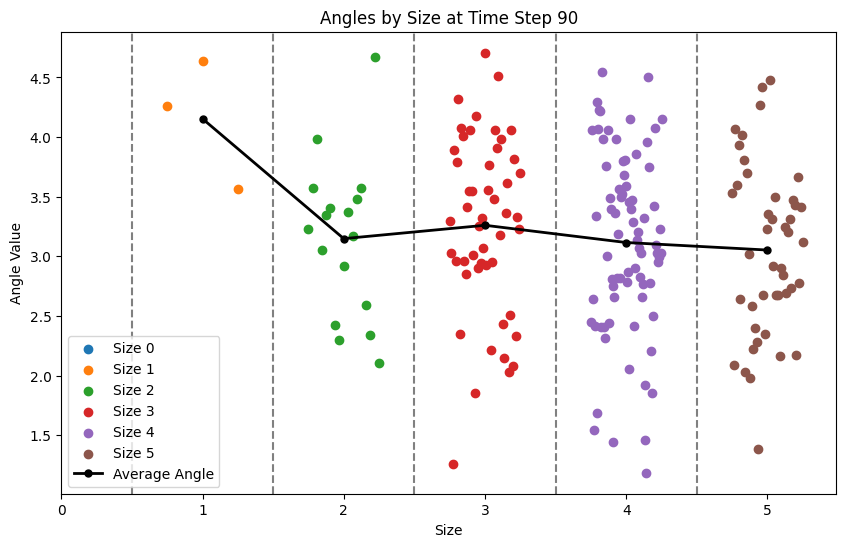

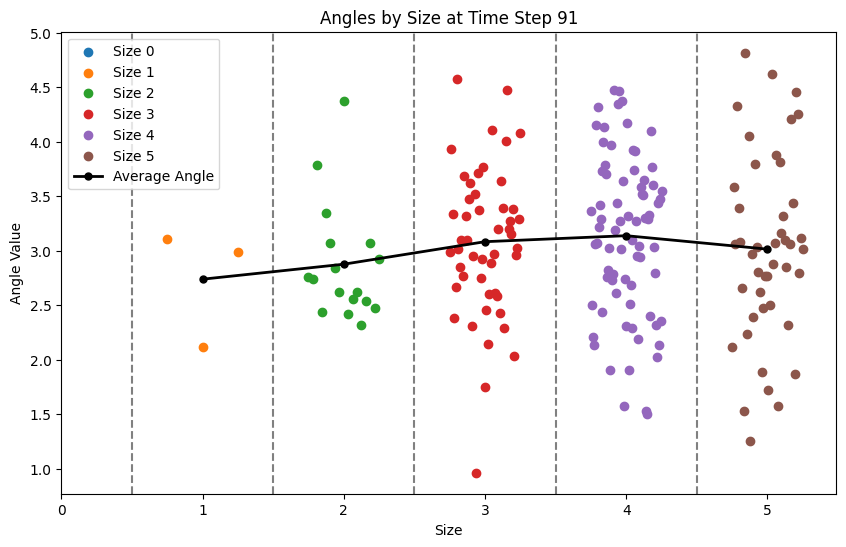

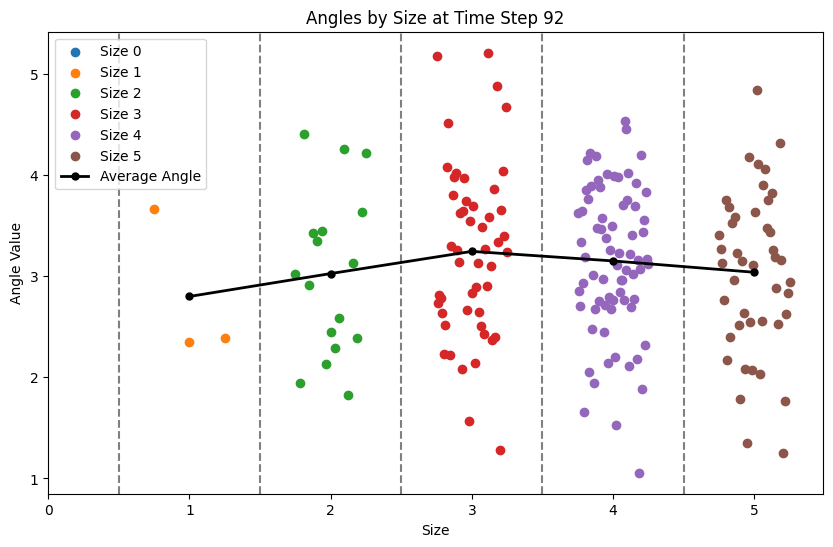

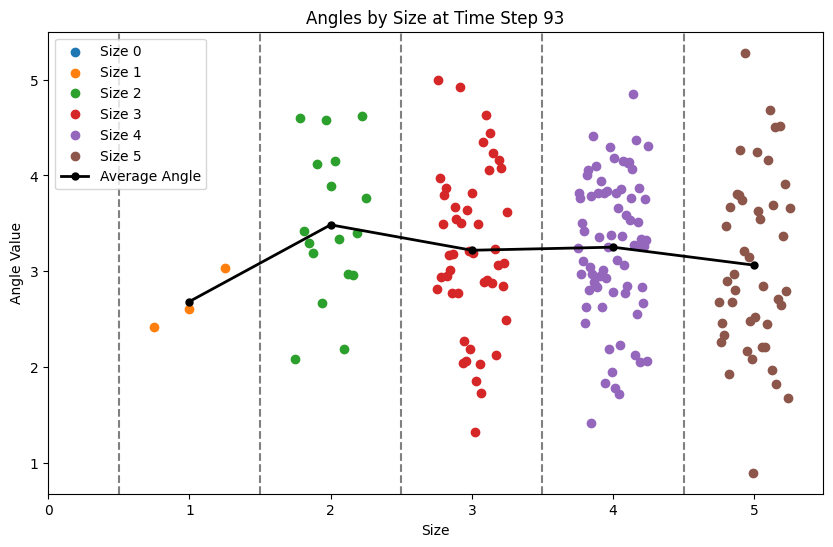

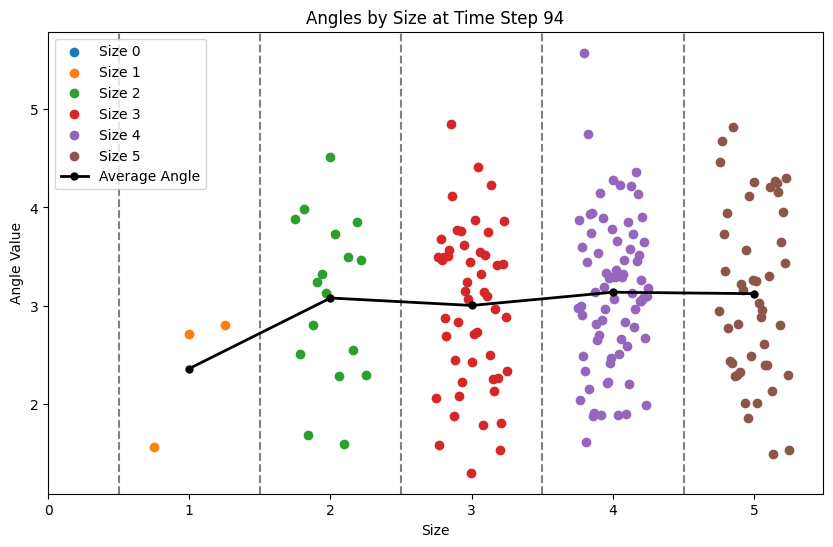

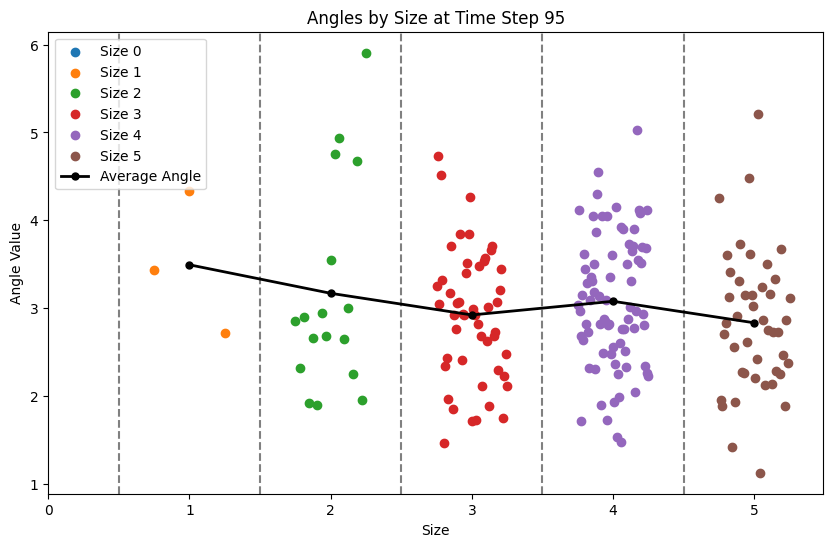

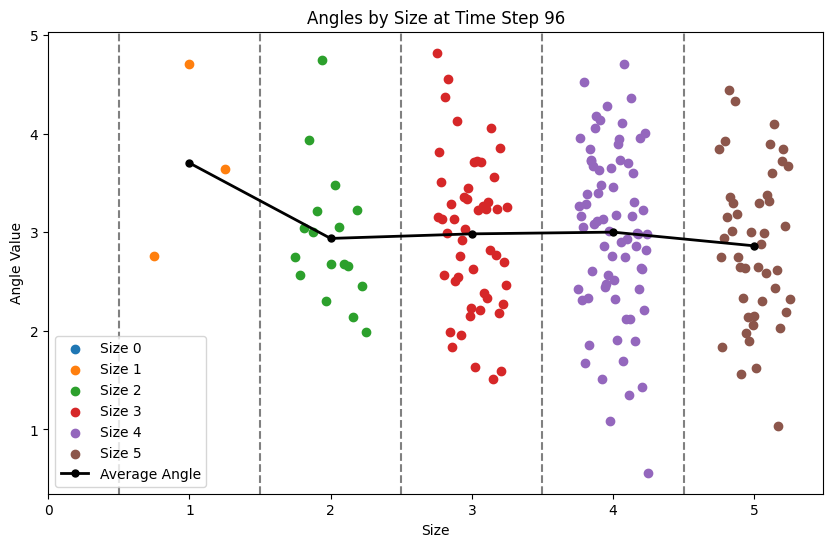

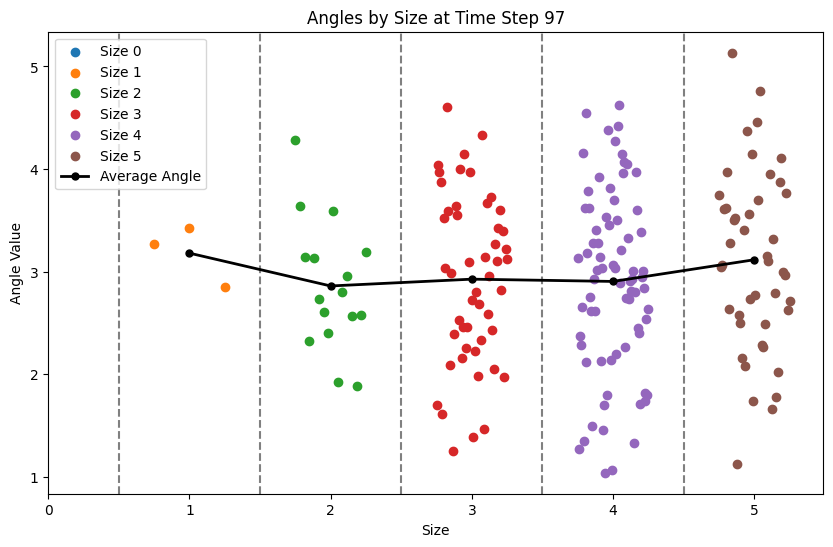

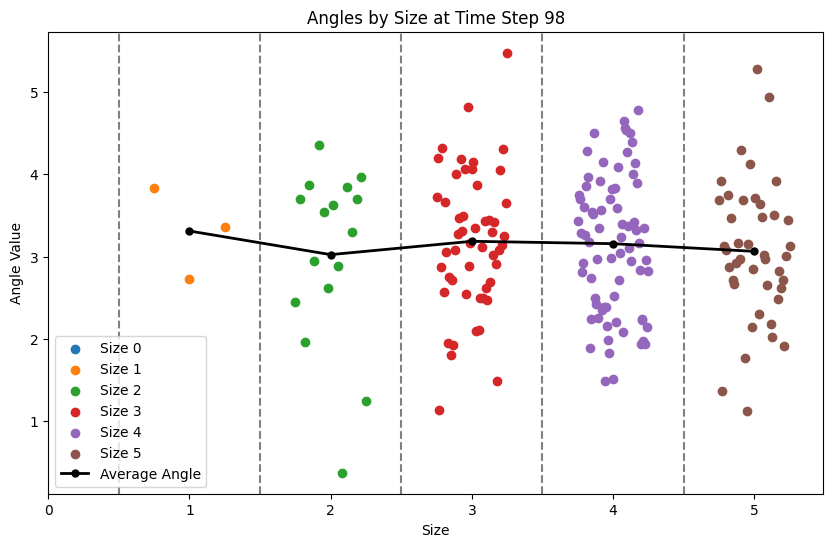

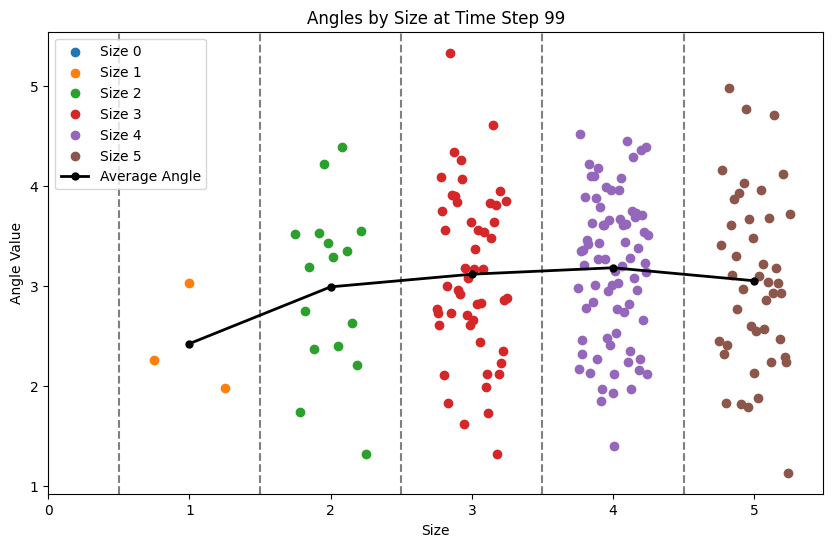

In [52]:
for times_ang in range(time):

    # Prepare the plot
    plt.figure((times_ang+1),figsize=(10, 6))

    # Lists to store the averages and their corresponding size values
    average_angles = []
    size_values_for_averages = []

    # Generate x values for each size, ensuring they are separated into N+1 parts
    x_values = np.arange(N+1)

    # For each size, plot the angles at the fixed time step
    for n in range(N+1):
        angles_at_n = angles_promediate[times_ang][n]  # This gets the angles for size n at time t_fixed
        y_values = angles_at_n  # The angles to be plotted
        
        # Calculate the average angle for the current size
        average_angle = np.mean(y_values)
        average_angles.append(average_angle)
        size_values_for_averages.append(n)
        
        # Adjust the spread calculation to center the dots around their size
        num_dots = len(y_values)
        max_spread = 0.5  # Maximum spread allowed on either side of the center
        if num_dots > 1:
            spacing_factor = max_spread / (num_dots - 1)  # Adjust spacing factor based on number of dots
        else:
            spacing_factor = 0  # No spread needed for a single dot

        # Center the spread around the size value, ensuring it stays within the vertical lines
        x_spread = [n + ((i - (num_dots - 1) / 2) * spacing_factor) for i in range(num_dots)]
        
        # Scatter plot for each size with an ordered spread on the x-axis
        plt.scatter(x_spread, y_values, label=f'Size {n}')

        # Draw vertical lines to separate different sizes
        if n < N:  # Avoid drawing a line after the last size
            plt.axvline(x=n + 0.5, color='grey', linestyle='--')

    # Plot the line connecting the averages
    plt.plot(size_values_for_averages, average_angles, color='k', marker='o', linestyle='-', linewidth=2, markersize=5, label='Average Angle')

    plt.title(f'Angles by Size at Time Step {times_ang}')
    plt.xlabel('Size')
    plt.ylabel('Angle Value')
    plt.xticks(x_values)  # Set x-ticks to clearly show each size
    plt.legend()
    plt.show()

## Some ideas

Vemos que para el tiempo t=4=N el size más común es el 3, sin embargo la distribución de size tiene más peso para el size =1. Viendo las gráficas de comparación de coeficientes vemos que casi toda la prob todavía está acumulada en un único pauli string. No sé si hay que dejarlo correr más tiempo o ahí ya se vuelve totalmente caótico.

## Comprobations

### Check for the Apendix B table

In [55]:
# Variables
break
N=3 #number of qubits
np.random.seed(1)  # seed to reproduce h samplings
b = np.pi / 4  # transverse X rotation
J = np.pi / 4  # ZZ rotation strength
# h = np.zeros(N)#np.array([0.0316079, 0.00519953 ,0.0283397]) 
h = np.random.rand(N)*0.0
comb=pauli_combinations(N)

#Hamiltonian
terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()


time=7
comprobation=[PauliGate('III'),PauliGate('XII'),PauliGate('YII'),PauliGate('ZII')]
ex=[]
for example in comprobation:
    times_tr=[]
    for t in range(time):
        coeft=[]
        for com in comb:
            coeft.append(np.trace(np.dot(OpHeis_tr(example,t),PauliGate(com)))*(1/2**N))

        coefs_tr = dict(zip(comb, coeft)) #append coefficients

        times_tr.append(coefs_tr) #at each time
    ex.append(times_tr)

SyntaxError: 'break' outside loop (3034363822.py, line 2)

#### Print the operators

In [ ]:
for example in comprobation:
    print('Evolution of '+ example.params[0])
    for t in range(time):
        operator = ""
        for pauli_string, coefficient in ex[comprobation.index(example)][t].items():
            if np.round(coefficient.imag, 5) == 0:
                real_coefficient = coefficient.real
            else:
                real_coefficient = coefficient
            rounded_coefficient = np.round(real_coefficient, 4)
            if rounded_coefficient != 0:
                operator += f"({rounded_coefficient}*{pauli_string}) + "
        operator = operator[:-3]  # to remove the extra ' + ' at the end
        print("V(t=%i) = " %(t) + operator)

Evolution of III
V(t=0) = (1.0*III)
V(t=1) = (1.0*III)
V(t=2) = (1.0*III)
V(t=3) = (1.0*III)
V(t=4) = (1.0*III)
V(t=5) = (1.0*III)
V(t=6) = (1.0*III)
Evolution of XII
V(t=0) = (1.0*XII)
V(t=1) = (-1.0*YZI)
V(t=2) = (-1.0*IYZ)
V(t=3) = (1.0*IIX)
V(t=4) = (-1.0*IZY)
V(t=5) = (-1.0*ZYI)
V(t=6) = (1.0*XII)
Evolution of YII
V(t=0) = (1.0*YII)
V(t=1) = (-1.0*ZII)
V(t=2) = (-1.0*XZI)
V(t=3) = (-1.0*XXZ)
V(t=4) = (-1.0*XXY)
V(t=5) = (-1.0*XYI)
V(t=6) = (-1.0*YII)
Evolution of ZII
V(t=0) = (1.0*ZII)
V(t=1) = (1.0*XZI)
V(t=2) = (1.0*XXZ)
V(t=3) = (1.0*XXY)
V(t=4) = (1.0*XYI)
V(t=5) = (1.0*YII)
V(t=6) = (-1.0*ZII)
